# (h) Langevin dynamics
### Learning letters after digits

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

try:
    import accimage
except ImportError:
    accimage = None

import random
import copy
import time

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import struct
import glob
import datetime
import re

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

## Model

In [2]:
# learning rule

class STDP(nn.Module):
    def __init__(self, conv_layer, learning_rate, quantiles=1, \
                 use_stabilizer=True, lower_bound=0, upper_bound=1):
        super(STDP, self).__init__()
        self.conv_layer = conv_layer
        if isinstance(learning_rate, list):
            self.learning_rate = learning_rate
        else:
            self.learning_rate = [learning_rate] * conv_layer.out_channels
        for i in range(conv_layer.out_channels):
            self.learning_rate[i] = (Parameter(torch.tensor([self.learning_rate[i][0]])),
                            Parameter(torch.tensor([self.learning_rate[i][1]])))
            self.register_parameter('ltp_' + str(i), self.learning_rate[i][0])
            self.register_parameter('ltd_' + str(i), self.learning_rate[i][1])
            self.learning_rate[i][0].requires_grad_(False)
            self.learning_rate[i][1].requires_grad_(False)
        self.use_stabilizer = use_stabilizer
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.quantiles = quantiles

    def get_pre_post_ordering(self, input_spikes, output_spikes, winners):

        # accumulating input and output spikes to get latencies
        input_latencies = torch.sum(input_spikes, dim=0)
        output_latencies = torch.sum(output_spikes, dim=0)
        result = []
        for winner in winners:
            # generating repeated output tensor with the same size of the receptive field
            out_tensor = torch.ones(*self.conv_layer.kernel_size, device=output_latencies.device) * output_latencies[winner]
            # slicing input tensor with the same size of the receptive field centered around winner
            # since there is no padding, there is no need to shift it to the center
            in_tensor = input_latencies[:,winner[-2]:winner[-2]+self.conv_layer.kernel_size[-2],winner[-1]:winner[-1]+self.conv_layer.kernel_size[-1]]
            result.append(torch.ge(in_tensor,out_tensor))
        return result

    # simple STDP rule
    # gets prepost pairings, winners, weights, and learning rates (all shoud be tensors)        
    def forward(self, input_spikes, potentials, output_spikes, winners=None, kwta = 1, inhibition_radius = 0):
        if winners is None:
            winners = sf.get_k_winners(potentials, kwta, inhibition_radius, output_spikes)
        
        pairings = self.get_pre_post_ordering(input_spikes, output_spikes, winners)

        lr = torch.zeros_like(self.conv_layer.weight)
        
        for i in range(len(winners)):
            f = winners[i][0]
            lr[f] = torch.where(pairings[i], *(self.learning_rate[f]))
    
        delta_weight = \
        lr * ((self.conv_layer.weight-self.lower_bound) * (self.upper_bound-self.conv_layer.weight) \
              if self.use_stabilizer else 1) 
       
        # limitation of weight changing
        if isinstance(self.quantiles, Tensor):
            
            ones_like_weight_tensor = torch.full_like(self.conv_layer.weight, 1)         
            zero_like_weight_tensor = torch.zeros_like(self.conv_layer.weight)     

            mask_tensor_change = torch.where(torch.abs(delta_weight) > 0.0, \
                                    ones_like_weight_tensor, zero_like_weight_tensor)
            mask_tensor_const = torch.where(torch.abs(delta_weight) > 0.0, \
                                    zero_like_weight_tensor, ones_like_weight_tensor)
            
            weights_taken_away = self.conv_layer.weight.detach().clone() * mask_tensor_change
            
            self.conv_layer.weight -= weights_taken_away 
            
            limitating_weights = weights_taken_away + delta_weight

            quantiles_10 = quantiles[0]
            quantiles_10.resize_(tuple(self.conv_layer.weight.size()))
            quantiles_10 = mask_tensor_change * quantiles_10
 
            quantiles_90 = quantiles[2]
            quantiles_90.resize_(tuple(self.conv_layer.weight.size()))
            quantiles_90 = mask_tensor_change * quantiles_90
            
            limited_weights = torch.max(torch.min(limitating_weights, quantiles_90), quantiles_10) 
            limited_weights = limited_weights.float()
            
            self.conv_layer.weight += limited_weights   
            
        self.conv_layer.weight.clamp_(self.lower_bound, self.upper_bound)   
   
    def update_learning_rate(self, feature, ap, an):
        self.learning_rate[feature][0][0] = ap
        self.learning_rate[feature][1][0] = an

    def update_all_learning_rate(self, ap, an):
        for feature in range(self.conv_layer.out_channels):
            self.learning_rate[feature][0][0] = ap
            self.learning_rate[feature][1][0] = an

In [3]:
# model

class MozafariMNIST2018(nn.Module):
    
    def __init__(self, quantiles=1):
        
        super(MozafariMNIST2018, self).__init__()

        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 3

        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 1

        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)
        self.quantiles = quantiles

        self.stdp1 = STDP(self.conv1, (0.004, -0.003))
        self.stdp2 = STDP(self.conv2, (0.004, -0.003))
        self.stdp3 = STDP(self.conv3, (0.004, -0.003), self.quantiles, False, 0.2, 0.8)
        self.anti_stdp3 = STDP(self.conv3, (-0.004, 0.0005), self.quantiles, False, 0.2, 0.8)
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0

    def forward(self, input, max_layer):
        
        input = sf.pad(input.float(), (2,2,2,2), 0)
        
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1))
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2))
            pot = self.conv3(spk_in)
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output

    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)

    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

In [4]:
#train and test

def train_unsupervise(network, data, layer_idx):
    network.train()
    
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def train_rl(network, data, target):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward()
            else:
                perf[1]+=1
                network.punish()
        else:
            perf[2]+=1
    return perf/len(data)

def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

In [5]:
def curve_graph(parametr_set):

    plt.subplots(figsize=(15, 5))

    plt.plot(parametr_set['epoch'], parametr_set['train']*100, color='cyan', label='train')
    plt.plot(parametr_set['epoch'], parametr_set['test']*100, color='blue', marker = 'o', label='test')
    plt.plot(parametr_set['epoch'], parametr_set['test_previous']*100, linestyle = ':', color='red', label='test of previous images')
    plt.xlabel('epochs', loc='right', fontsize=17)
    plt.ylabel('accuracy, %',  loc='top', fontsize=17)
    plt.grid()
    plt.legend()
    plt.show()

In [6]:
def draw_3_plot(tensor_4d, text):     
    
    plt.subplots(figsize=(15, 2))
    tensor_list = tensor_4d.flatten().cpu().detach().clone().numpy()
    plt.title(f'{text} on graph', fontsize=15)
    plt.xlabel('weights', loc='right', fontsize=12)
    plt.ylabel('quantity of weights',  loc='top', fontsize=12)
    plt.grid()
    plt.plot(np.arange(len(tensor_list)), tensor_list)
    plt.show()

In [7]:
def draw_3_hist(tensor_4d, text):     
    
    plt.subplots(figsize=(15, 2))
    tensor_list = tensor_4d.flatten().cpu().detach().clone().numpy()
    plt.title(f'{text} on histogram', fontsize=15)
    plt.xlabel('weights', loc='right', fontsize=12)
    plt.ylabel('quantity of weights',  loc='top', fontsize=12)
    plt.grid()
    plt.hist(tensor_list, log=True, bins=500, color='c')
    plt.show()

In [8]:
# training the 3rd layer

def third_layer(file_name_net, file_name_csv, adaptive_int, epochs, 
                train_loader, test_loader, test_previous_loader,
                model, apr, anr, app, anp, parametr_set):  
    
    '''
    file_name_net - name of file for saving state_dict of model
    file_name_csv - name of file for saving parameters of model in each epoch
    adaptive_int - learning rate parameter
    '''

    adaptive_min=0 
    counter = 0

    apr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * apr
    anr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * anr
    app_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * app
    anp_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * anp

    best_train = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
    best_test = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
    best_test_previous = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
   
    for epoch in range(epochs):
        
        seconds_epoch_0 = time.time() 
        
        print('-'*50)
        print("Epoch #: ", epoch)
        
        perf_train = np.array([0.0,0.0,0.0]) 
        
        for data,targets in train_loader:
              
            draw_3_plot(model.conv3.weight, f'{epoch} epoch before train RL')
            draw_3_hist(model.conv3.weight, f'{epoch} epoch before train RL')
            
            perf_train_batch = train_rl(model, data, targets)
            
            draw_3_plot(model.conv3.weight, f'{epoch} epoch after train RL')
            draw_3_hist(model.conv3.weight, f'{epoch} epoch after train RL')
    
            #update adaptive learning rates
            apr_adapt = apr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            anr_adapt = anr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            app_adapt = app * (perf_train_batch[0] * adaptive_int + adaptive_min)
            anp_adapt = anp * (perf_train_batch[0] * adaptive_int + adaptive_min)
            
            parametr_set.loc[counter, 'epoch'] = epoch
            parametr_set.loc[counter, 'train'] = perf_train_batch[0]

            model.update_learning_rates(apr_adapt, anr_adapt, app_adapt, anp_adapt)
            perf_train += perf_train_batch
            
        perf_train /= len(train_loader)

        if best_train[0] <= perf_train[0]:
            best_train = np.append(perf_train, epoch)
        print(f"Current Train: {perf_train[0]*100 :.2f}%")

        for data,targets in test_loader:
            perf_test = test(model, data, targets)
            parametr_set.loc[counter, 'test'] = perf_test[0]
            if best_test[0] <= perf_test[0]:
                best_test = np.append(perf_test, epoch)
                torch.save(model.state_dict(), file_name_net)
            print(f"Current Test: {perf_test[0]*100 :.2f}%")

        if isinstance(test_previous_loader, DataLoader):
            for data,targets in test_previous_loader:
                perf_test_previous = test(model, data, targets)
                parametr_set.loc[counter, 'test_previous'] = perf_test_previous[0]
                if best_test_previous[0] <= perf_test_previous[0]:
                    best_test_previous = np.append(perf_test_previous, epoch)
                print(f"Current Test Previous: {perf_test_previous[0]*100 :.2f}%")
                
        else:
            parametr_set.loc[counter, 'test_previous'] = 0
            
        counter += 1
                                                 
        seconds_epoch_1 = time.time()  
        print(f'Operational time of epoch #{epoch}: '
                  f'{int((seconds_epoch_1 - seconds_epoch_0)//60)} min {int((seconds_epoch_1 - seconds_epoch_0)%60)} sec') 
    
    parametr_set.to_csv(file_name_csv)
    
    print('=='*10, 'SUMMARY', '=='*10)
    print(f"        Best Train: {best_train[0]*100 :.2f}% on {best_train[3] :.0f} epoch")
    print(f"         Best Test: {best_test[0]*100 :.2f}% on {best_test[3] :.0f} epoch")
    print(f"Best Test Previous: {best_test_previous[0]*100 :.2f}% on {best_test_previous[3] :.0f} epoch")
    
    return parametr_set

In [9]:
# for image transformation (see dataset)

class S1C1Transform:
    
    def __init__(self, filter, PIL_type=False, timesteps = 15):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
        
    def __call__(self, image):
        if self.cnt % 20000 == 0:
            print(f'{self.cnt} images')
        if self.PIL_type:
            image = self.to_pil_image(image)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

In [10]:
# for image transformation (see dataset)

kernels = [ utils.DoGKernel(3,3/9,6/9),
            utils.DoGKernel(3,6/9,3/9),
            utils.DoGKernel(7,7/9,14/9),
            utils.DoGKernel(7,14/9,7/9),
            utils.DoGKernel(13,13/9,26/9),
            utils.DoGKernel(13,26/9,13/9)]

filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)
s1c1_PIL = S1C1Transform(filter, PIL_type=True)

In [11]:
# for image transformation (see dataset)

class CustomTensorDataset(Dataset):
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [13]:
def quantiles_show(data, text):
    
    plt.subplots(figsize=(15, 4))

    plt.hist(data.cpu().numpy(), bins=1000);
    plt.grid();
    plt.title(text, fontsize=15);
    plt.xlabel('weights', loc='right', fontsize=12)
    plt.ylabel('quantity of weights',  loc='top', fontsize=12)
    plt.show()

## Sets

### Set of 10 capital letters
24000 train images + 4000 test images

In [14]:
# set of 10 capital letters from EMNIST
path = f'./data/EMNIST_own/capital_letters/'

test_letter_labels = torch.load(f'{path}Mozafari_capital_letters_test_labels.pt', map_location=torch.device('cpu'))
test_letters = torch.load(f'{path}Mozafari_capital_letters_test_images.pt', map_location=torch.device('cpu'))

train_letter_labels = torch.load(f'{path}Mozafari_capital_letters_train_labels.pt', map_location=torch.device('cpu'))
train_letters = torch.load(f'{path}Mozafari_capital_letters_train_images.pt', map_location=torch.device('cpu'))

# Element permutation

train_order_l = torch.randperm(train_letter_labels.shape[0])
test_order_l = torch.randperm(test_letter_labels.shape[0])

train_letter_labels = train_letter_labels[train_order_l].view(train_letter_labels.size())
train_letters = train_letters[train_order_l].view(train_letters.size())

test_letter_labels = test_letter_labels[test_order_l].view(test_letter_labels.size())
test_letters = test_letters[test_order_l].view(test_letters.size())

# Loaders

train_letter_set = CustomTensorDataset(tensors=(train_letters, train_letter_labels), transform=s1c1_PIL)
test_letter_set = CustomTensorDataset(tensors=(test_letters, test_letter_labels), transform=s1c1_PIL)

train_letter_loader = DataLoader(train_letter_set, batch_size=len(train_letter_set))
test_letter_loader = DataLoader(test_letter_set, batch_size=len(test_letter_set))

train_letter_labels.size(), test_letter_labels.size()

(torch.Size([24000]), torch.Size([4000]))

### Set of 10 MNIST digits
Reduction 60000 train + 10000 test images to 24000 train + 4000 test images

In [15]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [16]:
# the set of 10 digit images, the same size as the set of letters (2400 trains + 400 tests per class)

# the MNIST data was pre-divided into 10 classes
path = f'./data/MNIST_0_1_2_3_4_5_6_7_8_9/'

train_number = 2400
test_number = 400

for i in classes: 
    globals()[f'train_digit_{i}_images'] = torch.load(f'{path}train_images_{i}.pt', \
                                                      map_location=torch.device('cpu'))[0:train_number]
    globals()[f'train_digit_{i}_labels'] = torch.load(f'{path}train_labels_{i}.pt', \
                                                      map_location=torch.device('cpu'))[0:train_number]
    globals()[f'test_digit_{i}_images'] = torch.load(f'{path}test_images_{i}.pt', \
                                                     map_location=torch.device('cpu'))[0:test_number]
    globals()[f'test_digit_{i}_labels'] = torch.load(f'{path}test_labels_{i}.pt', \
                                                     map_location=torch.device('cpu'))[0:test_number]

train_MNIST_labels = globals()[f'train_digit_0_labels']
train_MNIST_images = globals()[f'train_digit_0_images']
test_MNIST_labels = globals()[f'test_digit_0_labels']
test_MNIST_images = globals()[f'test_digit_0_images']                                 

for i in range(1, 10):
    train_MNIST_labels = torch.cat((train_MNIST_labels, globals()[f'train_digit_{i}_labels']), 0)
    train_MNIST_images = torch.cat((train_MNIST_images, globals()[f'train_digit_{i}_images']), 0)

    test_MNIST_labels = torch.cat((test_MNIST_labels, globals()[f'test_digit_{i}_labels']), 0)
    test_MNIST_images = torch.cat((test_MNIST_images, globals()[f'test_digit_{i}_images']), 0)
    
# Element permutation

train_order = torch.randperm(train_MNIST_labels.shape[0])
test_order = torch.randperm(test_MNIST_labels.shape[0])

train_MNIST_labels = train_MNIST_labels[train_order].view(train_MNIST_labels.size())
train_MNIST_images = train_MNIST_images[train_order].view(train_MNIST_images.size())

test_MNIST_labels = test_MNIST_labels[test_order].view(test_MNIST_labels.size())
test_MNIST_images = test_MNIST_images[test_order].view(test_MNIST_images.size())

# Loaders

train_MNIST_set = CustomTensorDataset(tensors=(train_MNIST_images, train_MNIST_labels), transform=s1c1_PIL)
test_MNIST_set = CustomTensorDataset(tensors=(test_MNIST_images, test_MNIST_labels), transform=s1c1_PIL)

train_MNIST_loader = DataLoader(train_MNIST_set, batch_size=len(train_MNIST_set))
test_MNIST_loader = DataLoader(test_MNIST_set, batch_size=len(test_MNIST_set))

train_MNIST_labels.size(), test_MNIST_labels.size()

(torch.Size([24000]), torch.Size([4000]))

In [17]:
# loaders for research purpose

train_digit_labels_r = train_MNIST_labels
train_digit_images_r = train_MNIST_images
test_digit_labels_r = test_MNIST_labels
test_digit_images_r = test_MNIST_images

train_digit_set_r = CustomTensorDataset(tensors=(train_digit_images_r, train_digit_labels_r), transform=s1c1_PIL)
test_digit_set_r = CustomTensorDataset(tensors=(test_digit_images_r, test_digit_labels_r), transform=s1c1_PIL)

train_MNIST_research_loader = DataLoader(train_digit_set_r, batch_size=1)
test_MNIST_research_loader = DataLoader(test_digit_set_r, batch_size=1)

### Combined set of digit set + capital letter set

48000 train + 8000 test images

In [18]:
# digits + letters

train_combi_labels = torch.cat((train_MNIST_labels, train_letter_labels), 0)
train_combi_images = torch.cat((train_MNIST_images, train_letters), 0)
test_combi_labels = torch.cat((test_MNIST_labels, test_letter_labels), 0)
test_combi_images = torch.cat((test_MNIST_images, test_letters), 0)

# Element permutation

train_order_c = torch.randperm(train_combi_labels.shape[0])
test_order_c = torch.randperm(test_combi_labels.shape[0])

train_combi_labels = train_combi_labels[train_order_c].view(train_combi_labels.size())
train_combi_images = train_combi_images[train_order_c].view(train_combi_images.size())

test_combi_labels = test_combi_labels[test_order_c].view(test_combi_labels.size())
test_combi_images = test_combi_images[test_order_c].view(test_combi_images.size())

# Loaders

train_combi_set = CustomTensorDataset(tensors=(train_combi_images, train_combi_labels), transform=s1c1_PIL)
test_combi_set = CustomTensorDataset(tensors=(test_combi_images, test_combi_labels), transform=s1c1_PIL)

train_combi_loader = DataLoader(train_combi_set, batch_size=len(train_combi_set))
test_combi_loader = DataLoader(test_combi_set, batch_size=len(test_combi_set))

train_combi_labels.size(), test_combi_labels.size()

(torch.Size([48000]), torch.Size([8000]))

## Weight distribution of initial SNN trained on digits

In [19]:
# file "quantiles_0.pt" is the result of the file "(h)_Langevin_dynamics_(data_reconstruction).ipynb"
quantiles = torch.load(f'quantiles_0.pt', map_location=torch.device('cuda'))

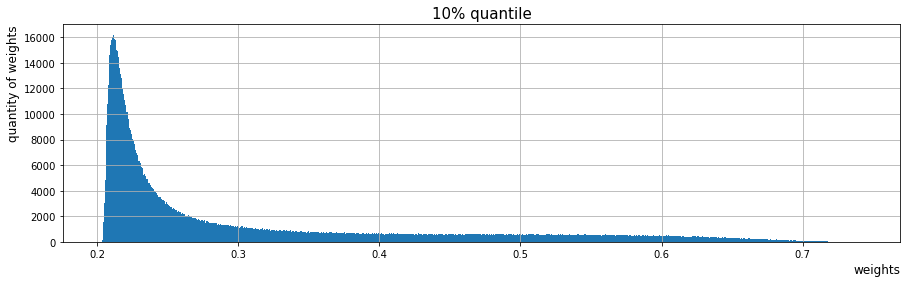

In [20]:
quantiles_show(quantiles[0], '10% quantile')

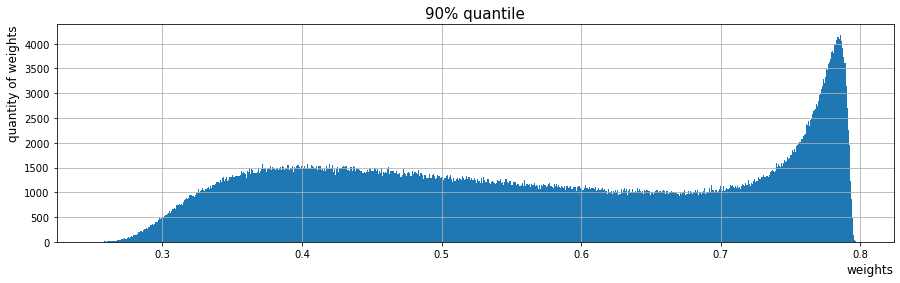

In [21]:
quantiles_show(quantiles[2], '90% quantile')

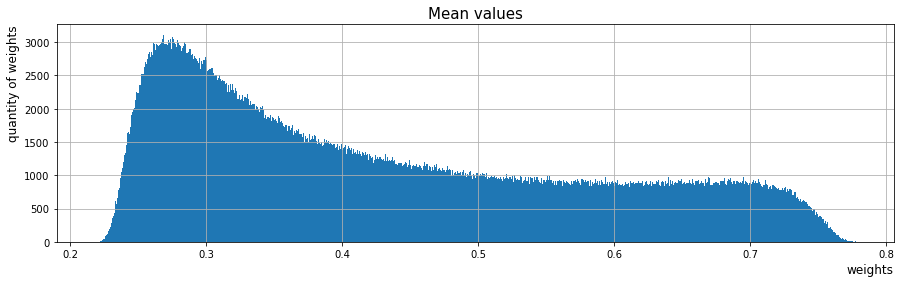

In [22]:
quantiles_show(quantiles[1], 'Mean values')

## Model activation
Weight-limited model

In [23]:
mozafari = MozafariMNIST2018(quantiles=quantiles)

use_cuda = True

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")

if use_cuda:
    mozafari.cuda()   
    
mozafari.eval()

CUDA is available


MozafariMNIST2018(
  (conv1): Convolution()
  (conv2): Convolution()
  (conv3): Convolution()
  (stdp1): STDP(
    (conv_layer): Convolution()
  )
  (stdp2): STDP(
    (conv_layer): Convolution()
  )
  (stdp3): STDP(
    (conv_layer): Convolution()
  )
  (anti_stdp3): STDP(
    (conv_layer): Convolution()
  )
)

## Continuous learning
Training on letters 

### Saving all values of parameters before training

In [24]:
learning_rate_from_scratch = {'stdp1': [mozafari.stdp1.learning_rate[0][0].item(), 
                                        mozafari.stdp1.learning_rate[0][1].item()],
                              'stdp2': [mozafari.stdp2.learning_rate[0][0].item(), 
                                        mozafari.stdp2.learning_rate[0][1].item()],
                              'stdp3': [mozafari.stdp3.learning_rate[0][0].item(), 
                                        mozafari.stdp3.learning_rate[0][1].item()],
                              'anti_stdp3': [mozafari.anti_stdp3.learning_rate[0][0].item(), 
                                             mozafari.anti_stdp3.learning_rate[0][1].item()]
                             }

### Installation of SNN trained on 24,000 images of digits

In [25]:
# file "saved_24000_digits.net" is the result of the file "Mozafari_24000_digits.ipynb"
mozafari.load_state_dict(torch.load("saved_24000_digits.net"))

<All keys matched successfully>

### Training the first layer

In [26]:
mozafari.load_state_dict(torch.load("saved_letters_after_digits_freezed_boundaries_l1.net"))

<All keys matched successfully>

run the cell below to train the first layer

### Training the second layer 

In [27]:
mozafari.load_state_dict(torch.load("saved_letters_after_digits_freezed_boundaries_l2.net"))

<All keys matched successfully>

run the cell below to train the second layer

### Training the third layer 

#### freezing the weights of the 3rd layer within the boundaries of D10 (10%) and D90 (90%) obtained after training the initial model on digits

In [28]:
# Moving learning_rates 

for i in range(len(mozafari.stdp3.learning_rate)):
                    mozafari.stdp3.learning_rate[i][0].fill_(learning_rate_from_scratch['stdp3'][0])
                    mozafari.stdp3.learning_rate[i][1].fill_(learning_rate_from_scratch['stdp3'][1])
                    mozafari.anti_stdp3.learning_rate[i][0].fill_(learning_rate_from_scratch['anti_stdp3'][0])
                    mozafari.anti_stdp3.learning_rate[i][1].fill_(learning_rate_from_scratch['anti_stdp3'][1])

In [29]:
# initial adaptive learning rates

apr = mozafari.stdp3.learning_rate[0][0].item()
anr = mozafari.stdp3.learning_rate[0][1].item()
app = mozafari.anti_stdp3.learning_rate[0][1].item()
anp = mozafari.anti_stdp3.learning_rate[0][0].item()
               
parametr_set = pd.DataFrame(columns=['epoch', 'train', 'test', 'test_previous'])

--------------------------------------------------
Epoch #:  0
0 images
20000 images


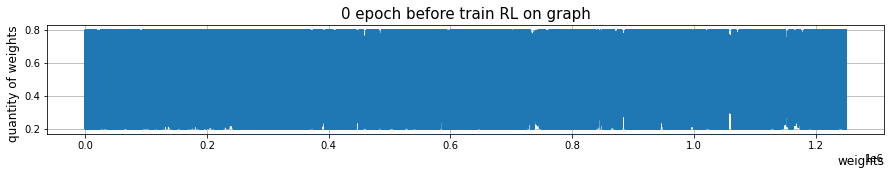

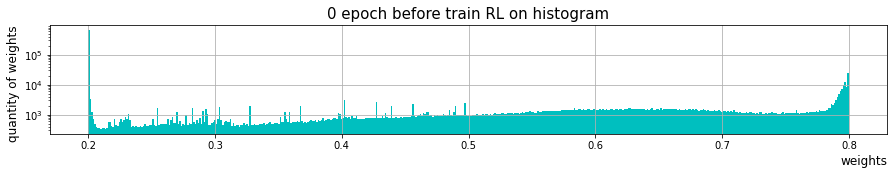

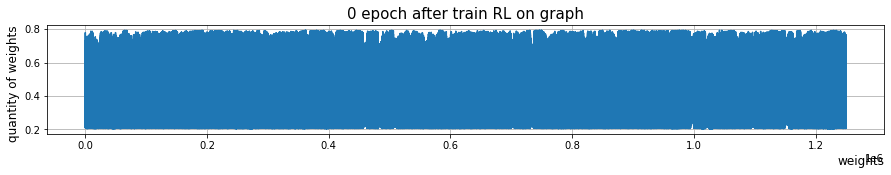

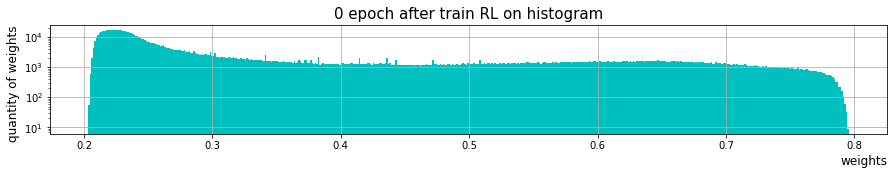

Current Train: 48.69%
Current Test: 58.58%
Current Test Previous: 82.10%
Operational time of epoch #0: 2 min 13 sec
--------------------------------------------------
Epoch #:  1
40000 images


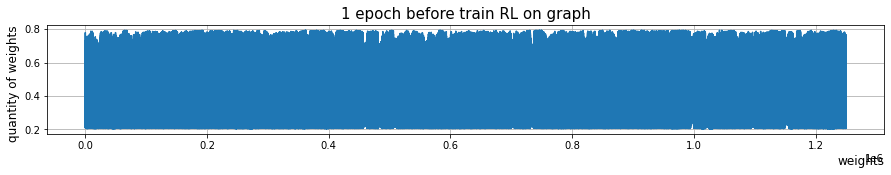

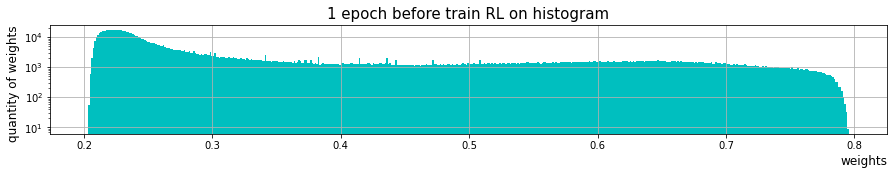

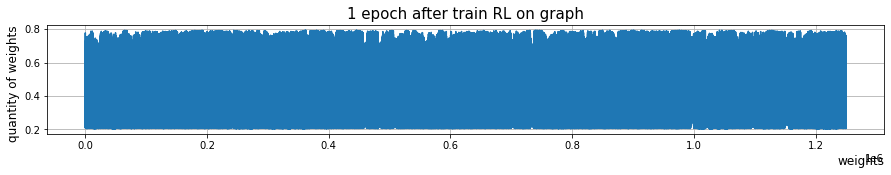

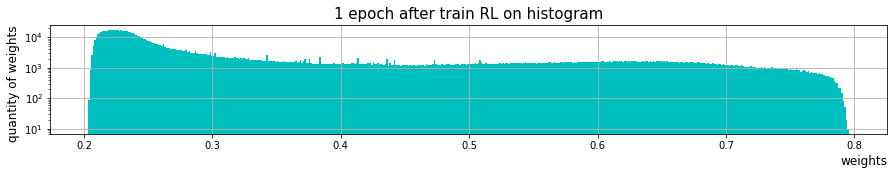

Current Train: 59.63%
Current Test: 59.27%
60000 images
Current Test Previous: 80.90%
Operational time of epoch #1: 2 min 14 sec
--------------------------------------------------
Epoch #:  2
80000 images


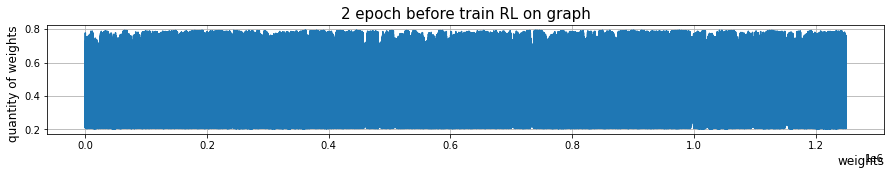

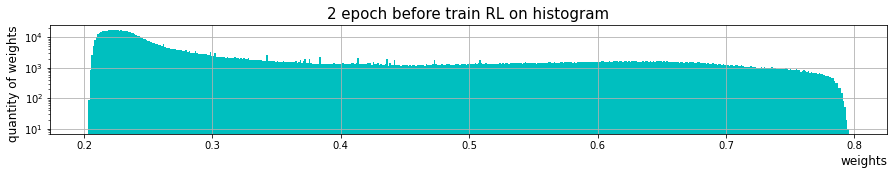

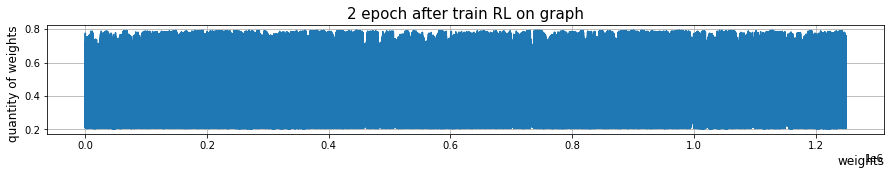

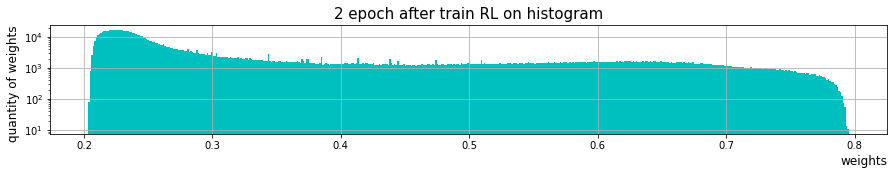

Current Train: 61.92%
Current Test: 62.22%
Current Test Previous: 82.30%
Operational time of epoch #2: 2 min 14 sec
--------------------------------------------------
Epoch #:  3
100000 images


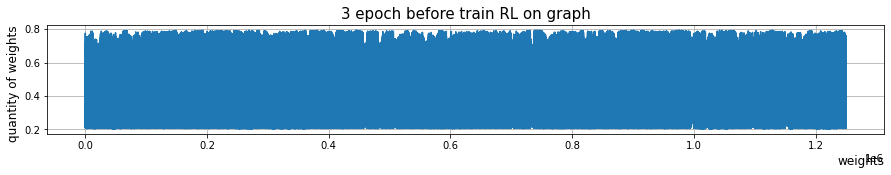

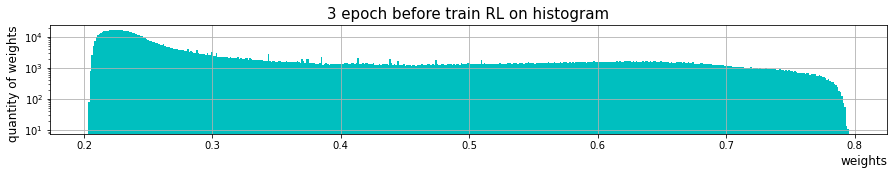

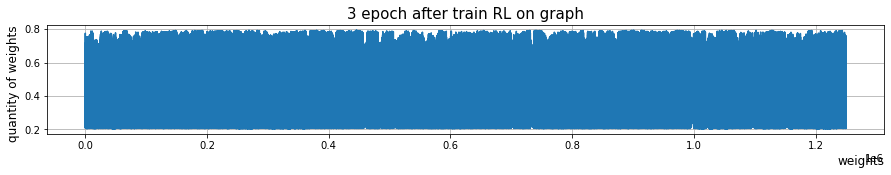

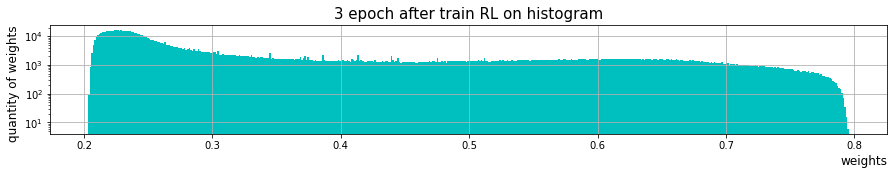

Current Train: 63.86%
120000 images
Current Test: 63.68%
Current Test Previous: 82.33%
Operational time of epoch #3: 2 min 14 sec
--------------------------------------------------
Epoch #:  4
140000 images


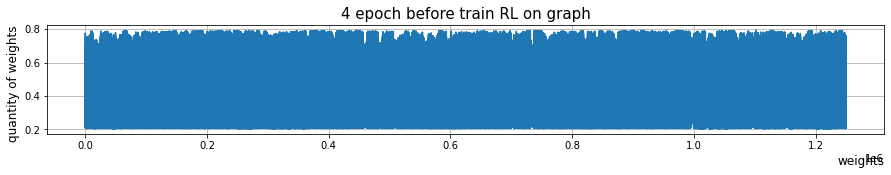

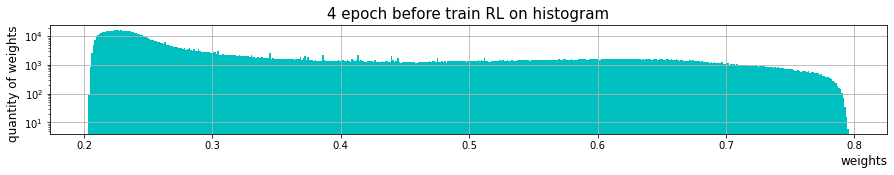

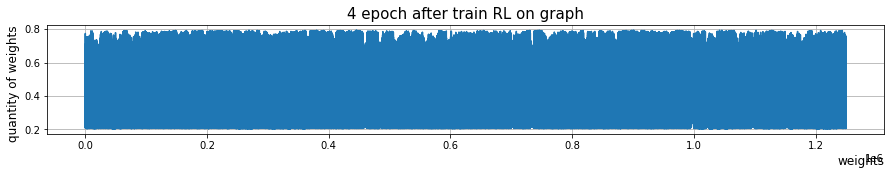

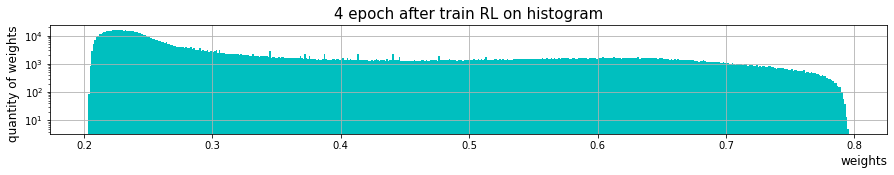

Current Train: 65.38%
Current Test: 64.85%
Current Test Previous: 82.12%
Operational time of epoch #4: 2 min 14 sec
--------------------------------------------------
Epoch #:  5
160000 images
180000 images


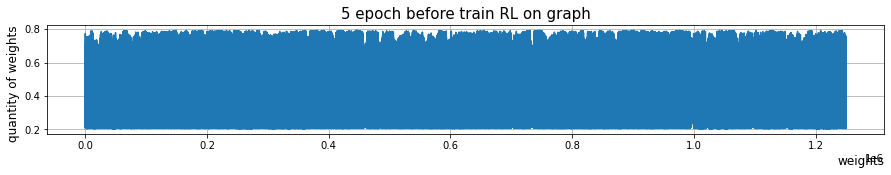

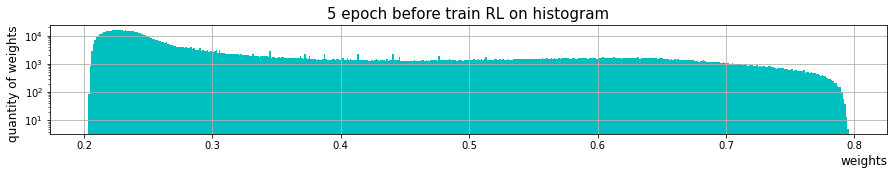

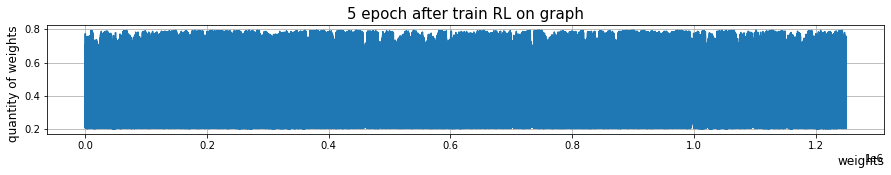

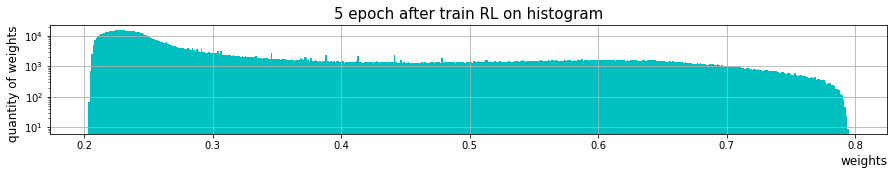

Current Train: 66.74%
Current Test: 65.97%
Current Test Previous: 81.97%
Operational time of epoch #5: 2 min 14 sec
--------------------------------------------------
Epoch #:  6
200000 images


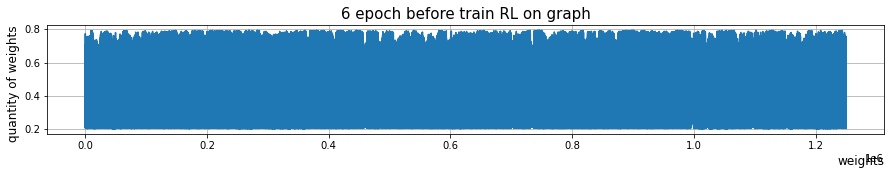

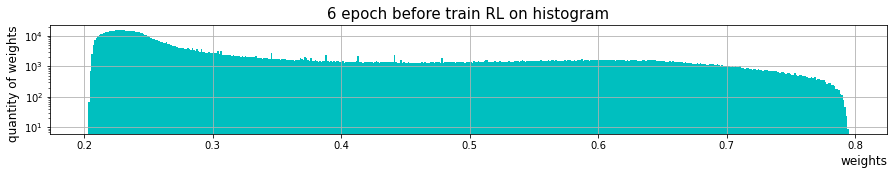

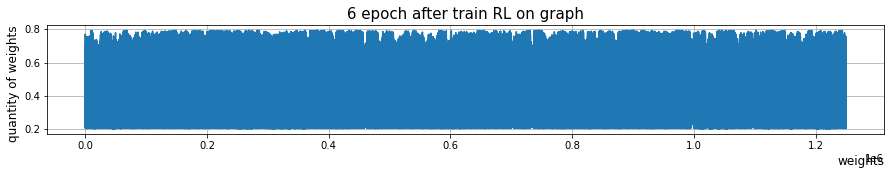

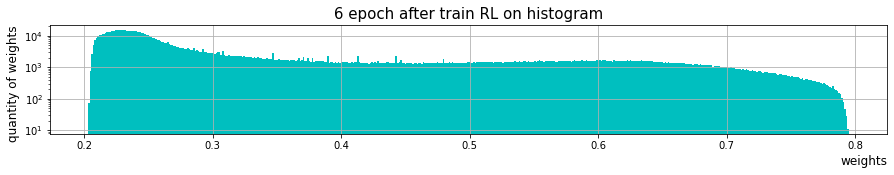

Current Train: 68.04%
Current Test: 67.25%
220000 images
Current Test Previous: 81.83%
Operational time of epoch #6: 2 min 14 sec
--------------------------------------------------
Epoch #:  7
240000 images


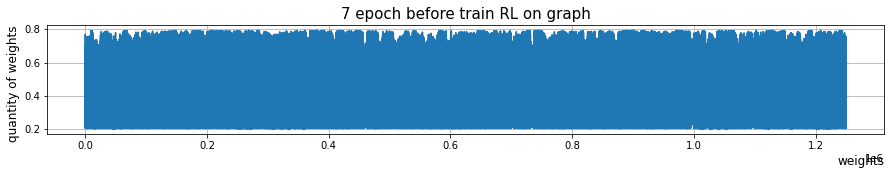

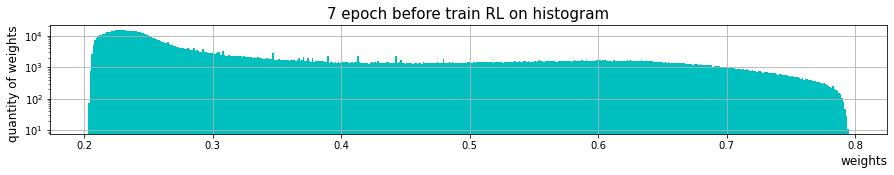

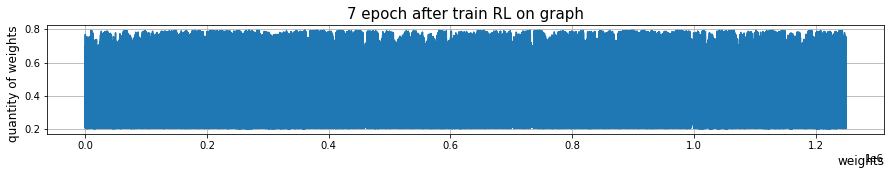

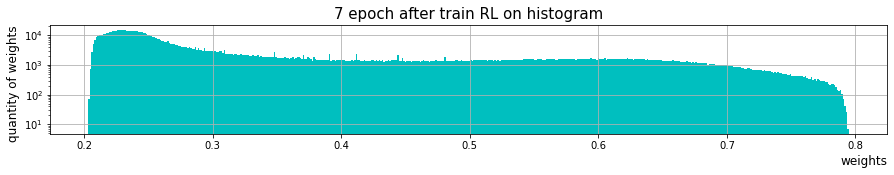

Current Train: 69.21%
Current Test: 68.10%
Current Test Previous: 82.00%
Operational time of epoch #7: 2 min 14 sec
--------------------------------------------------
Epoch #:  8
260000 images


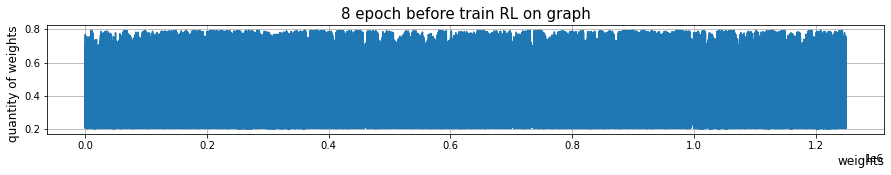

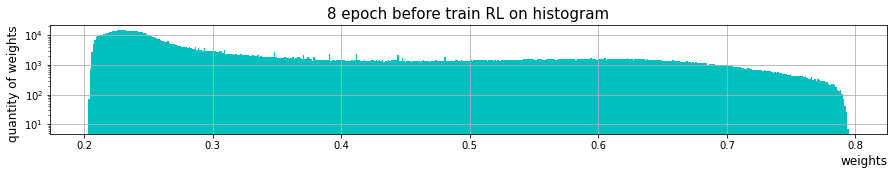

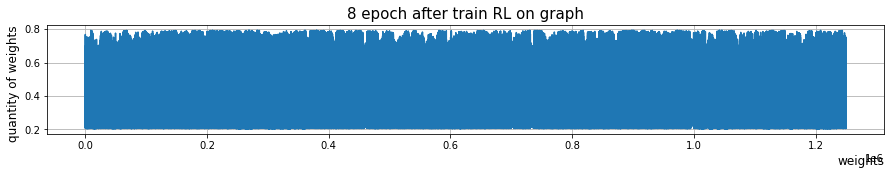

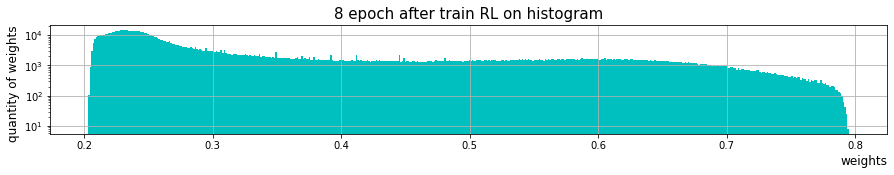

Current Train: 70.22%
280000 images
Current Test: 69.03%
Current Test Previous: 82.20%
Operational time of epoch #8: 2 min 14 sec
--------------------------------------------------
Epoch #:  9
300000 images


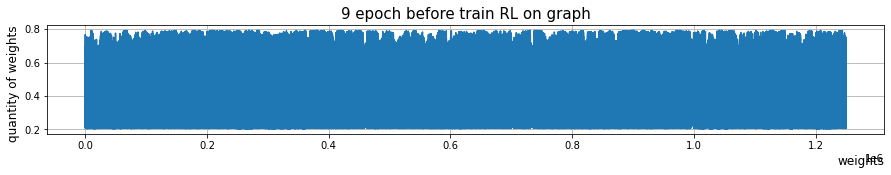

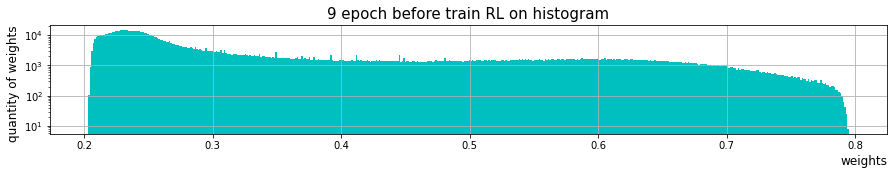

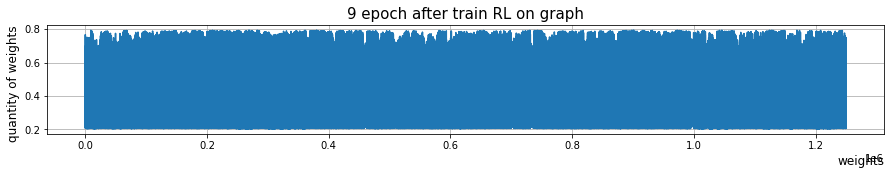

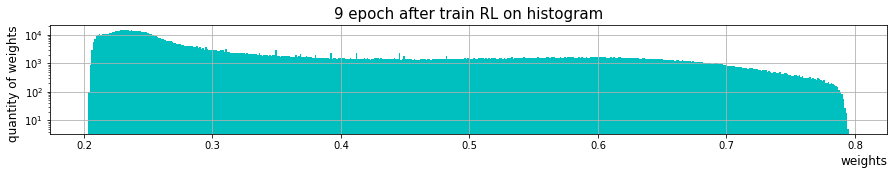

Current Train: 71.25%
Current Test: 69.67%
Current Test Previous: 82.33%
Operational time of epoch #9: 2 min 14 sec
--------------------------------------------------
Epoch #:  10
320000 images
340000 images


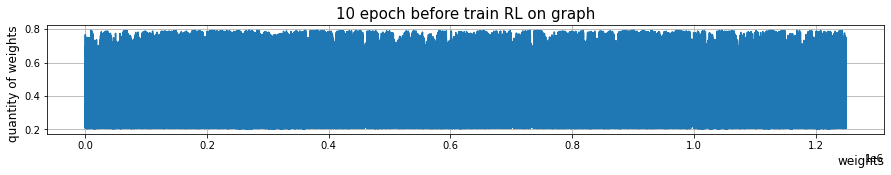

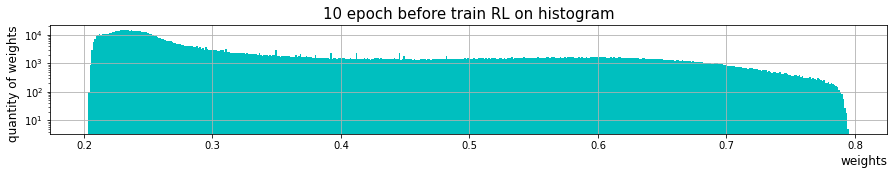

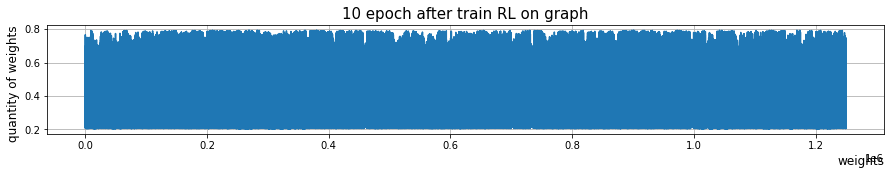

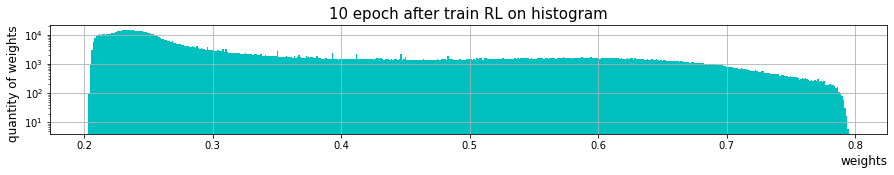

Current Train: 72.29%
Current Test: 71.15%
Current Test Previous: 82.70%
Operational time of epoch #10: 2 min 15 sec
--------------------------------------------------
Epoch #:  11
360000 images


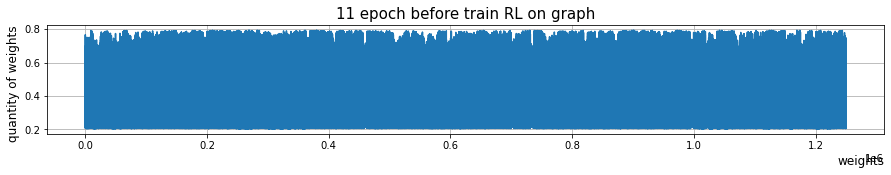

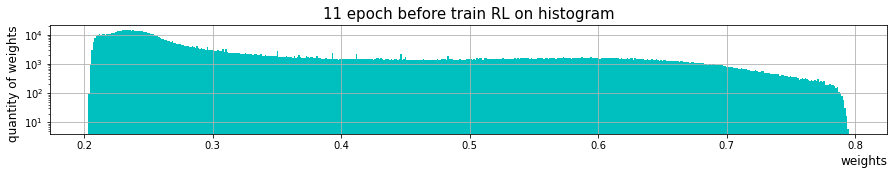

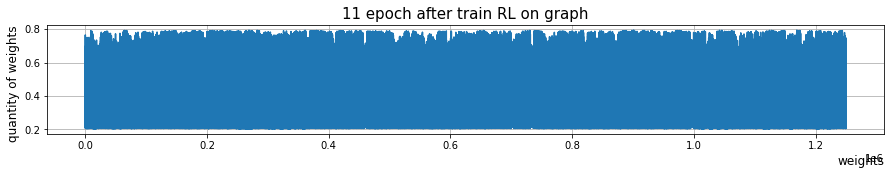

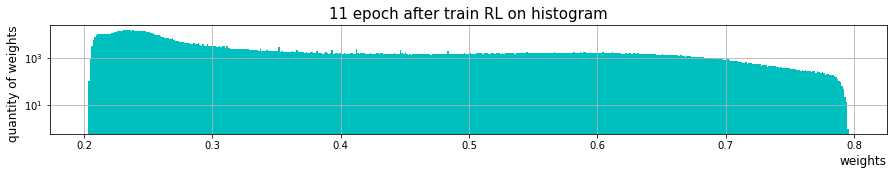

Current Train: 73.36%
Current Test: 71.83%
380000 images
Current Test Previous: 82.88%
Operational time of epoch #11: 2 min 15 sec
--------------------------------------------------
Epoch #:  12
400000 images


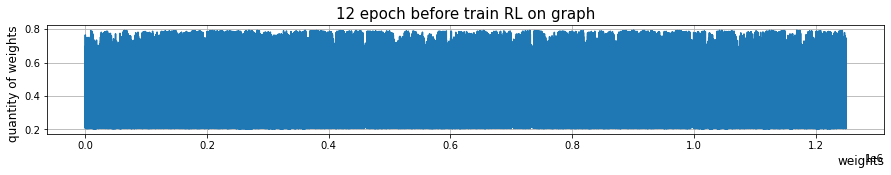

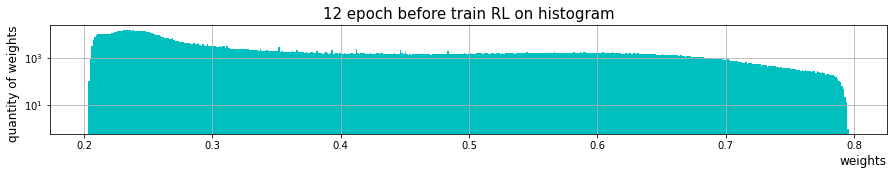

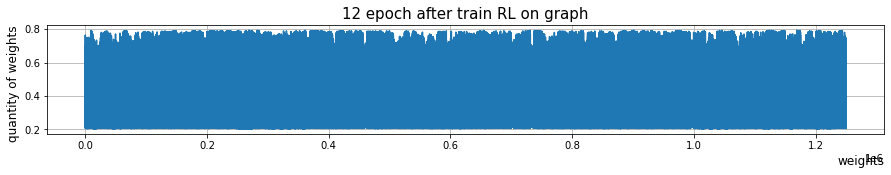

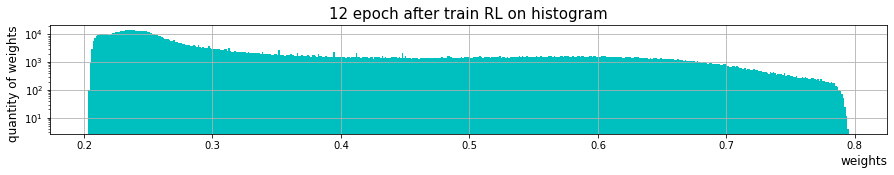

Current Train: 73.94%
Current Test: 72.12%
Current Test Previous: 82.90%
Operational time of epoch #12: 2 min 15 sec
--------------------------------------------------
Epoch #:  13
420000 images


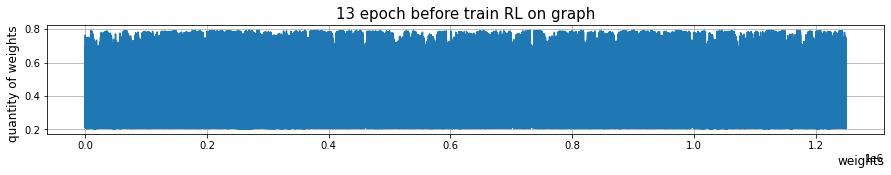

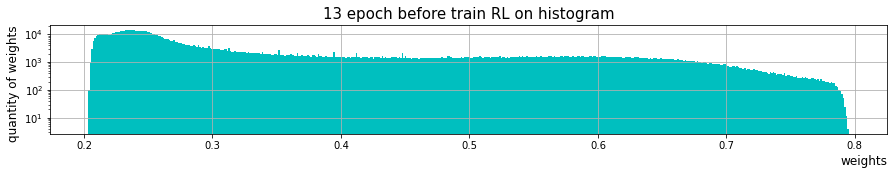

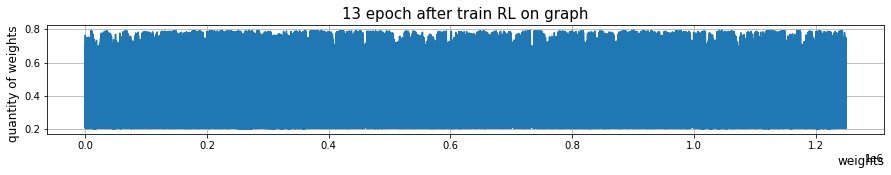

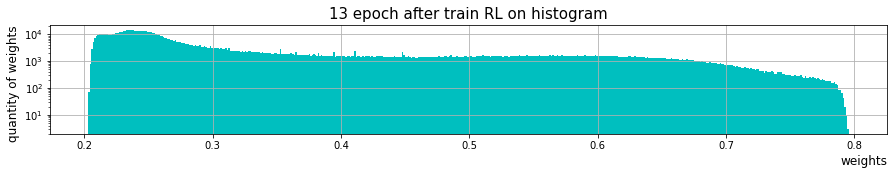

Current Train: 74.39%
440000 images
Current Test: 72.30%
Current Test Previous: 82.65%
Operational time of epoch #13: 2 min 14 sec
--------------------------------------------------
Epoch #:  14
460000 images


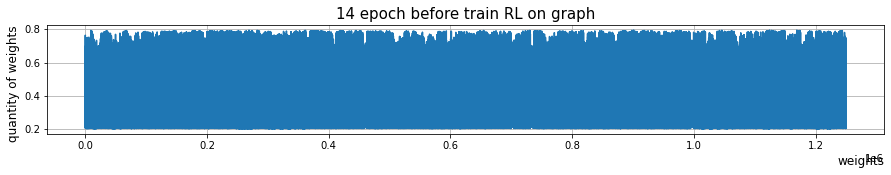

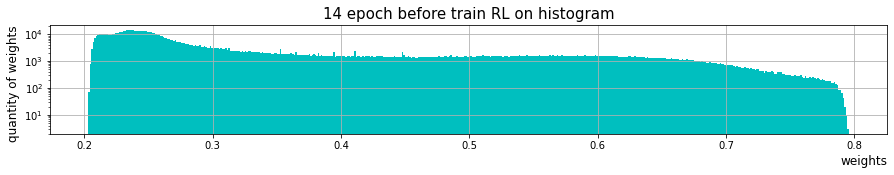

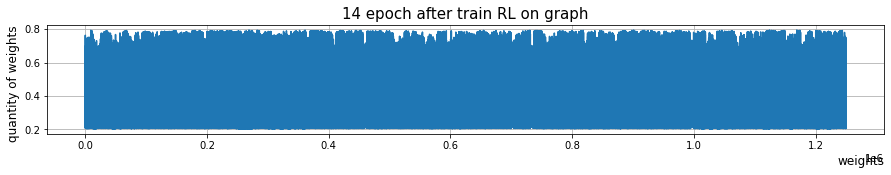

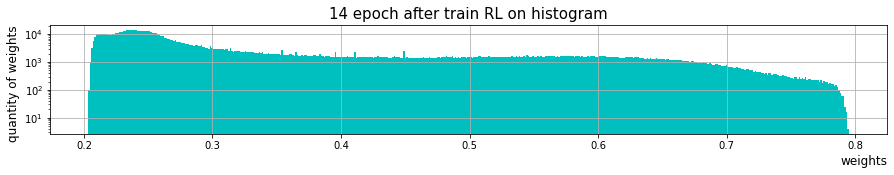

Current Train: 74.86%
Current Test: 72.95%
Current Test Previous: 82.88%
Operational time of epoch #14: 2 min 14 sec
--------------------------------------------------
Epoch #:  15
480000 images
500000 images


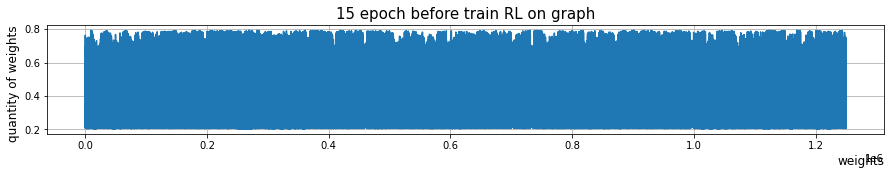

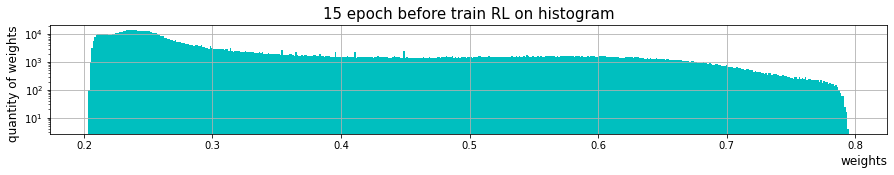

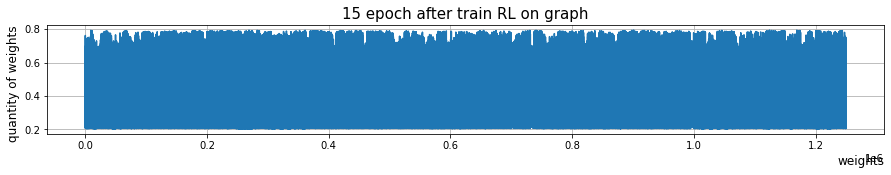

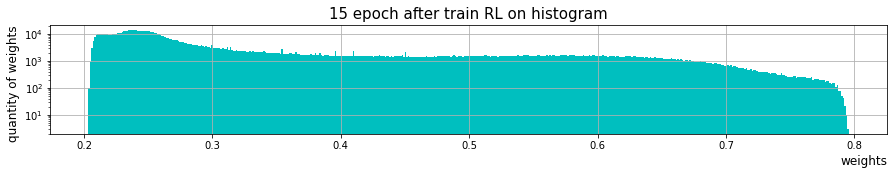

Current Train: 75.19%
Current Test: 73.22%
Current Test Previous: 82.70%
Operational time of epoch #15: 2 min 14 sec
--------------------------------------------------
Epoch #:  16
520000 images


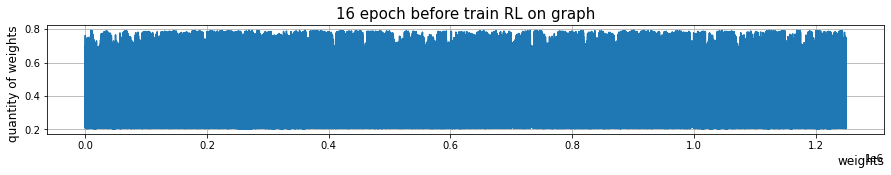

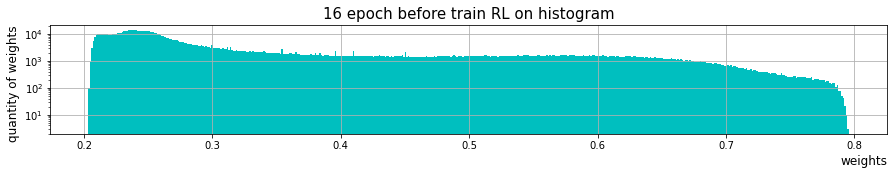

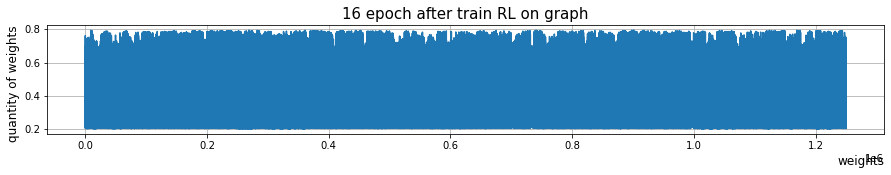

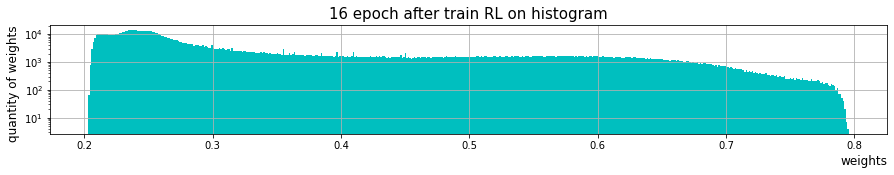

Current Train: 75.52%
Current Test: 73.15%
540000 images
Current Test Previous: 82.85%
Operational time of epoch #16: 2 min 14 sec
--------------------------------------------------
Epoch #:  17
560000 images


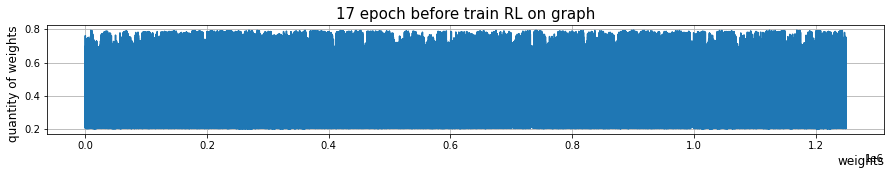

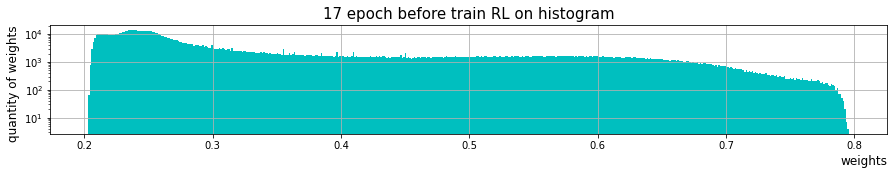

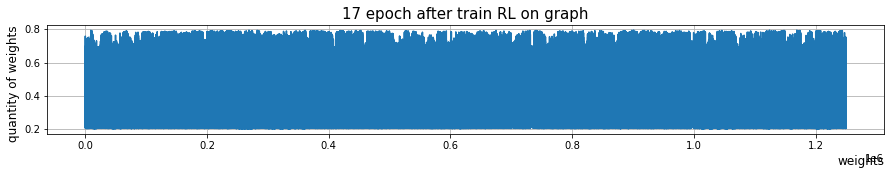

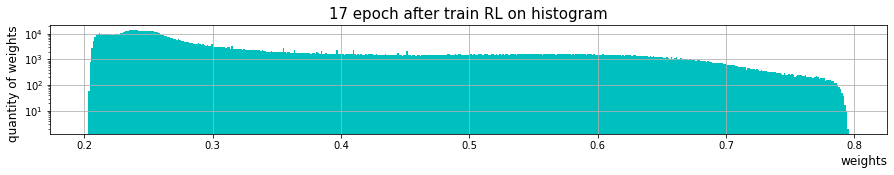

Current Train: 75.83%
Current Test: 73.62%
Current Test Previous: 82.65%
Operational time of epoch #17: 2 min 14 sec
--------------------------------------------------
Epoch #:  18
580000 images


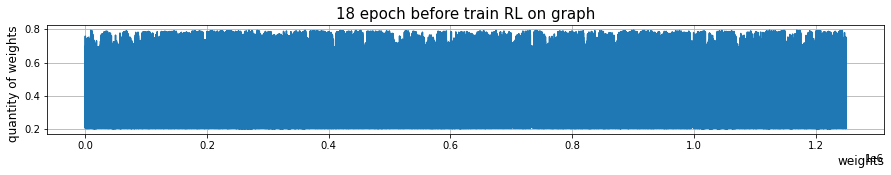

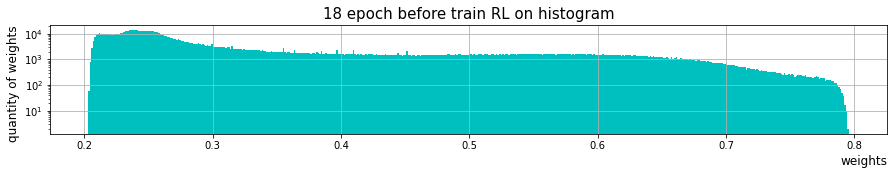

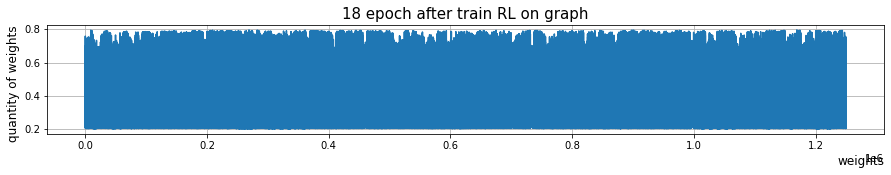

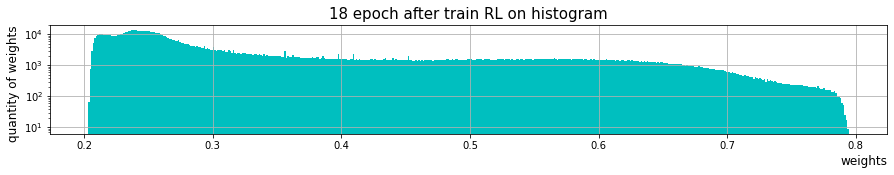

Current Train: 76.10%
600000 images
Current Test: 73.67%
Current Test Previous: 82.83%
Operational time of epoch #18: 2 min 15 sec
--------------------------------------------------
Epoch #:  19
620000 images


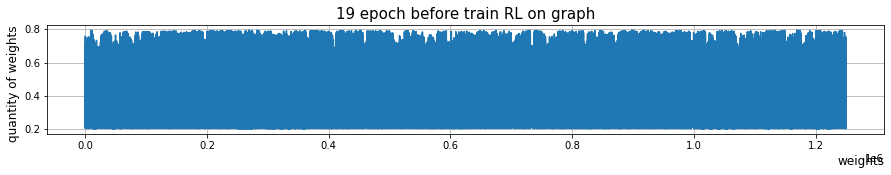

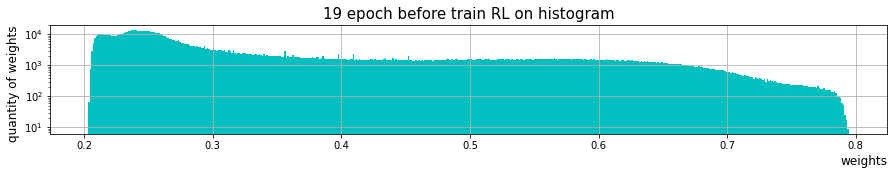

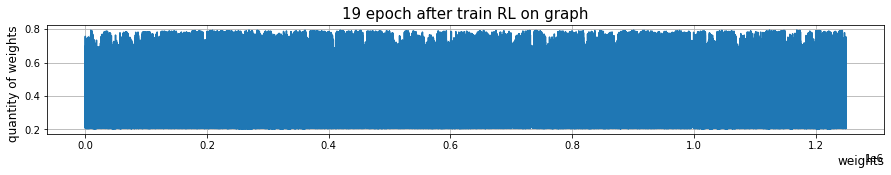

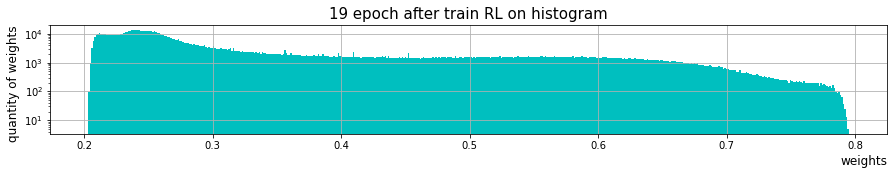

Current Train: 76.37%
Current Test: 73.67%
Current Test Previous: 83.00%
Operational time of epoch #19: 2 min 15 sec
--------------------------------------------------
Epoch #:  20
640000 images
660000 images


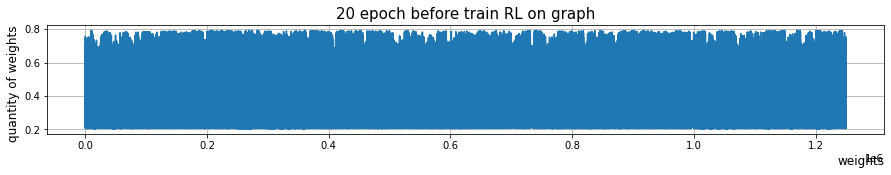

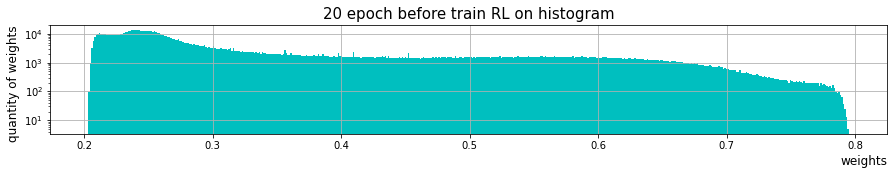

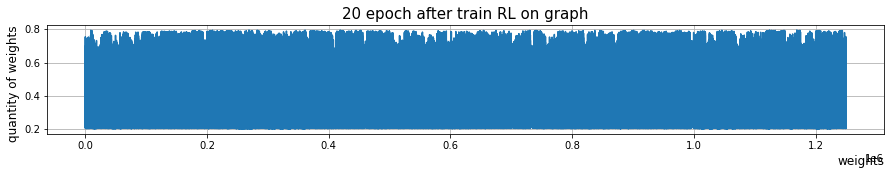

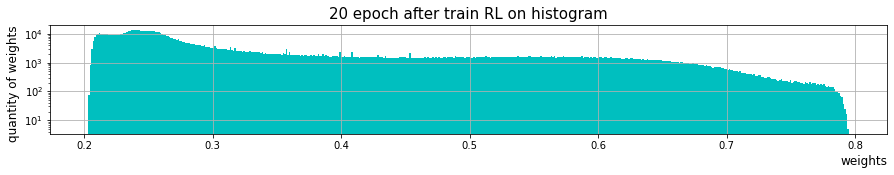

Current Train: 76.54%
Current Test: 74.05%
Current Test Previous: 83.00%
Operational time of epoch #20: 2 min 15 sec
--------------------------------------------------
Epoch #:  21
680000 images


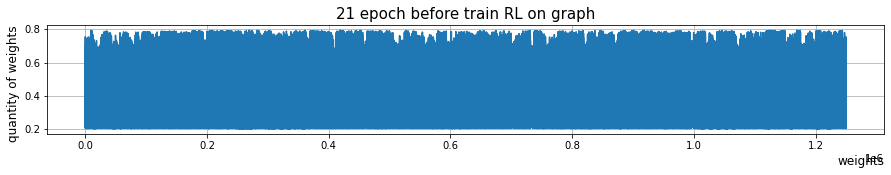

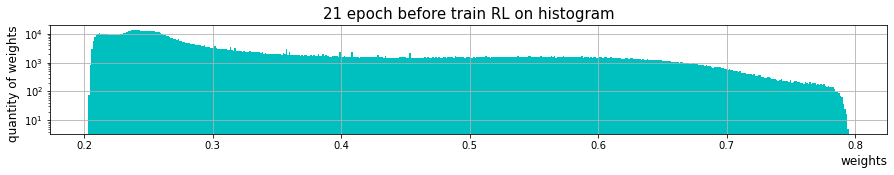

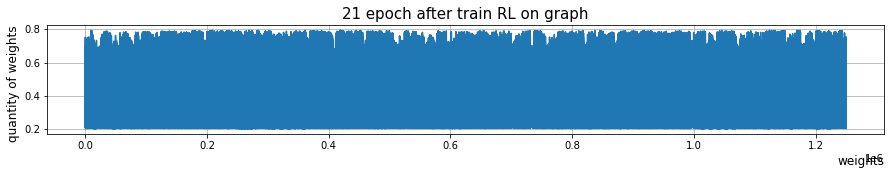

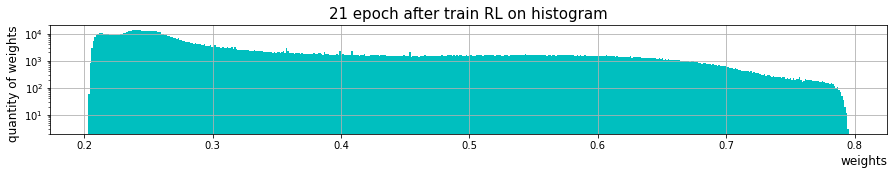

Current Train: 76.78%
Current Test: 74.35%
700000 images
Current Test Previous: 83.05%
Operational time of epoch #21: 2 min 16 sec
--------------------------------------------------
Epoch #:  22
720000 images


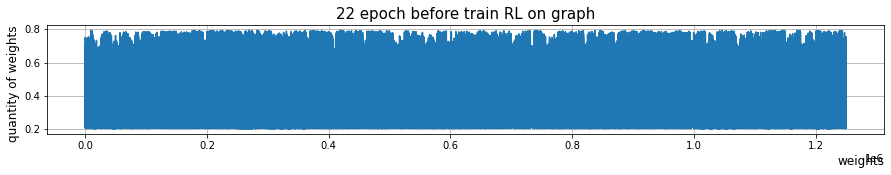

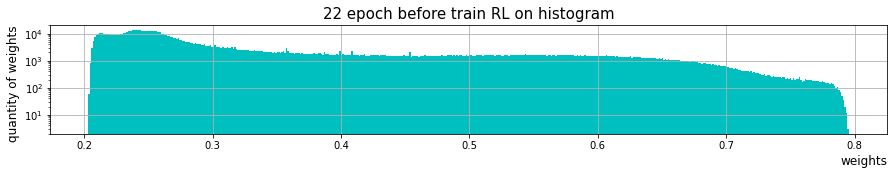

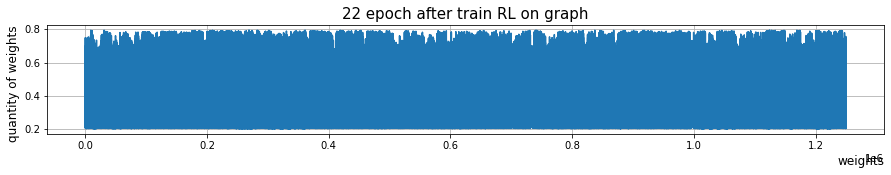

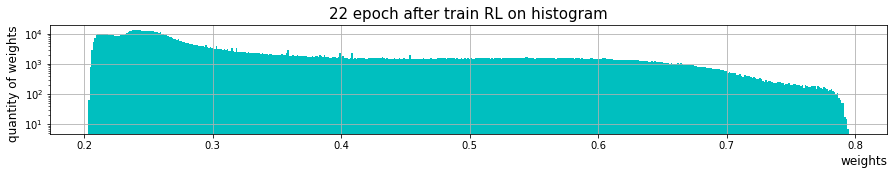

Current Train: 76.95%
Current Test: 74.67%
Current Test Previous: 82.93%
Operational time of epoch #22: 2 min 16 sec
--------------------------------------------------
Epoch #:  23
740000 images


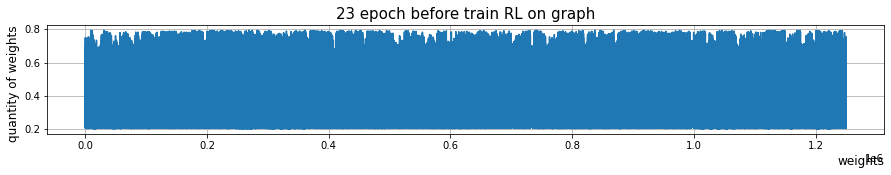

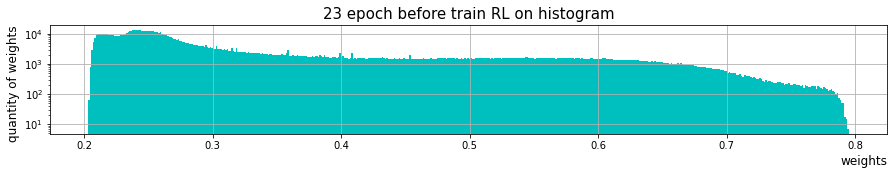

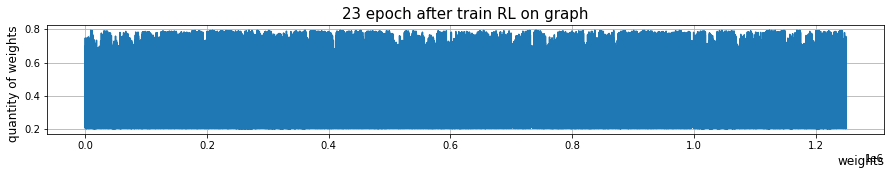

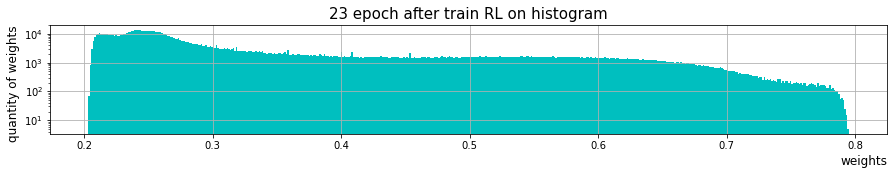

Current Train: 77.58%
760000 images
Current Test: 75.45%
Current Test Previous: 82.67%
Operational time of epoch #23: 2 min 15 sec
--------------------------------------------------
Epoch #:  24
780000 images


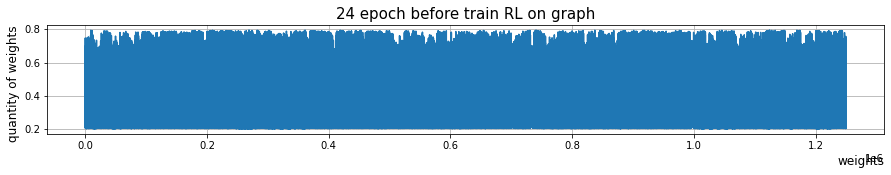

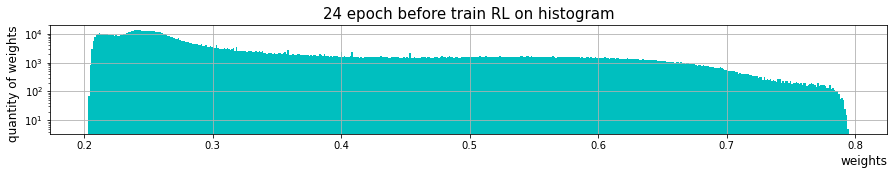

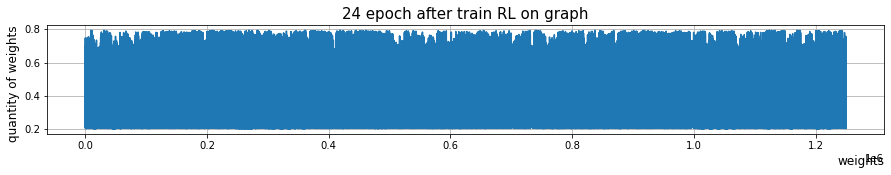

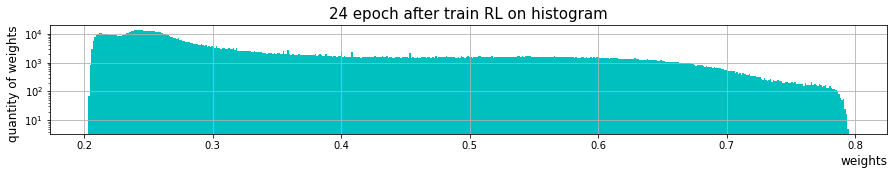

Current Train: 78.83%
Current Test: 76.62%
Current Test Previous: 82.60%
Operational time of epoch #24: 2 min 14 sec
--------------------------------------------------
Epoch #:  25
800000 images
820000 images


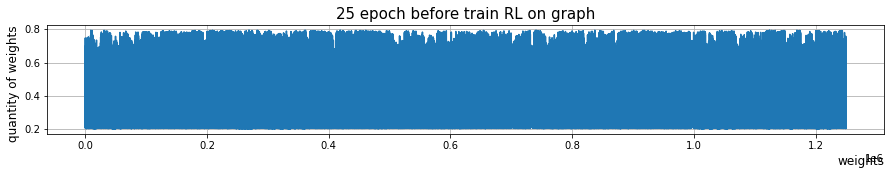

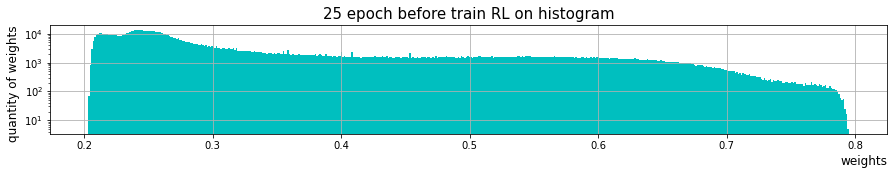

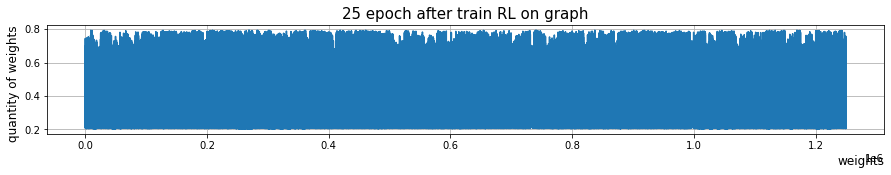

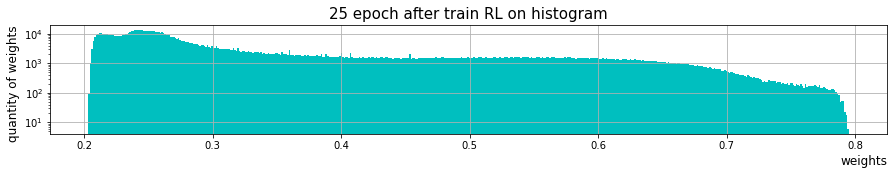

Current Train: 79.10%
Current Test: 76.50%
Current Test Previous: 83.17%
Operational time of epoch #25: 2 min 14 sec
--------------------------------------------------
Epoch #:  26
840000 images


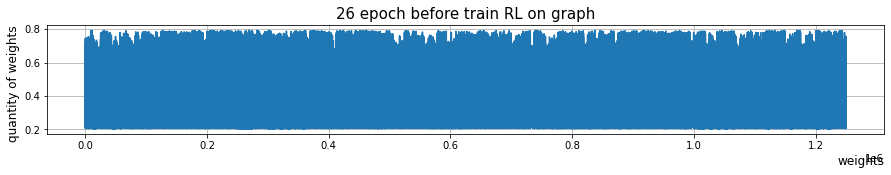

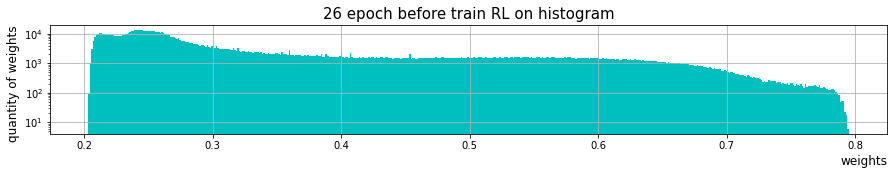

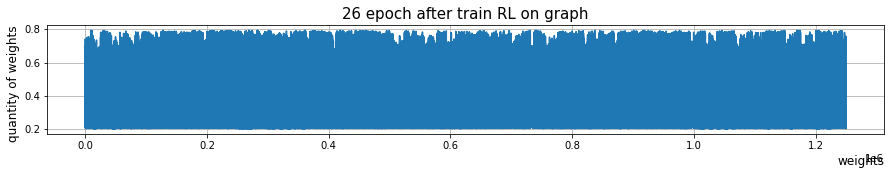

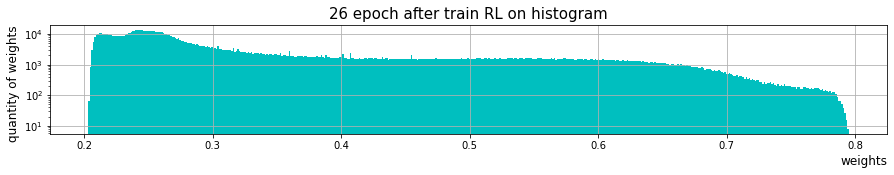

Current Train: 79.30%
Current Test: 76.42%
860000 images
Current Test Previous: 83.35%
Operational time of epoch #26: 2 min 14 sec
--------------------------------------------------
Epoch #:  27
880000 images


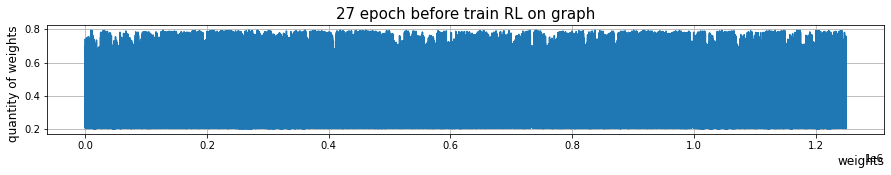

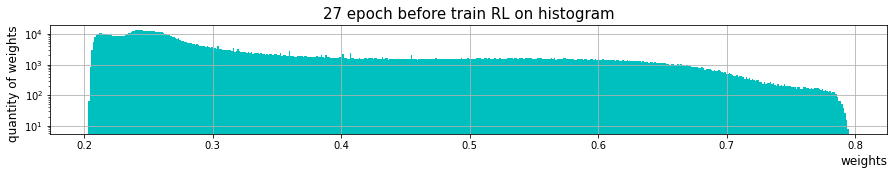

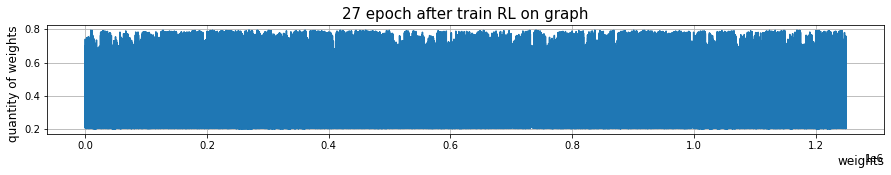

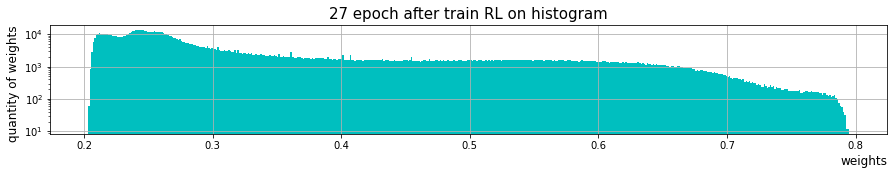

Current Train: 79.45%
Current Test: 76.55%
Current Test Previous: 83.43%
Operational time of epoch #27: 2 min 14 sec
--------------------------------------------------
Epoch #:  28
900000 images


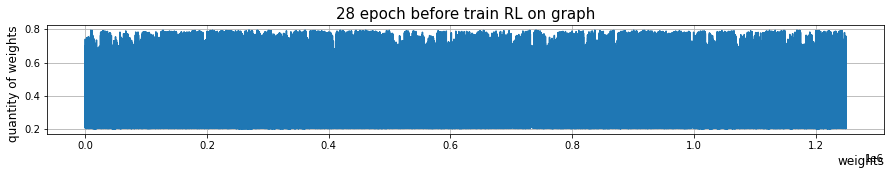

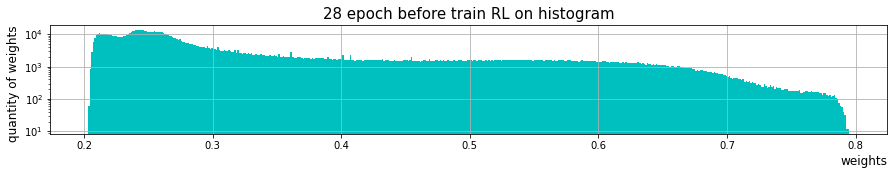

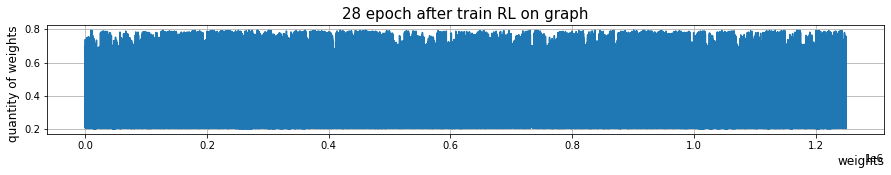

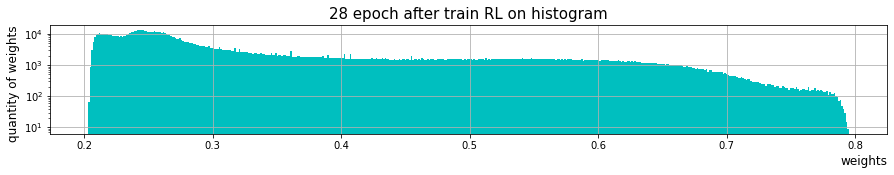

Current Train: 79.51%
920000 images
Current Test: 76.85%
Current Test Previous: 83.55%
Operational time of epoch #28: 2 min 14 sec
--------------------------------------------------
Epoch #:  29
940000 images


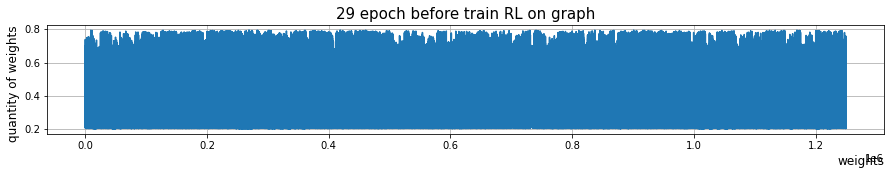

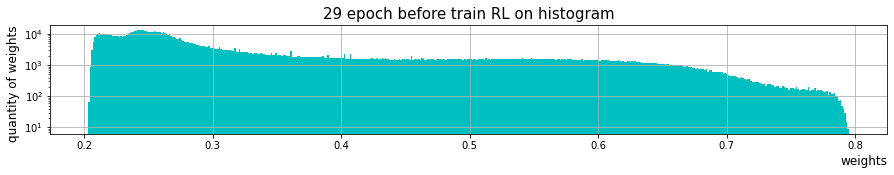

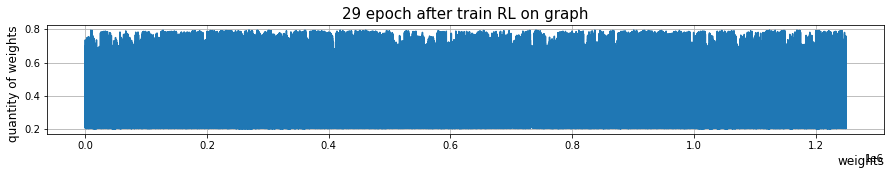

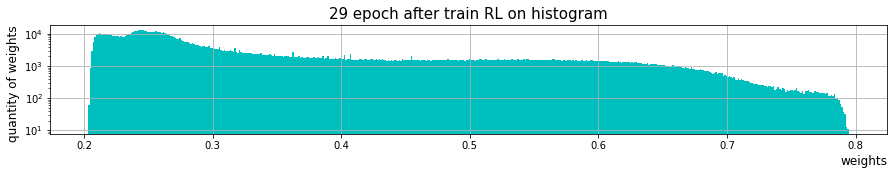

Current Train: 79.70%
Current Test: 77.03%
Current Test Previous: 83.45%
Operational time of epoch #29: 2 min 14 sec
--------------------------------------------------
Epoch #:  30
960000 images
980000 images


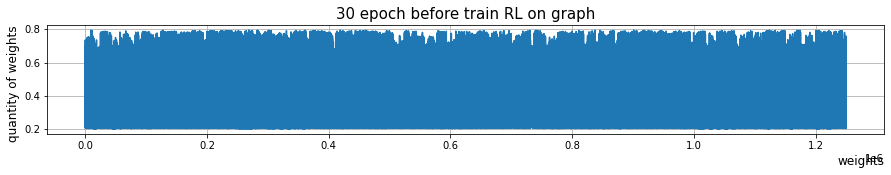

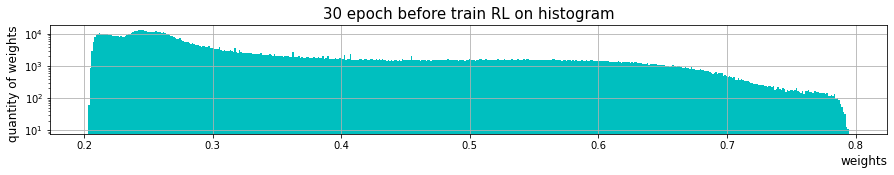

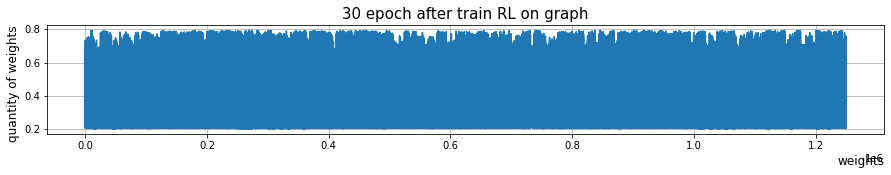

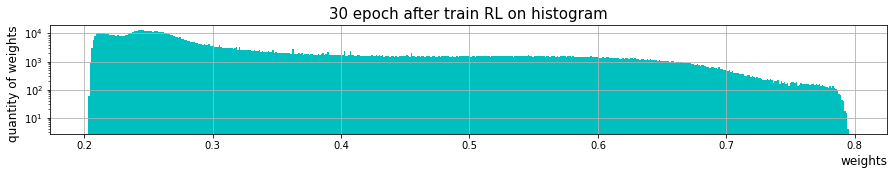

Current Train: 79.74%
Current Test: 76.85%
Current Test Previous: 83.33%
Operational time of epoch #30: 2 min 14 sec
--------------------------------------------------
Epoch #:  31
1000000 images


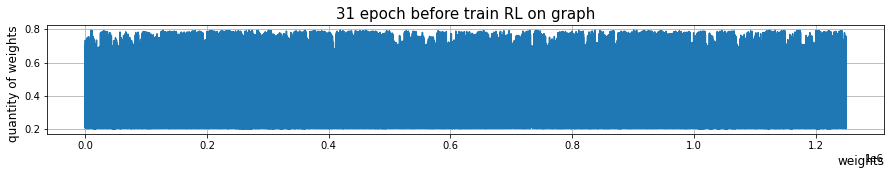

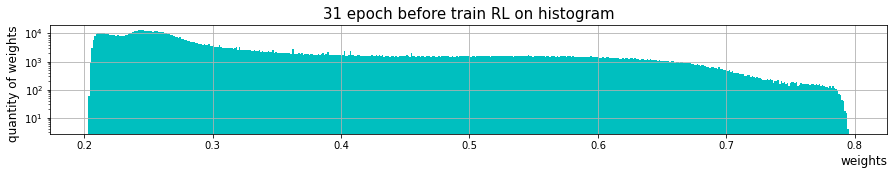

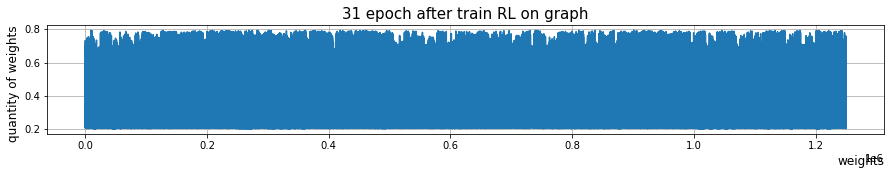

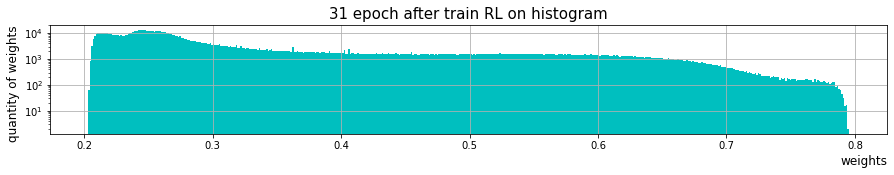

Current Train: 79.83%
Current Test: 77.05%
1020000 images
Current Test Previous: 83.45%
Operational time of epoch #31: 2 min 14 sec
--------------------------------------------------
Epoch #:  32
1040000 images


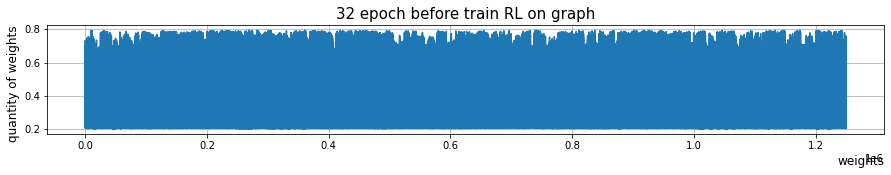

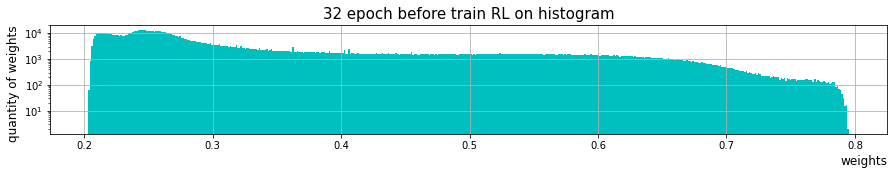

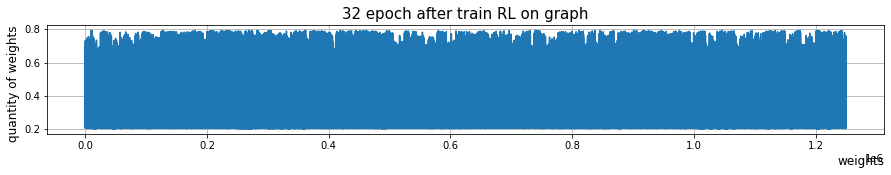

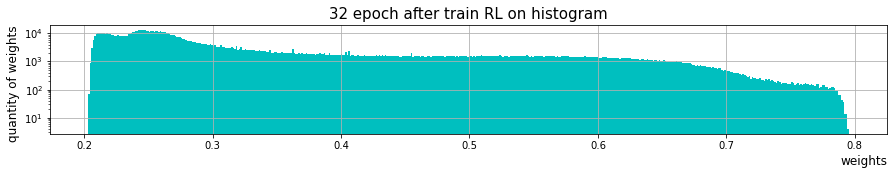

Current Train: 79.92%
Current Test: 77.10%
Current Test Previous: 83.28%
Operational time of epoch #32: 2 min 14 sec
--------------------------------------------------
Epoch #:  33
1060000 images


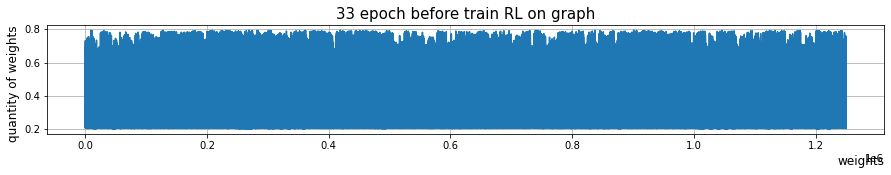

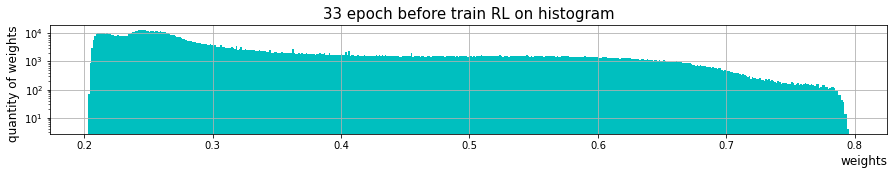

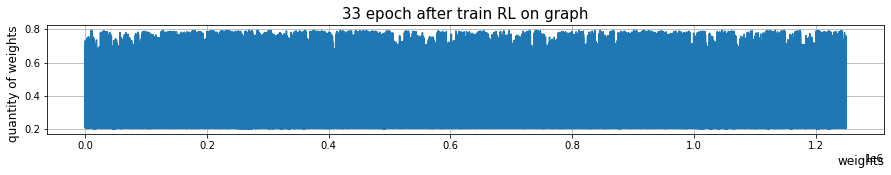

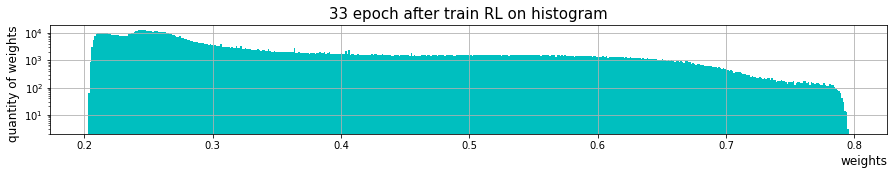

Current Train: 80.14%
1080000 images
Current Test: 77.10%
Current Test Previous: 83.28%
Operational time of epoch #33: 2 min 14 sec
--------------------------------------------------
Epoch #:  34
1100000 images


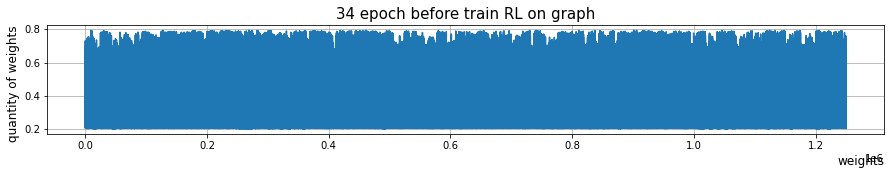

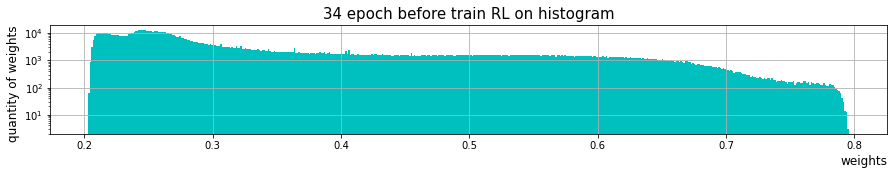

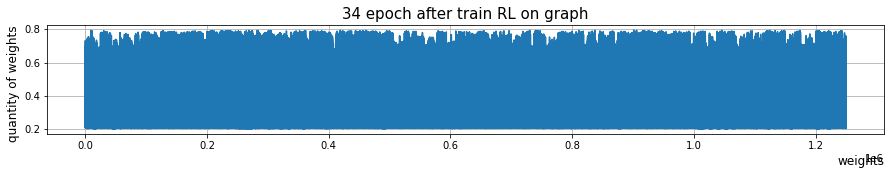

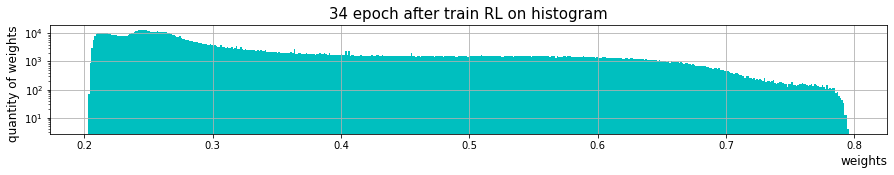

Current Train: 79.98%
Current Test: 76.92%
Current Test Previous: 83.20%
Operational time of epoch #34: 2 min 14 sec
--------------------------------------------------
Epoch #:  35
1120000 images
1140000 images


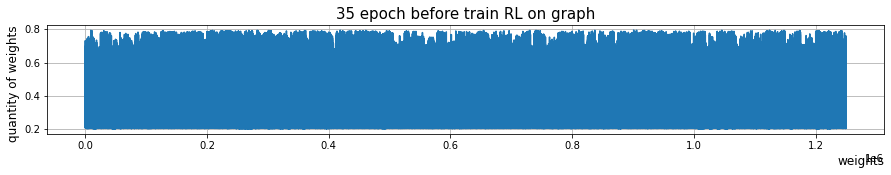

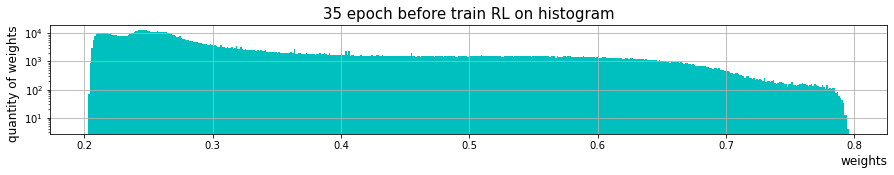

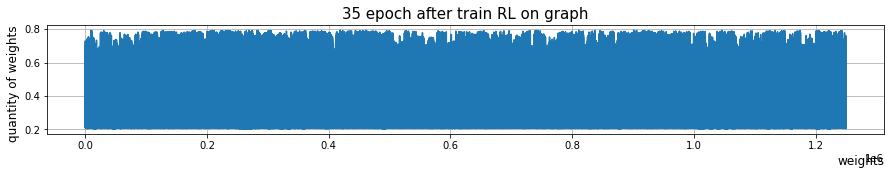

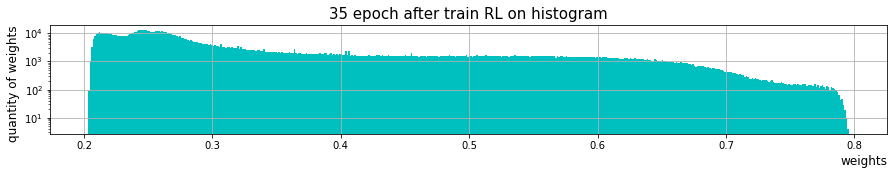

Current Train: 80.00%
Current Test: 76.90%
Current Test Previous: 83.33%
Operational time of epoch #35: 2 min 14 sec
--------------------------------------------------
Epoch #:  36
1160000 images


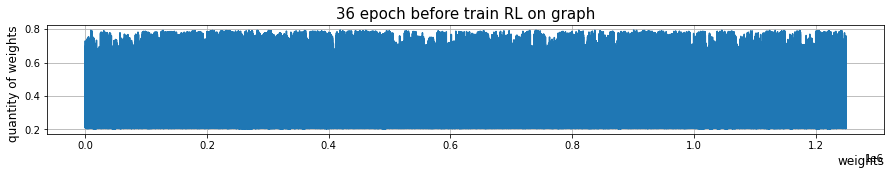

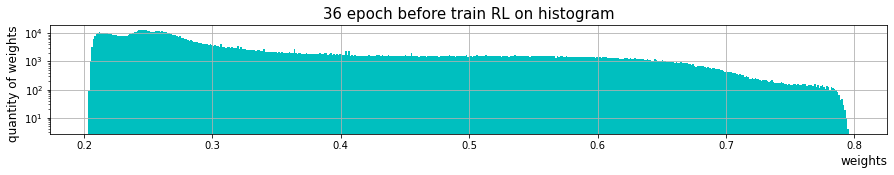

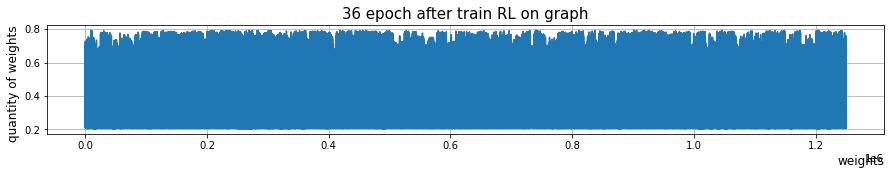

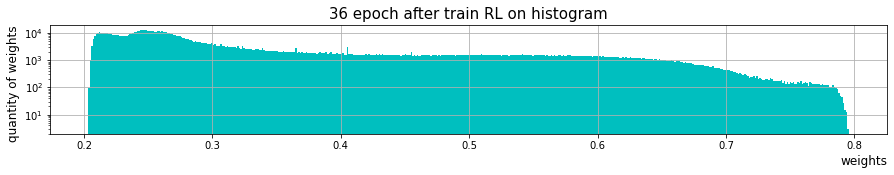

Current Train: 80.06%
Current Test: 77.12%
1180000 images
Current Test Previous: 83.30%
Operational time of epoch #36: 2 min 15 sec
--------------------------------------------------
Epoch #:  37
1200000 images


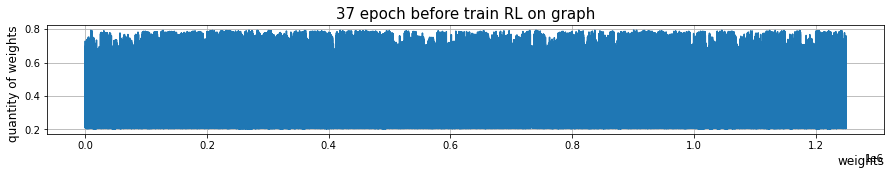

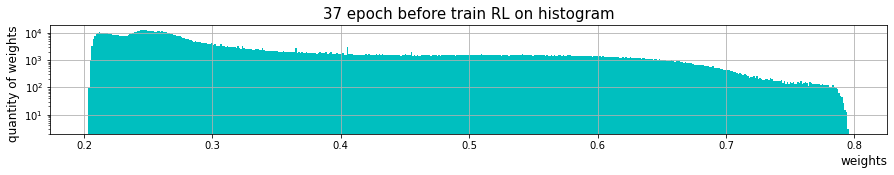

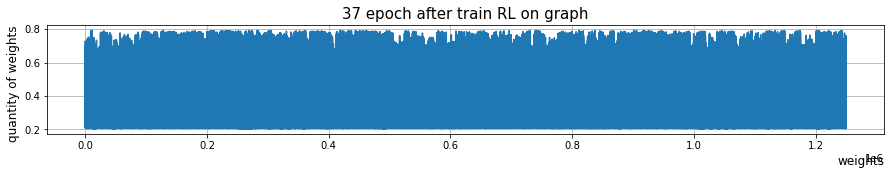

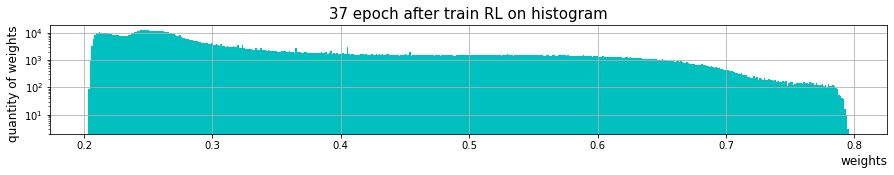

Current Train: 80.13%
Current Test: 77.28%
Current Test Previous: 82.97%
Operational time of epoch #37: 2 min 14 sec
--------------------------------------------------
Epoch #:  38
1220000 images


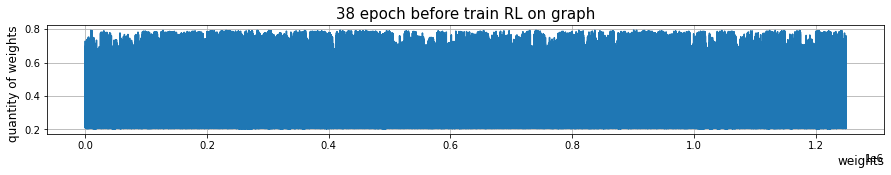

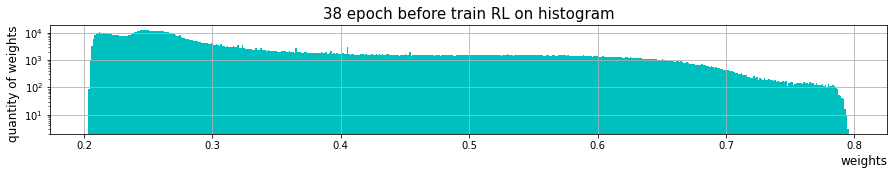

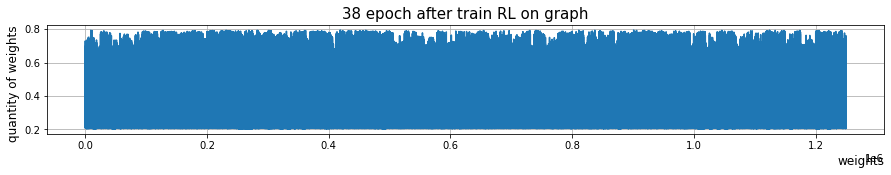

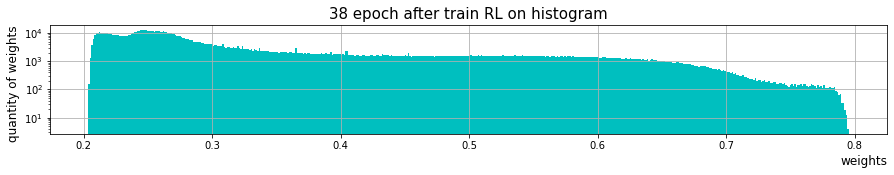

Current Train: 80.19%
1240000 images
Current Test: 77.22%
Current Test Previous: 83.00%
Operational time of epoch #38: 2 min 14 sec
--------------------------------------------------
Epoch #:  39
1260000 images


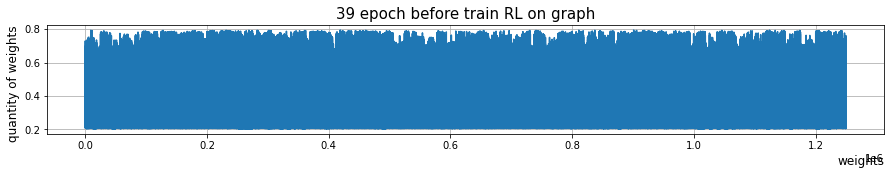

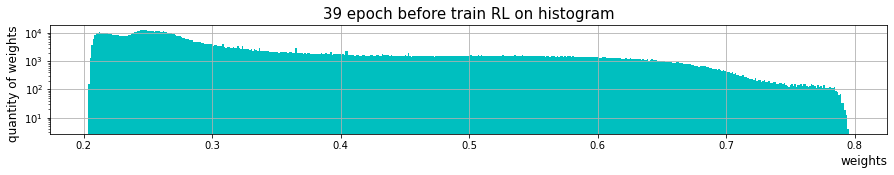

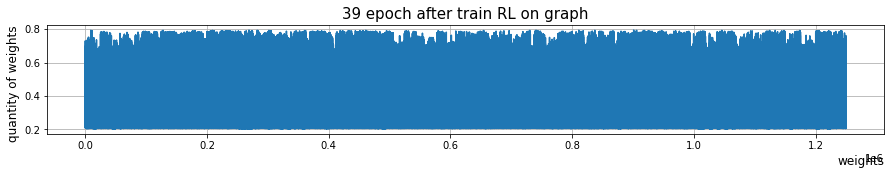

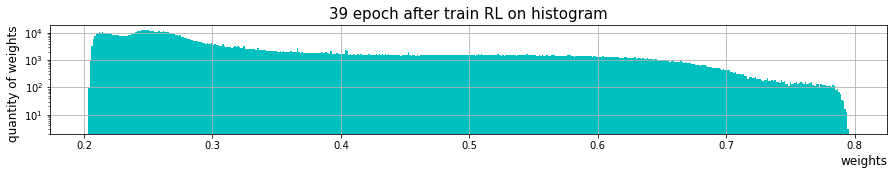

Current Train: 80.10%
Current Test: 77.12%
Current Test Previous: 82.95%
Operational time of epoch #39: 2 min 14 sec
--------------------------------------------------
Epoch #:  40
1280000 images
1300000 images


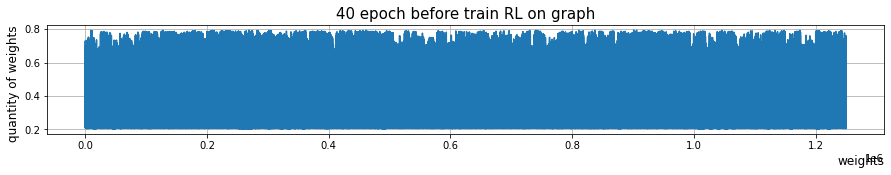

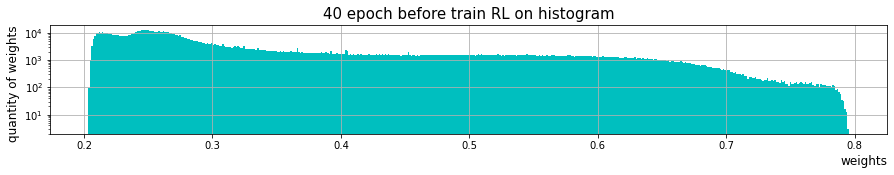

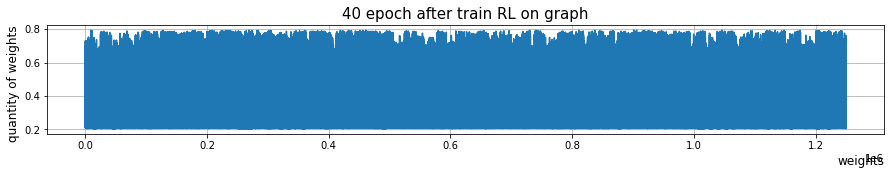

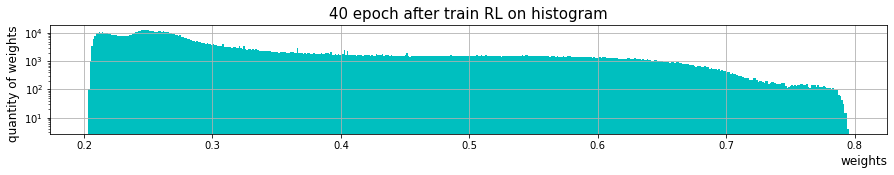

Current Train: 80.31%
Current Test: 77.30%
Current Test Previous: 82.80%
Operational time of epoch #40: 2 min 14 sec
--------------------------------------------------
Epoch #:  41
1320000 images


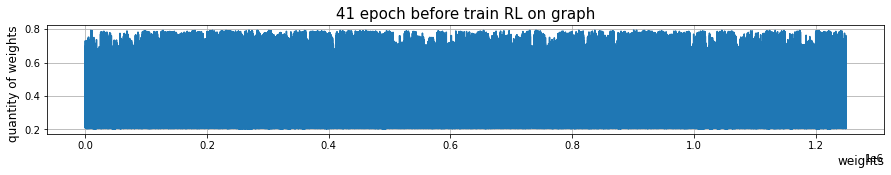

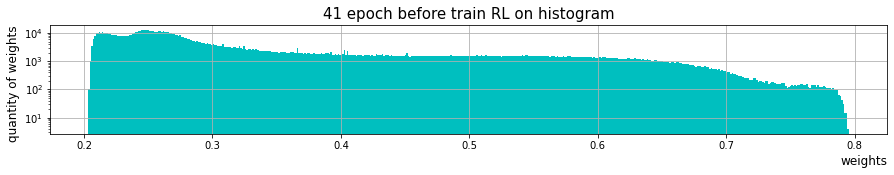

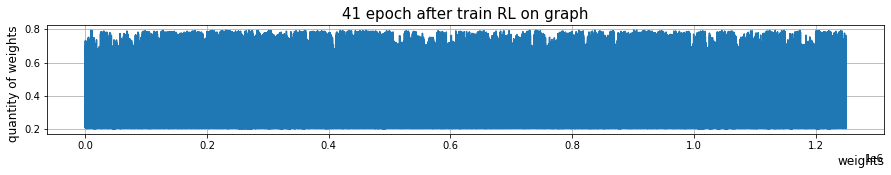

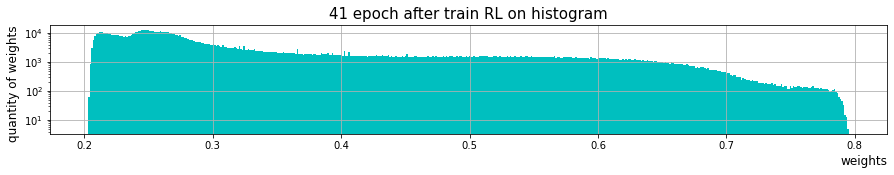

Current Train: 80.22%
Current Test: 77.08%
1340000 images
Current Test Previous: 83.03%
Operational time of epoch #41: 2 min 14 sec
--------------------------------------------------
Epoch #:  42
1360000 images


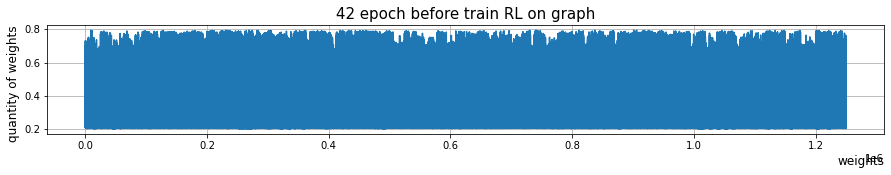

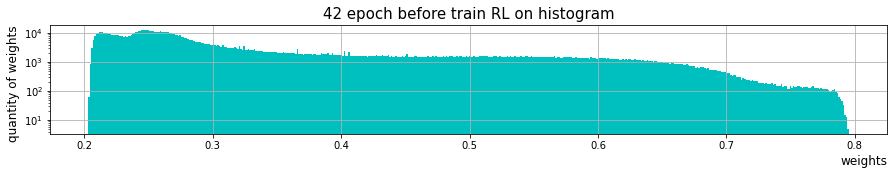

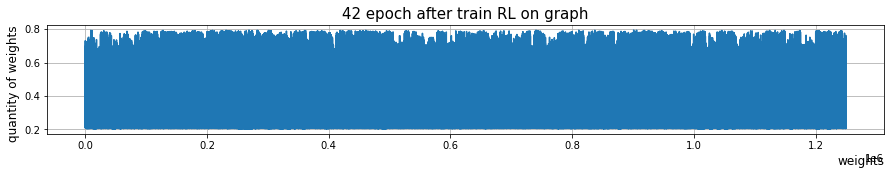

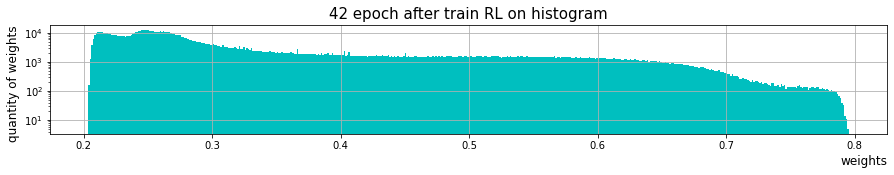

Current Train: 80.27%
Current Test: 76.98%
Current Test Previous: 83.03%
Operational time of epoch #42: 2 min 14 sec
--------------------------------------------------
Epoch #:  43
1380000 images


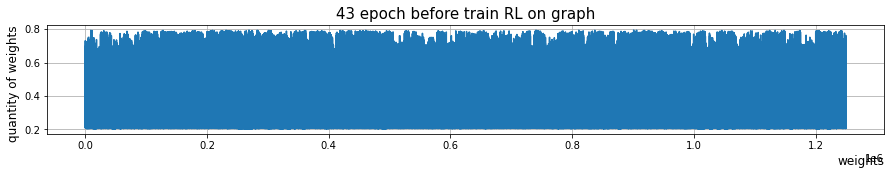

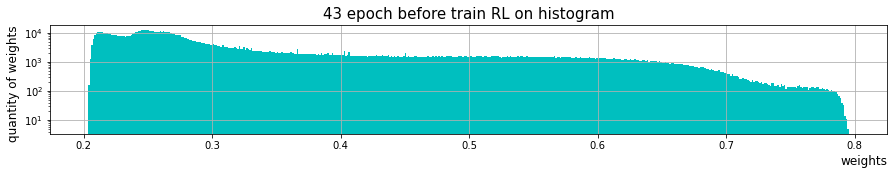

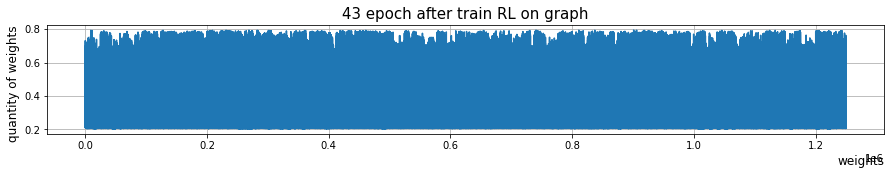

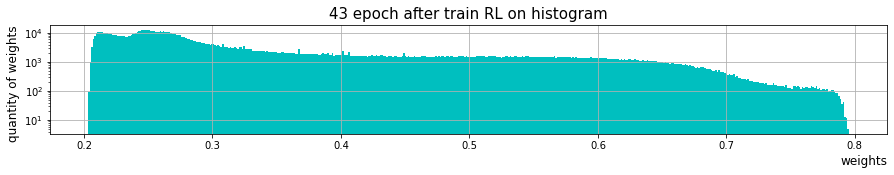

Current Train: 80.12%
1400000 images
Current Test: 76.98%
Current Test Previous: 82.95%
Operational time of epoch #43: 2 min 16 sec
--------------------------------------------------
Epoch #:  44
1420000 images


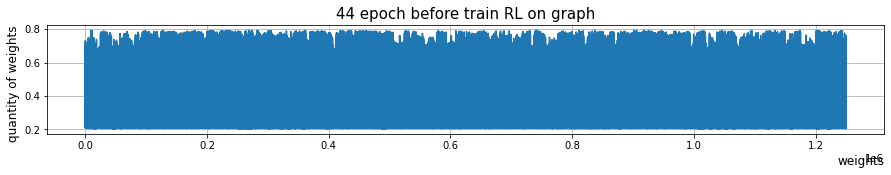

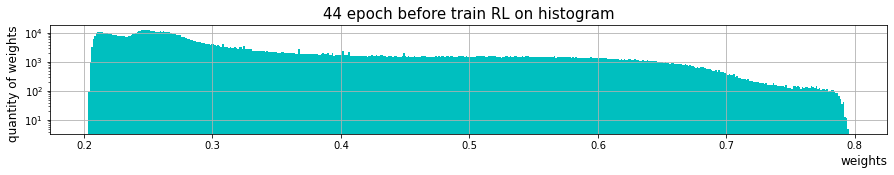

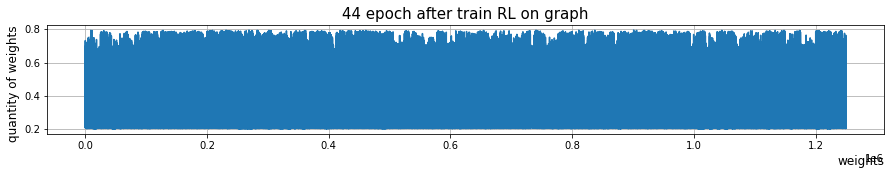

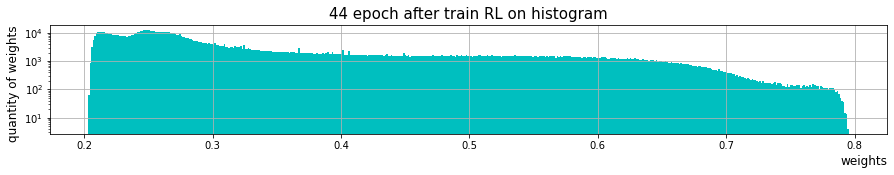

Current Train: 80.14%
Current Test: 77.20%
Current Test Previous: 82.85%
Operational time of epoch #44: 2 min 15 sec
--------------------------------------------------
Epoch #:  45
1440000 images
1460000 images


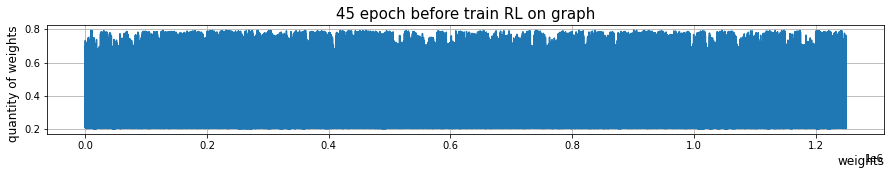

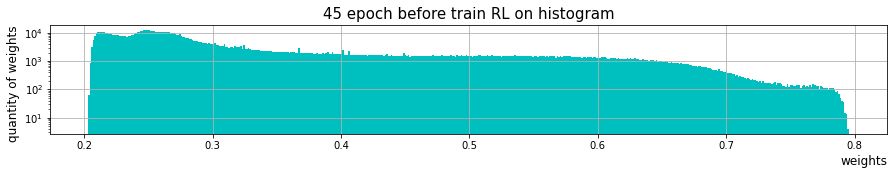

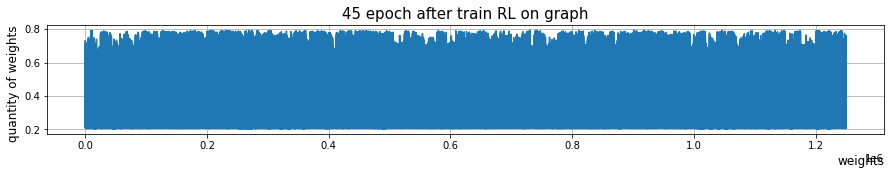

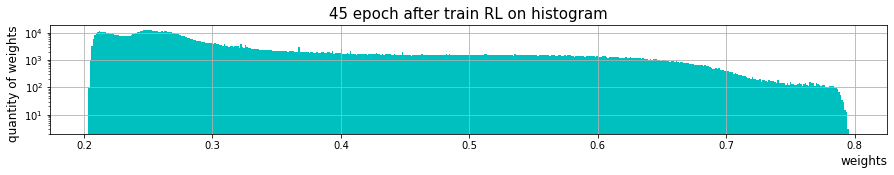

Current Train: 80.12%
Current Test: 76.85%
Current Test Previous: 82.80%
Operational time of epoch #45: 2 min 16 sec
--------------------------------------------------
Epoch #:  46
1480000 images


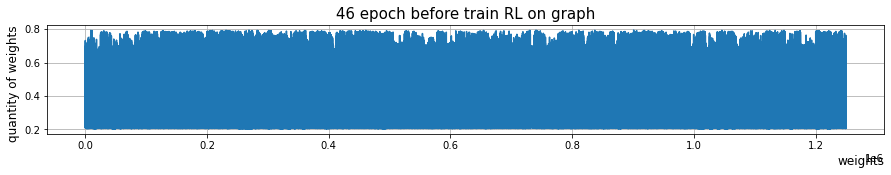

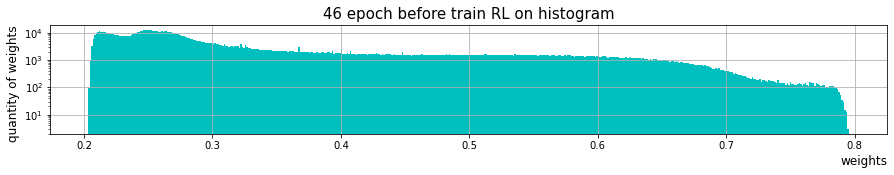

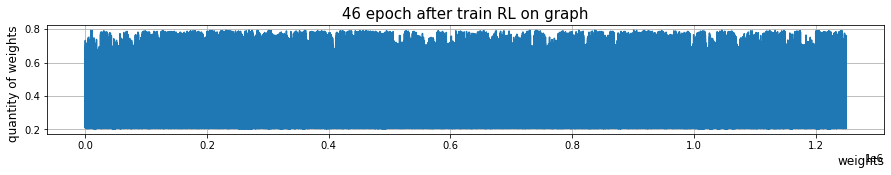

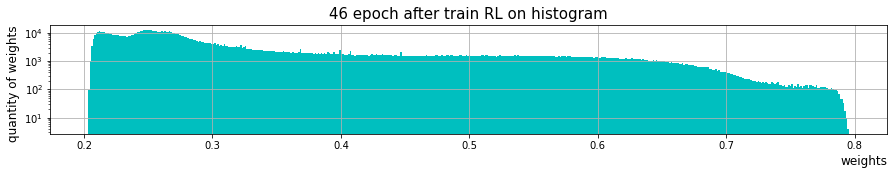

Current Train: 80.00%
Current Test: 76.90%
1500000 images
Current Test Previous: 82.78%
Operational time of epoch #46: 2 min 15 sec
--------------------------------------------------
Epoch #:  47
1520000 images


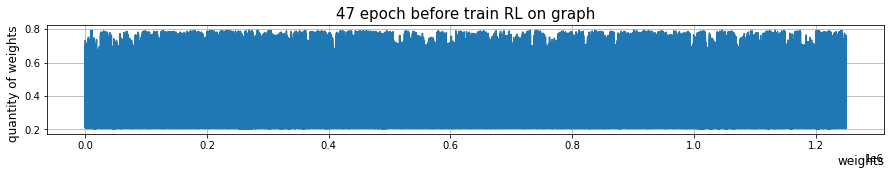

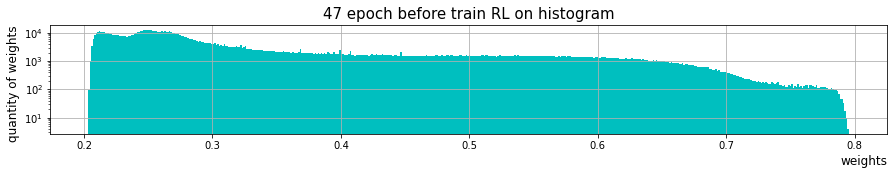

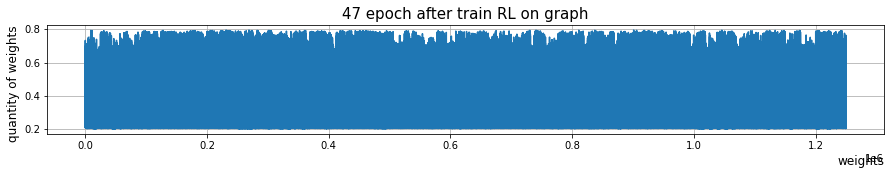

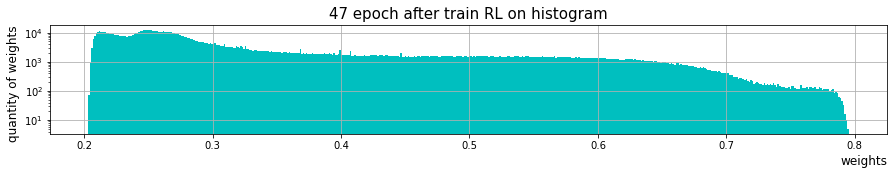

Current Train: 80.23%
Current Test: 77.12%
Current Test Previous: 82.80%
Operational time of epoch #47: 2 min 15 sec
--------------------------------------------------
Epoch #:  48
1540000 images


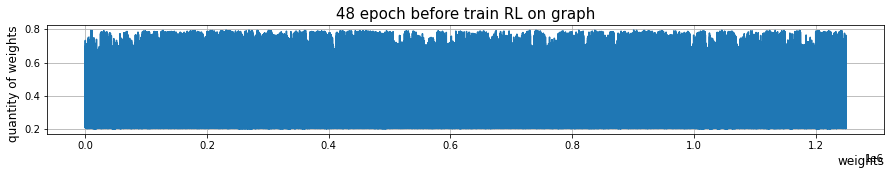

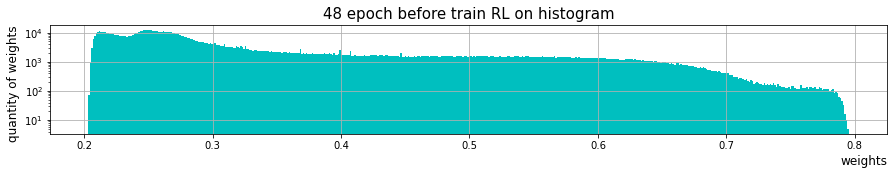

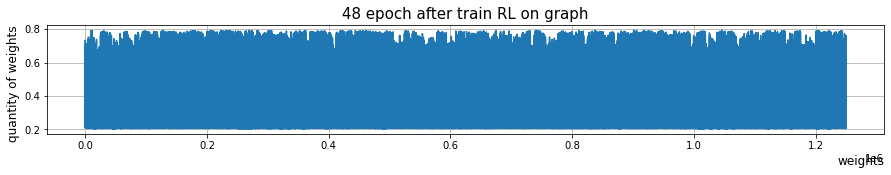

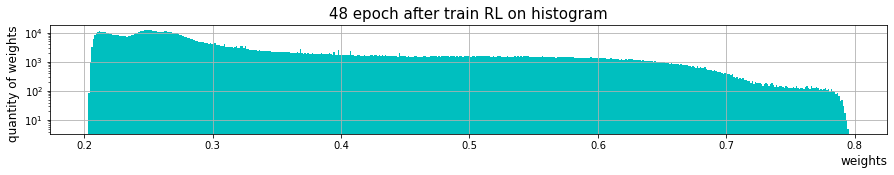

Current Train: 80.05%
1560000 images
Current Test: 76.90%
Current Test Previous: 82.78%
Operational time of epoch #48: 2 min 16 sec
--------------------------------------------------
Epoch #:  49
1580000 images


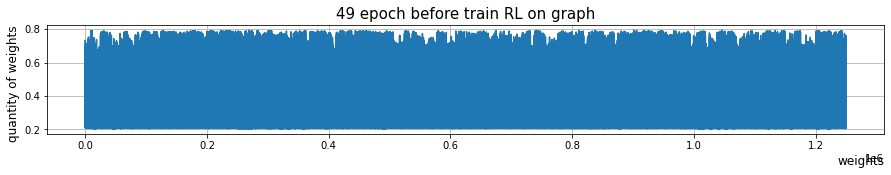

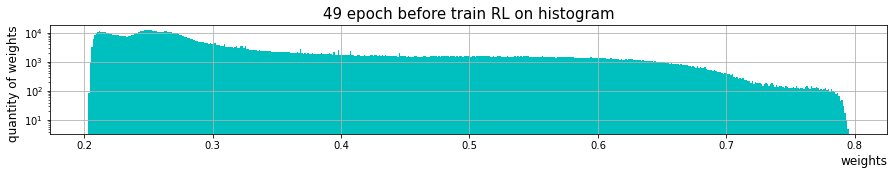

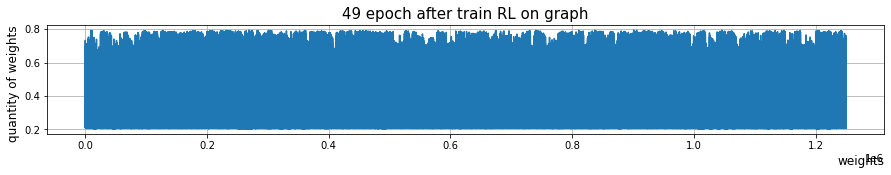

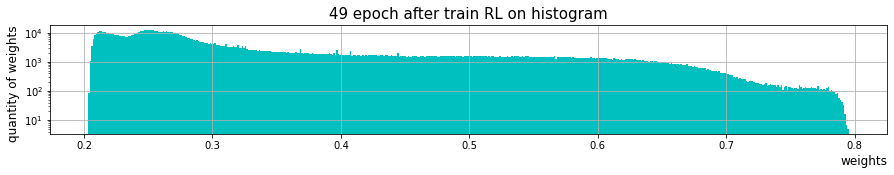

Current Train: 80.06%
Current Test: 76.92%
Current Test Previous: 82.70%
Operational time of epoch #49: 2 min 15 sec
--------------------------------------------------
Epoch #:  50
1600000 images
1620000 images


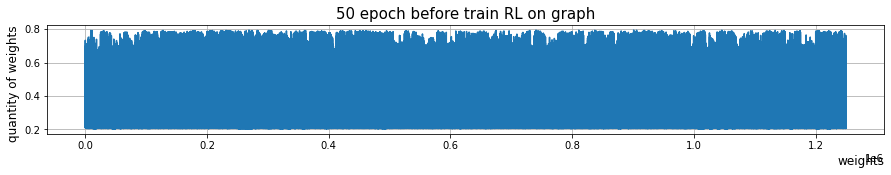

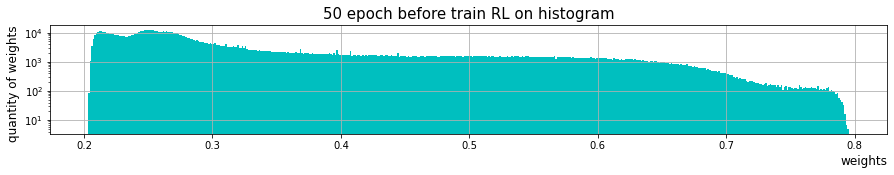

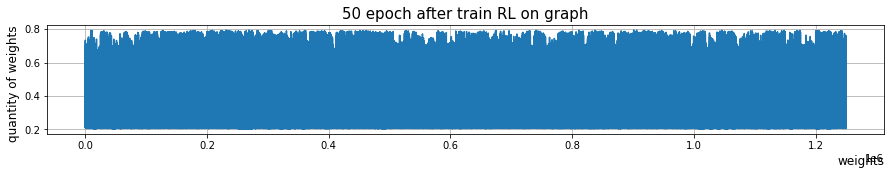

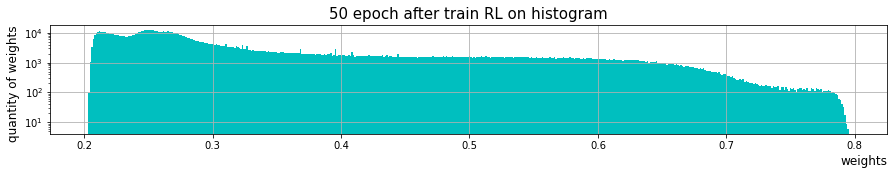

Current Train: 80.11%
Current Test: 76.78%
Current Test Previous: 82.73%
Operational time of epoch #50: 2 min 16 sec
--------------------------------------------------
Epoch #:  51
1640000 images


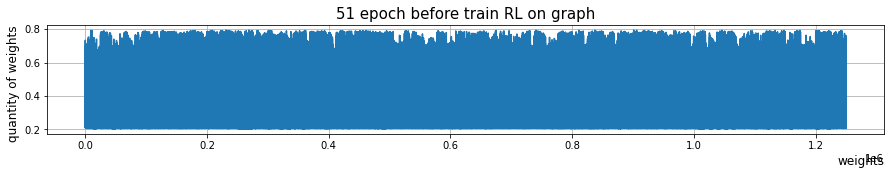

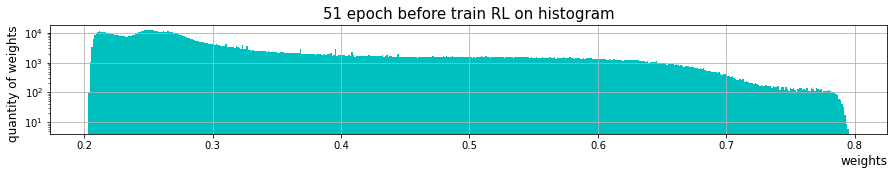

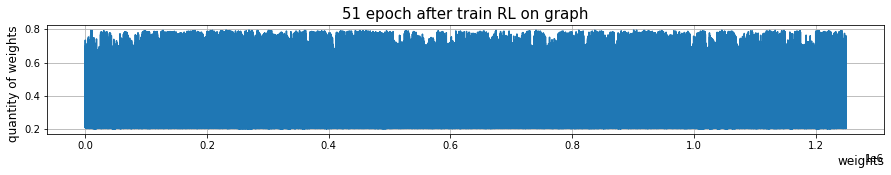

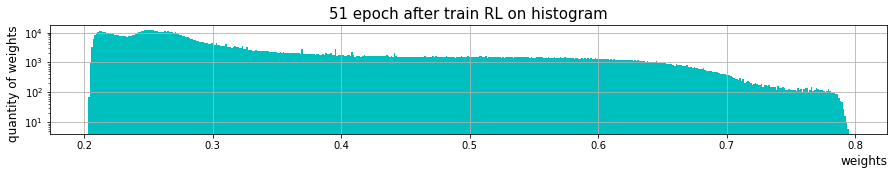

Current Train: 80.25%
Current Test: 76.70%
1660000 images
Current Test Previous: 82.42%
Operational time of epoch #51: 2 min 15 sec
--------------------------------------------------
Epoch #:  52
1680000 images


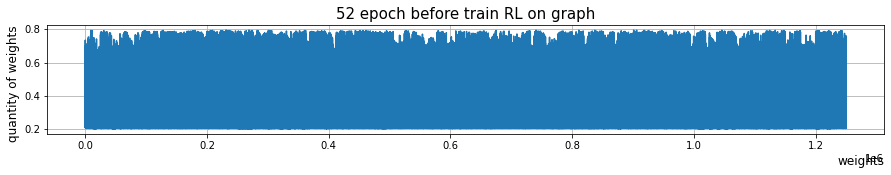

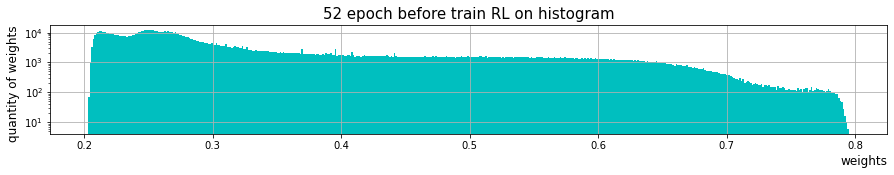

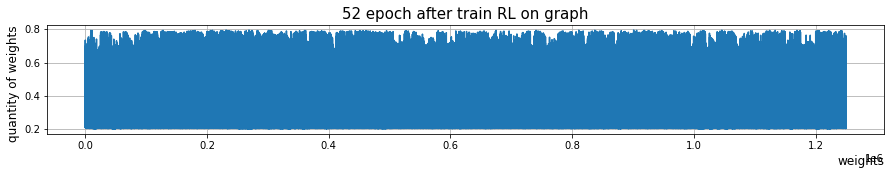

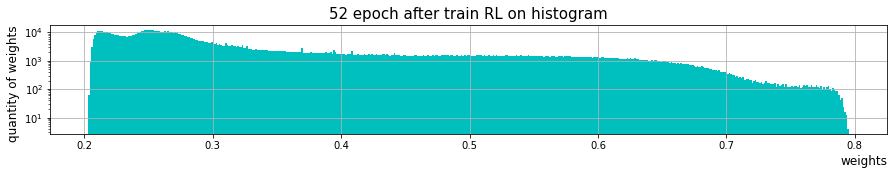

Current Train: 80.06%
Current Test: 76.88%
Current Test Previous: 82.70%
Operational time of epoch #52: 2 min 16 sec
--------------------------------------------------
Epoch #:  53
1700000 images


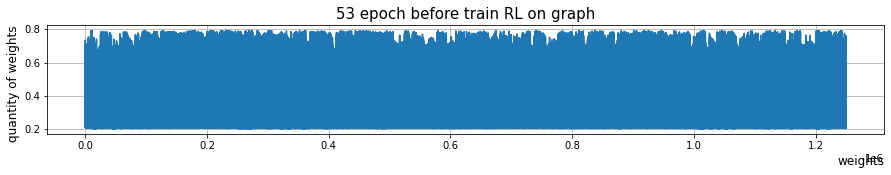

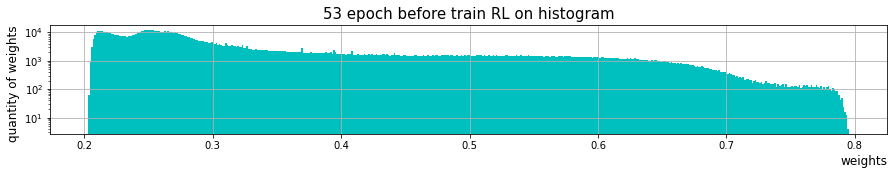

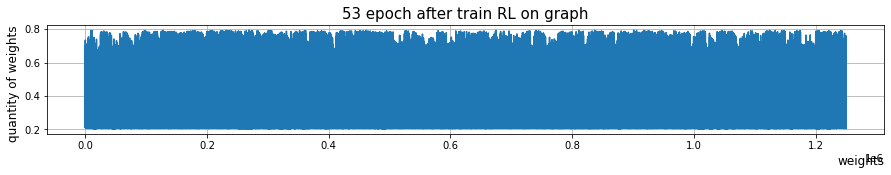

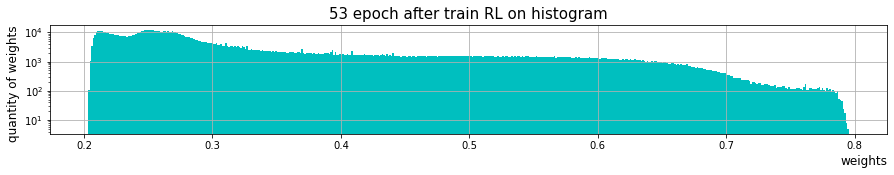

Current Train: 79.98%
1720000 images
Current Test: 76.75%
Current Test Previous: 82.58%
Operational time of epoch #53: 2 min 16 sec
--------------------------------------------------
Epoch #:  54
1740000 images


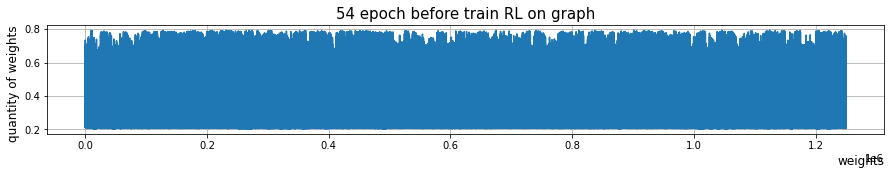

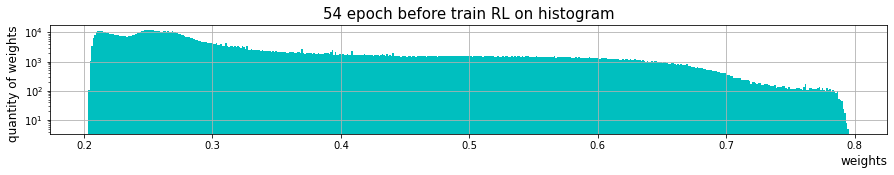

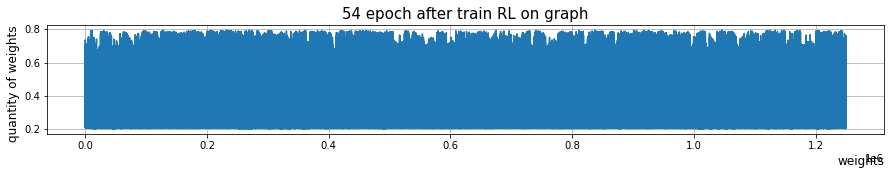

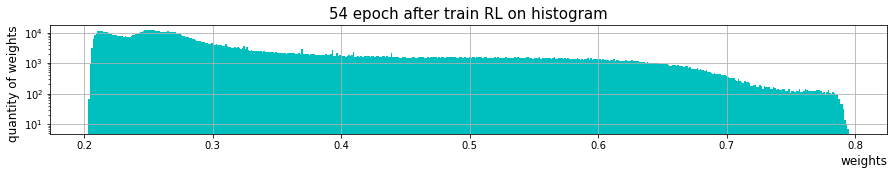

Current Train: 80.14%
Current Test: 76.98%
Current Test Previous: 82.47%
Operational time of epoch #54: 2 min 16 sec
--------------------------------------------------
Epoch #:  55
1760000 images
1780000 images


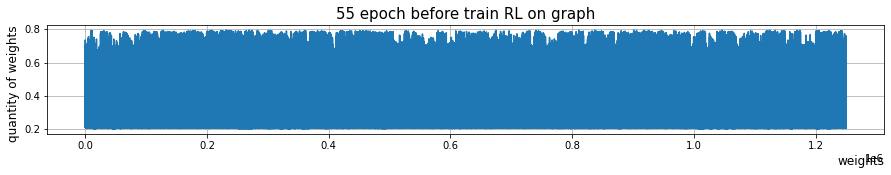

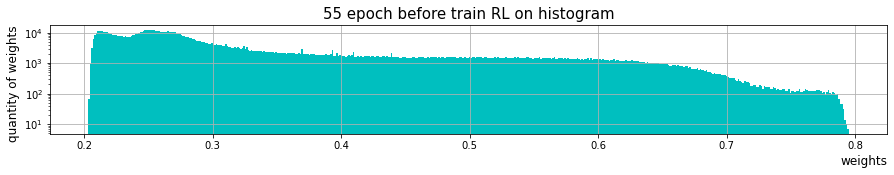

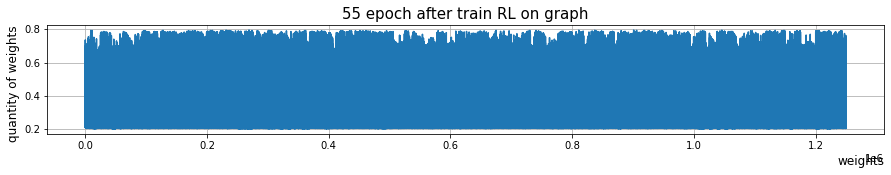

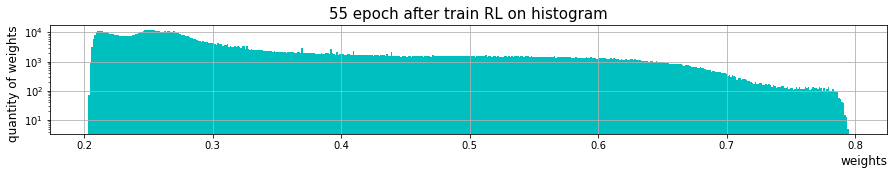

Current Train: 80.04%
Current Test: 77.12%
Current Test Previous: 82.42%
Operational time of epoch #55: 2 min 16 sec
--------------------------------------------------
Epoch #:  56
1800000 images


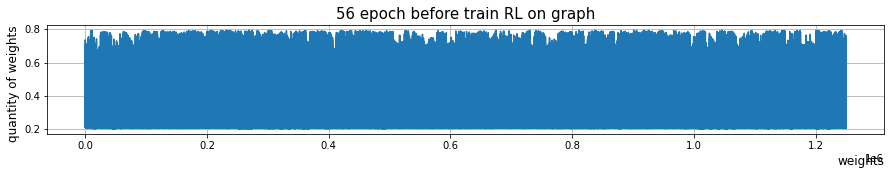

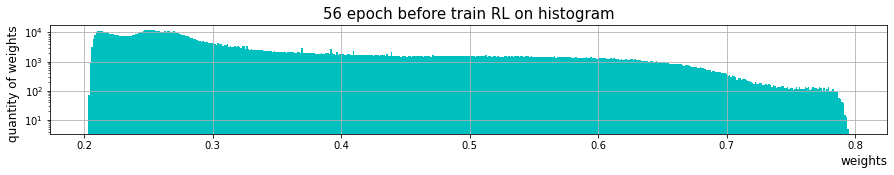

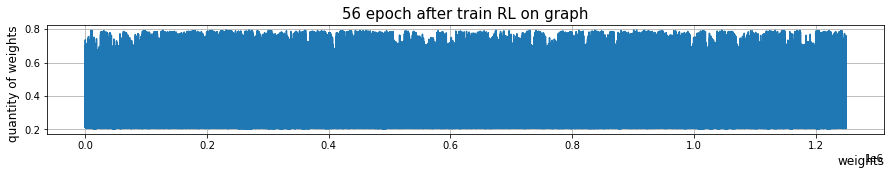

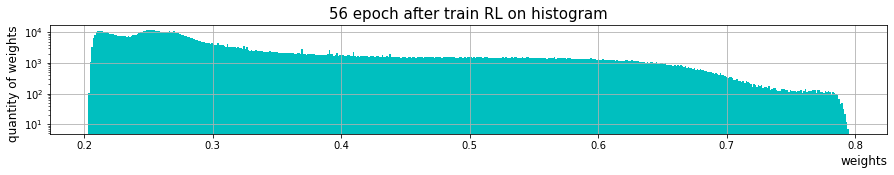

Current Train: 80.15%
Current Test: 76.85%
1820000 images
Current Test Previous: 82.20%
Operational time of epoch #56: 2 min 14 sec
--------------------------------------------------
Epoch #:  57
1840000 images


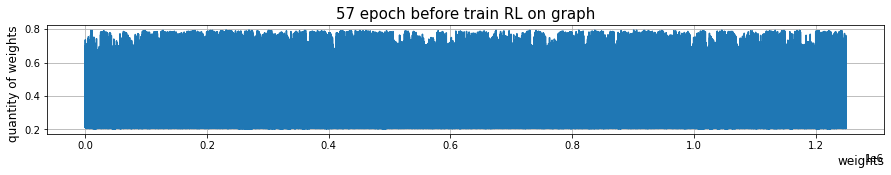

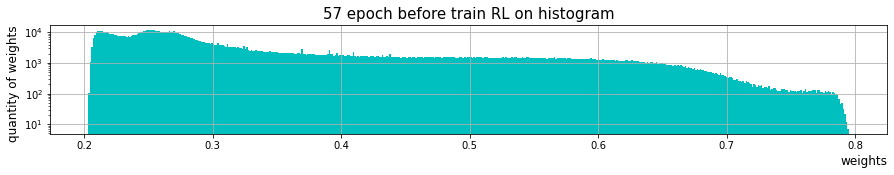

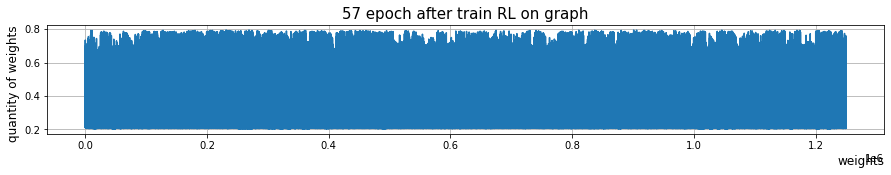

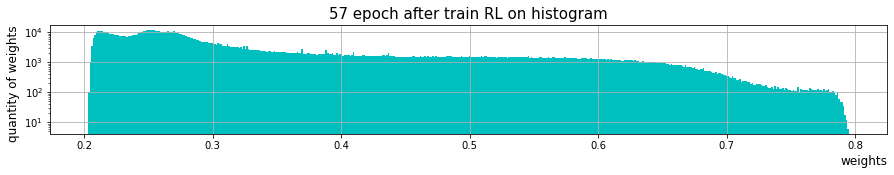

Current Train: 80.15%
Current Test: 77.20%
Current Test Previous: 82.38%
Operational time of epoch #57: 2 min 14 sec
--------------------------------------------------
Epoch #:  58
1860000 images


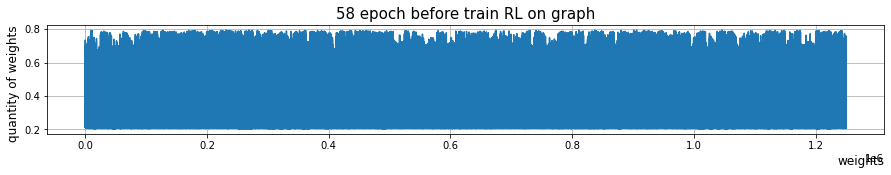

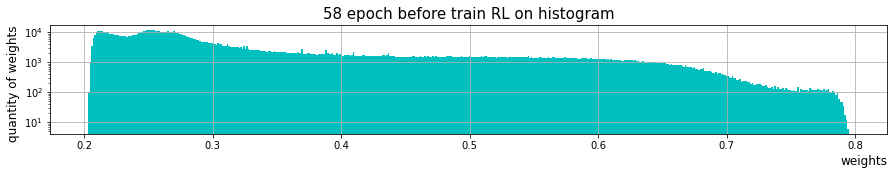

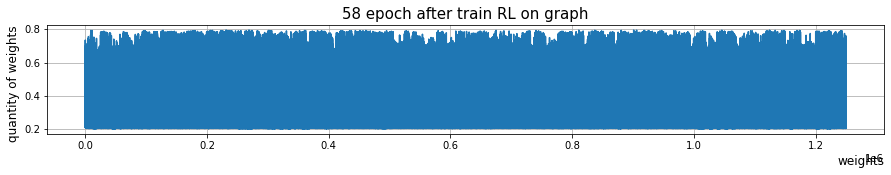

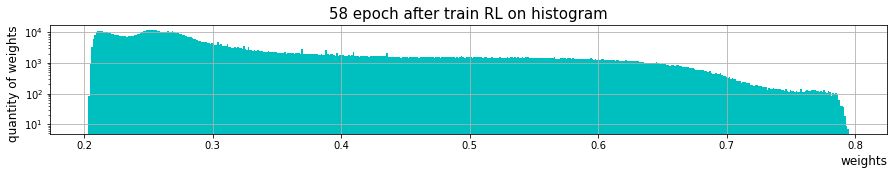

Current Train: 80.20%
1880000 images
Current Test: 77.40%
Current Test Previous: 82.33%
Operational time of epoch #58: 2 min 14 sec
--------------------------------------------------
Epoch #:  59
1900000 images


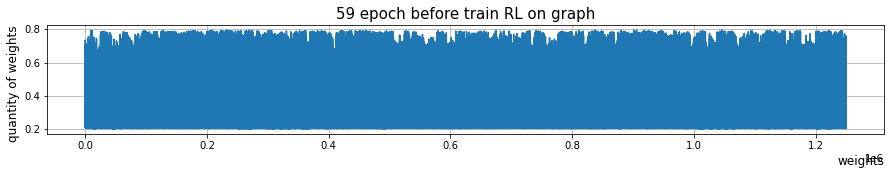

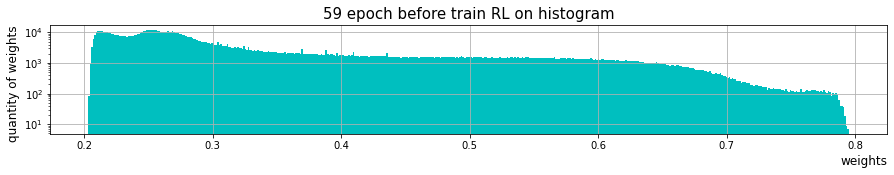

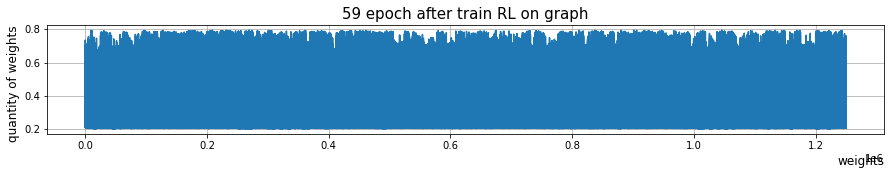

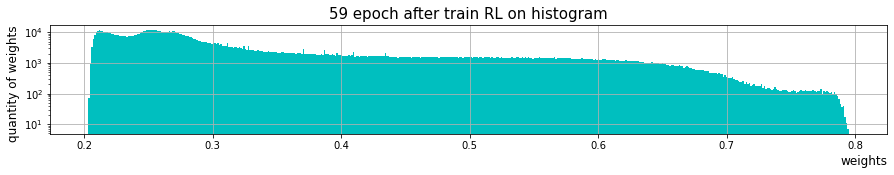

Current Train: 80.05%
Current Test: 77.22%
Current Test Previous: 82.35%
Operational time of epoch #59: 2 min 14 sec
--------------------------------------------------
Epoch #:  60
1920000 images
1940000 images


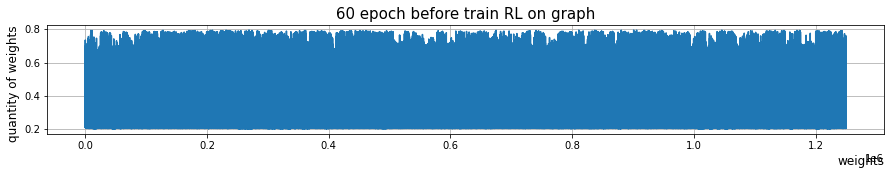

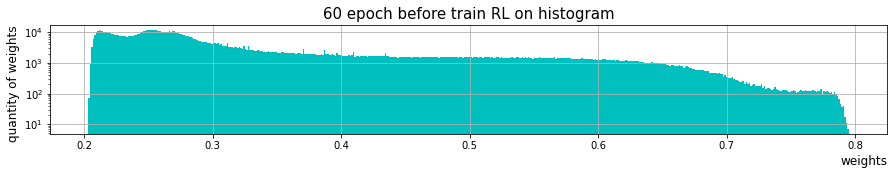

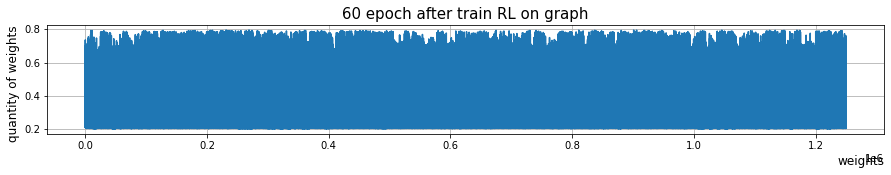

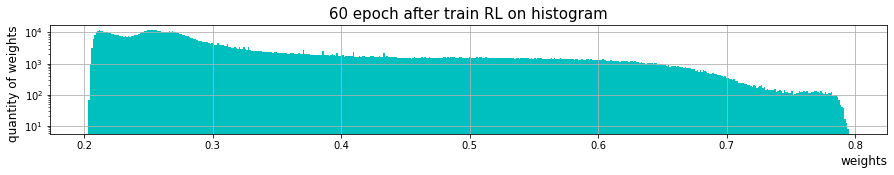

Current Train: 80.14%
Current Test: 76.72%
Current Test Previous: 82.30%
Operational time of epoch #60: 2 min 14 sec
--------------------------------------------------
Epoch #:  61
1960000 images


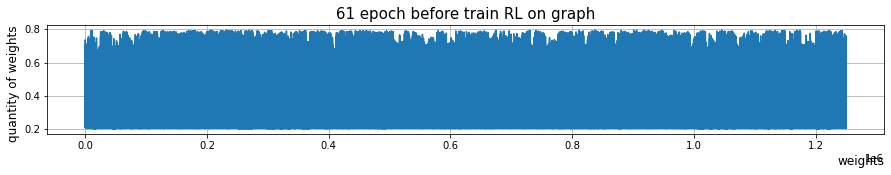

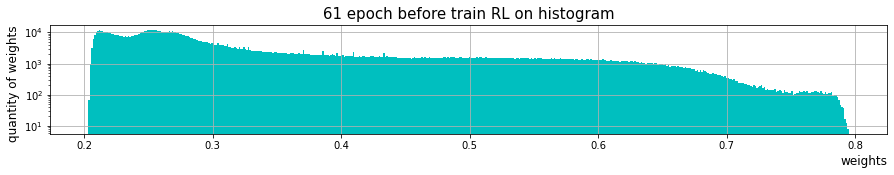

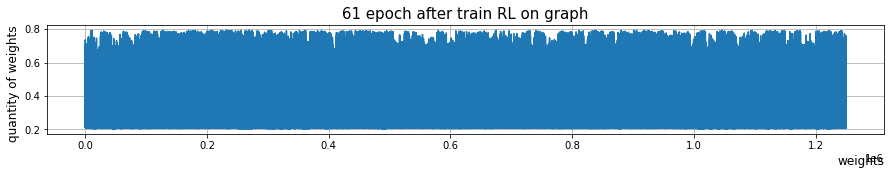

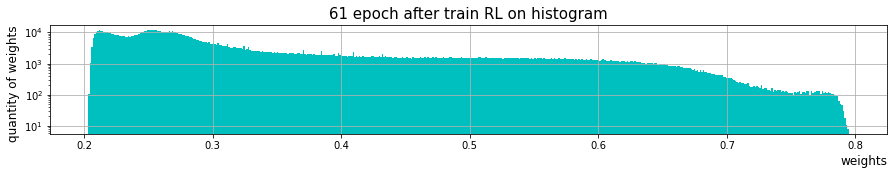

Current Train: 80.18%
Current Test: 76.98%
1980000 images
Current Test Previous: 82.08%
Operational time of epoch #61: 2 min 14 sec
--------------------------------------------------
Epoch #:  62
2000000 images


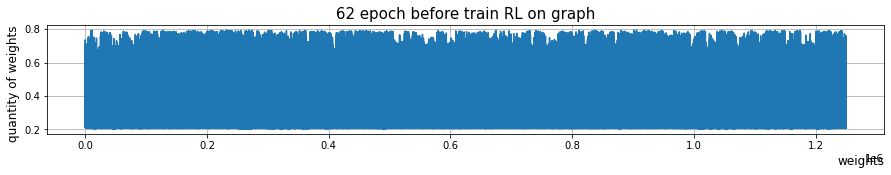

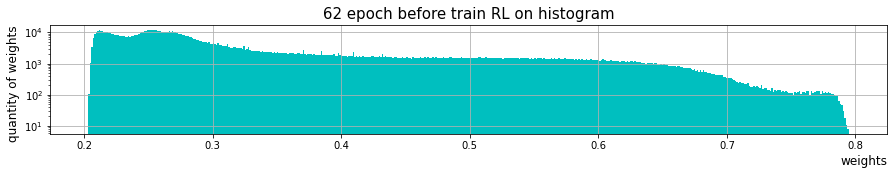

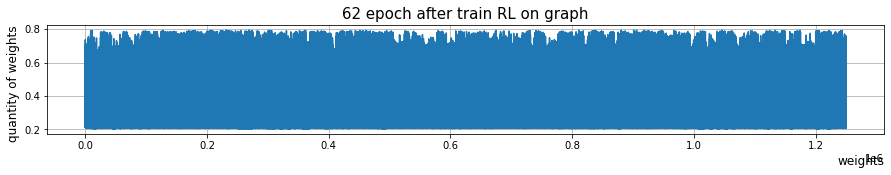

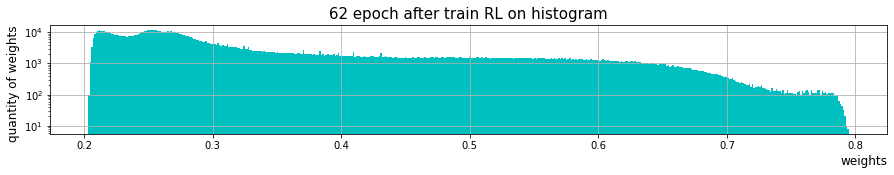

Current Train: 80.10%
Current Test: 76.98%
Current Test Previous: 82.38%
Operational time of epoch #62: 2 min 14 sec
--------------------------------------------------
Epoch #:  63
2020000 images


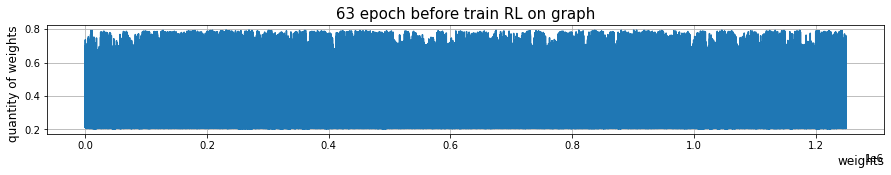

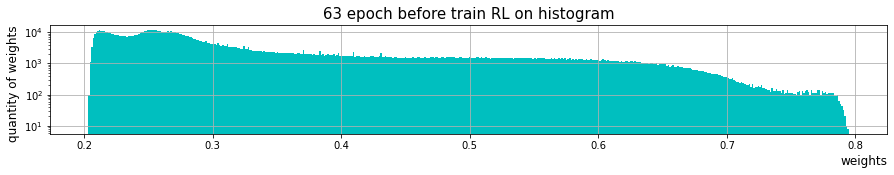

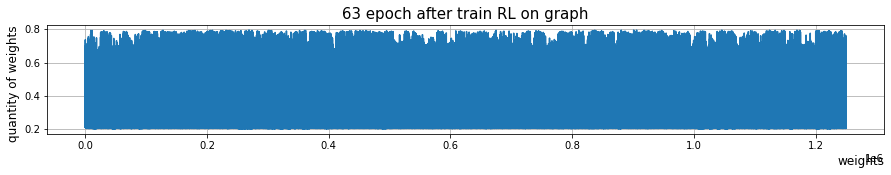

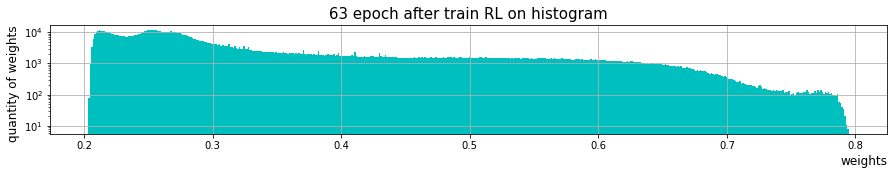

Current Train: 80.21%
2040000 images
Current Test: 77.08%
Current Test Previous: 82.10%
Operational time of epoch #63: 2 min 14 sec
--------------------------------------------------
Epoch #:  64
2060000 images


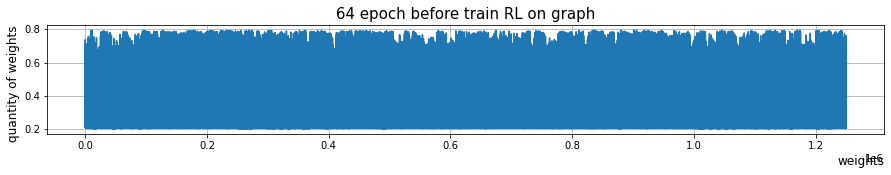

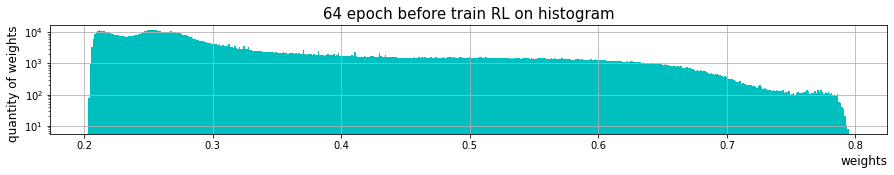

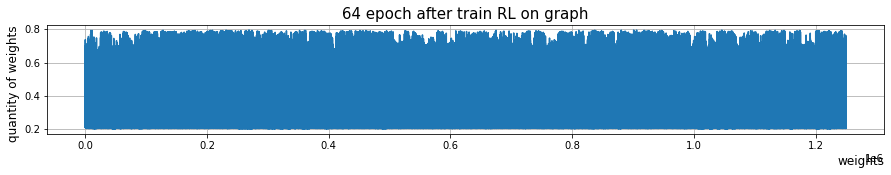

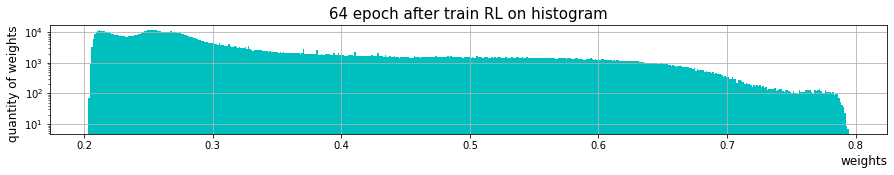

Current Train: 80.23%
Current Test: 77.00%
Current Test Previous: 82.08%
Operational time of epoch #64: 2 min 14 sec
--------------------------------------------------
Epoch #:  65
2080000 images
2100000 images


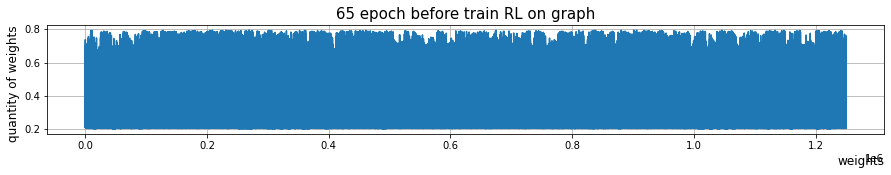

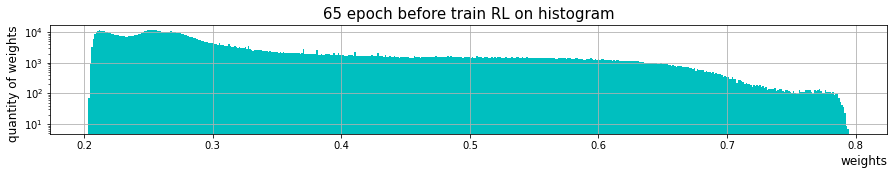

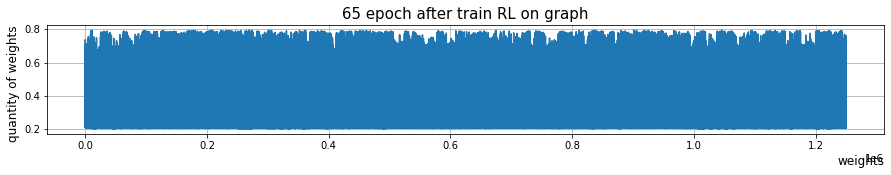

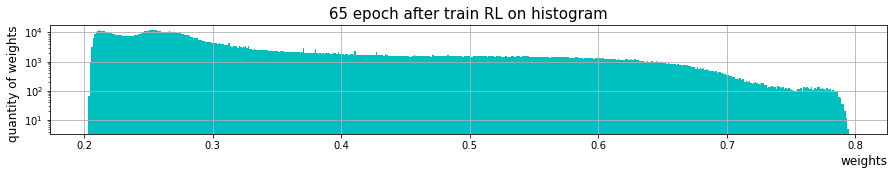

Current Train: 80.27%
Current Test: 76.80%
Current Test Previous: 82.30%
Operational time of epoch #65: 2 min 14 sec
--------------------------------------------------
Epoch #:  66
2120000 images


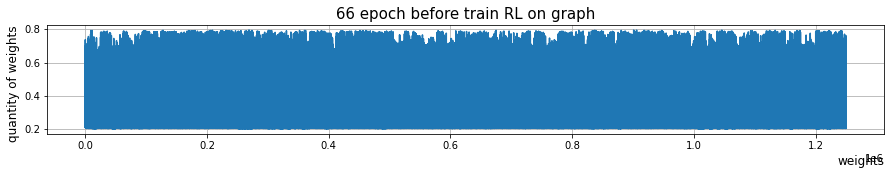

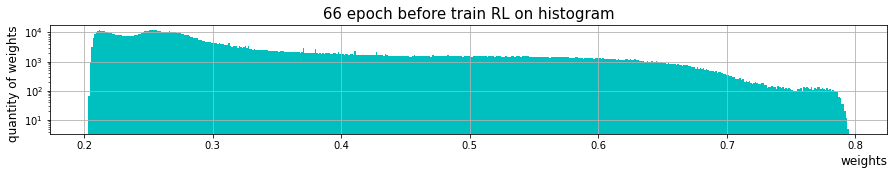

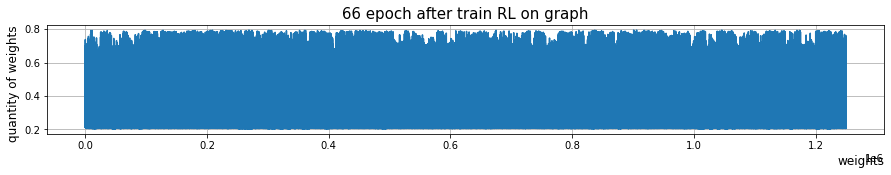

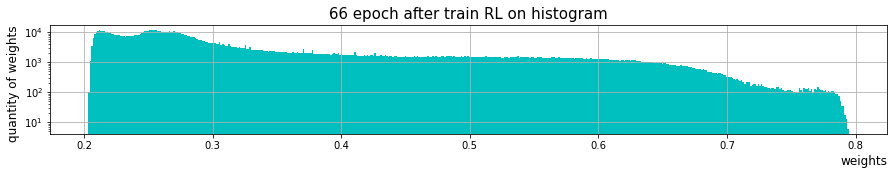

Current Train: 80.23%
Current Test: 77.05%
2140000 images
Current Test Previous: 82.38%
Operational time of epoch #66: 2 min 15 sec
--------------------------------------------------
Epoch #:  67
2160000 images


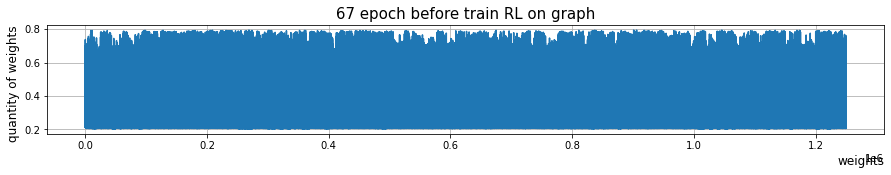

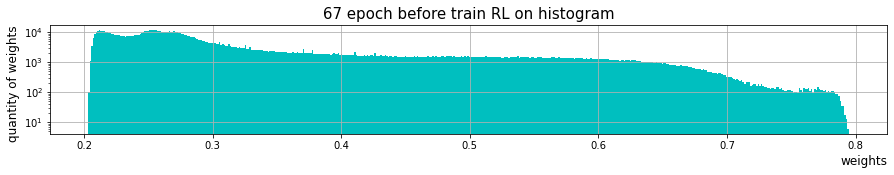

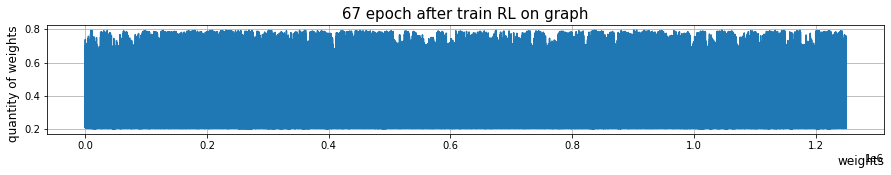

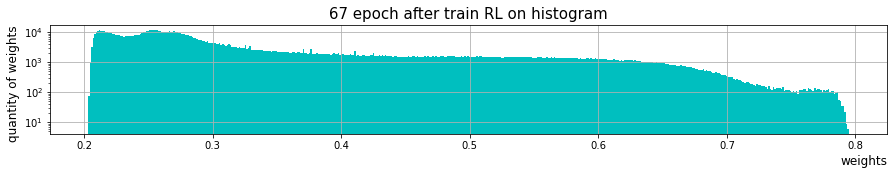

Current Train: 80.13%
Current Test: 76.88%
Current Test Previous: 82.17%
Operational time of epoch #67: 2 min 16 sec
--------------------------------------------------
Epoch #:  68
2180000 images


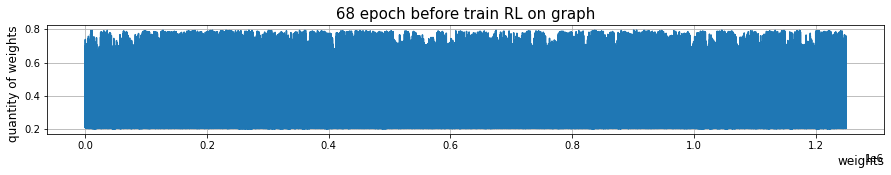

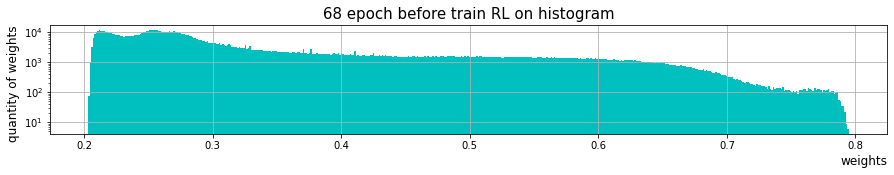

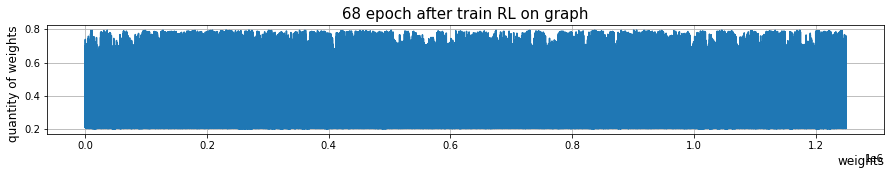

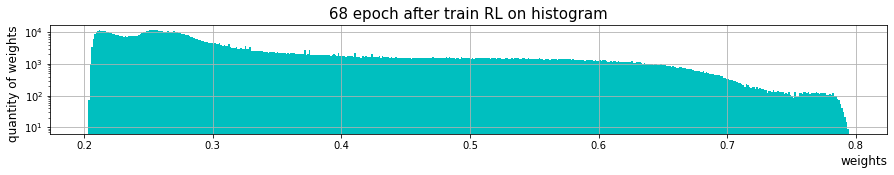

Current Train: 80.20%
2200000 images
Current Test: 76.80%
Current Test Previous: 82.25%
Operational time of epoch #68: 2 min 15 sec
--------------------------------------------------
Epoch #:  69
2220000 images


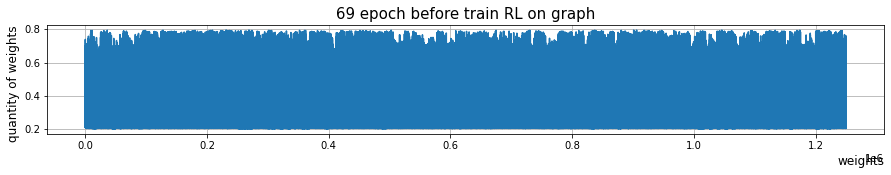

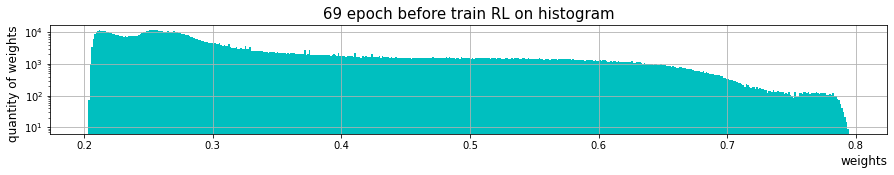

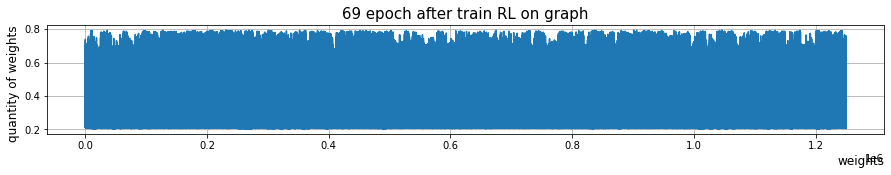

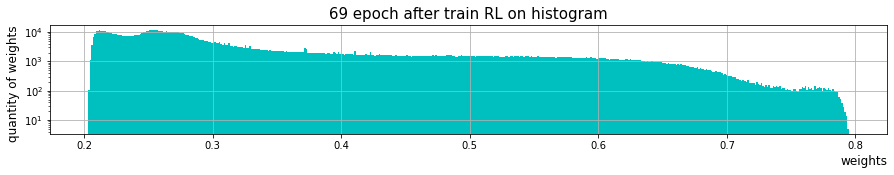

Current Train: 80.17%
Current Test: 76.65%
Current Test Previous: 82.38%
Operational time of epoch #69: 2 min 16 sec
--------------------------------------------------
Epoch #:  70
2240000 images
2260000 images


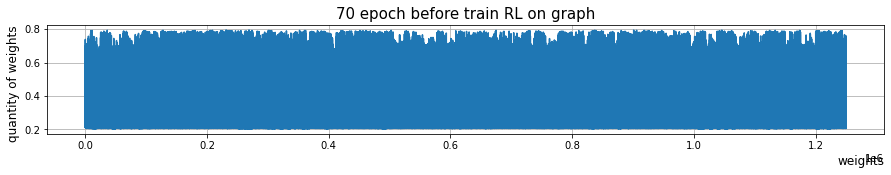

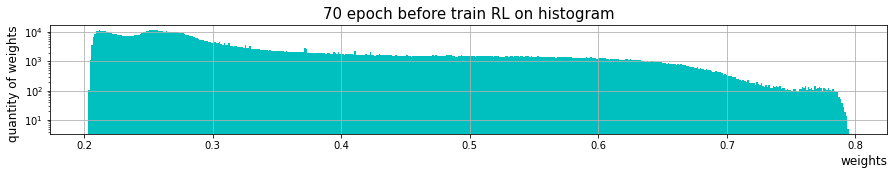

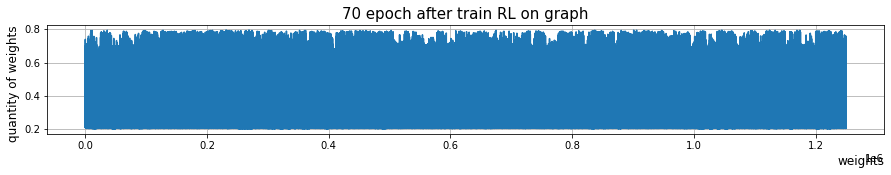

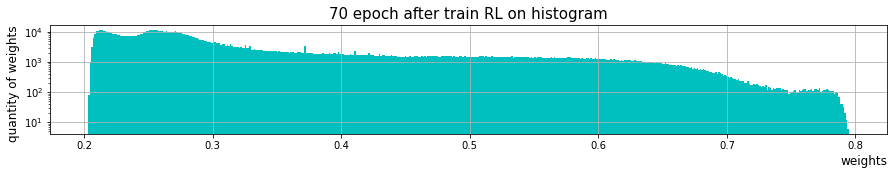

Current Train: 80.23%
Current Test: 77.00%
Current Test Previous: 81.92%
Operational time of epoch #70: 2 min 15 sec
--------------------------------------------------
Epoch #:  71
2280000 images


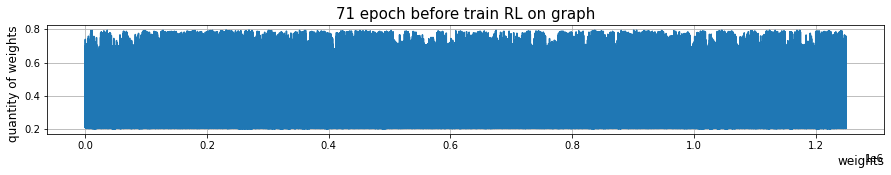

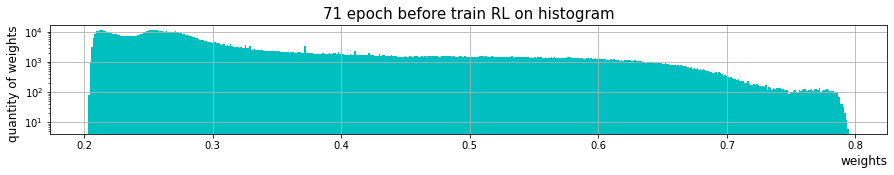

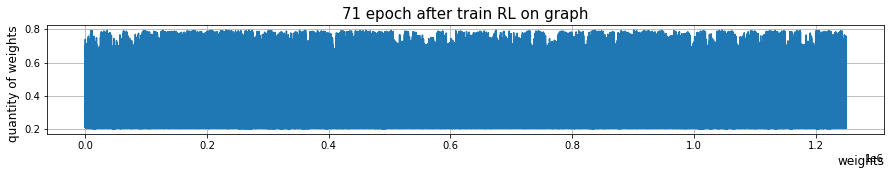

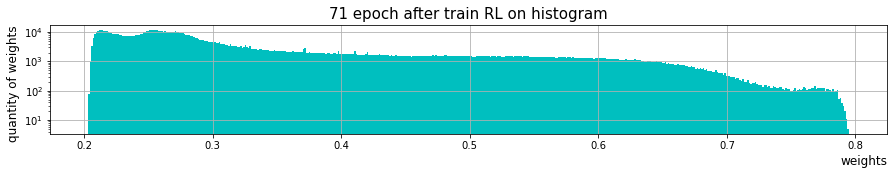

Current Train: 80.23%
Current Test: 77.10%
2300000 images
Current Test Previous: 82.10%
Operational time of epoch #71: 2 min 15 sec
--------------------------------------------------
Epoch #:  72
2320000 images


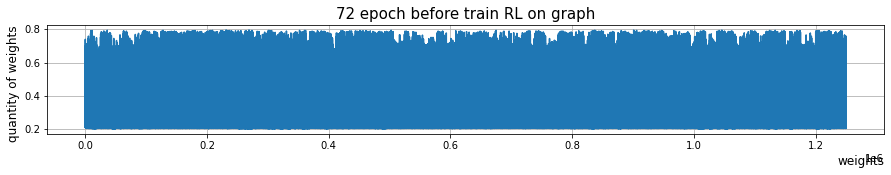

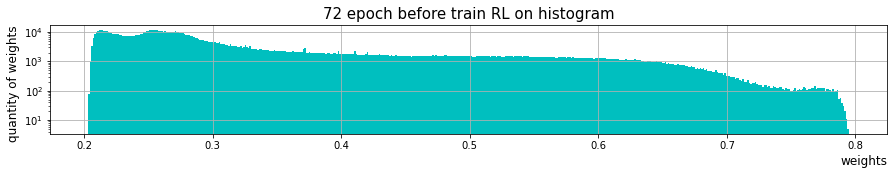

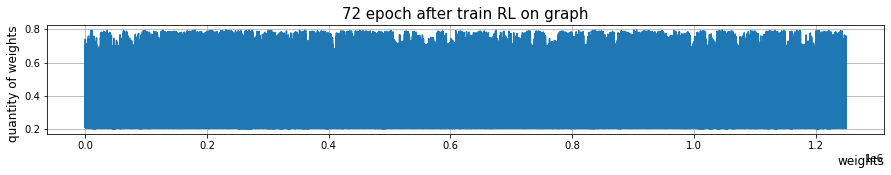

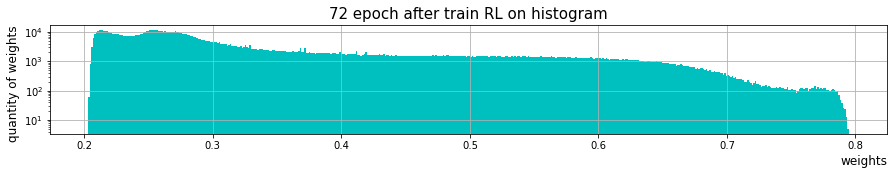

Current Train: 80.20%
Current Test: 76.90%
Current Test Previous: 82.05%
Operational time of epoch #72: 2 min 15 sec
--------------------------------------------------
Epoch #:  73
2340000 images


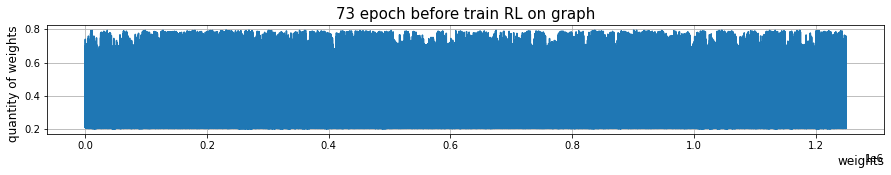

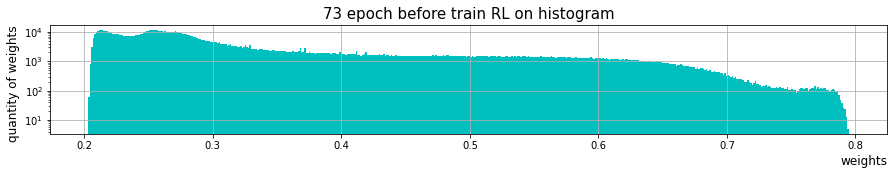

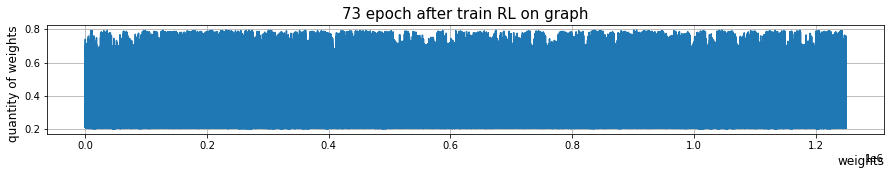

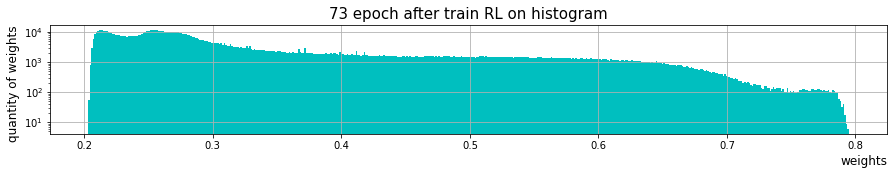

Current Train: 80.24%
2360000 images
Current Test: 76.70%
Current Test Previous: 81.95%
Operational time of epoch #73: 2 min 15 sec
--------------------------------------------------
Epoch #:  74
2380000 images


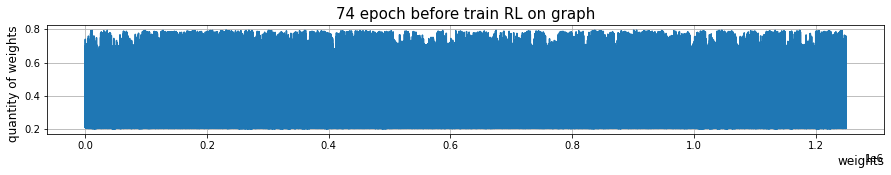

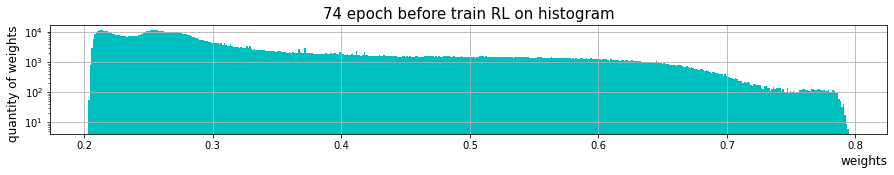

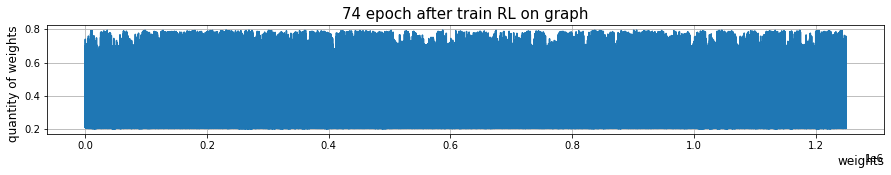

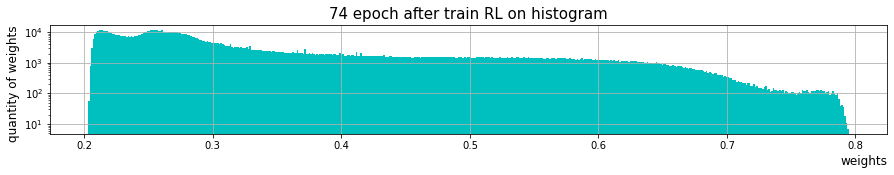

Current Train: 80.33%
Current Test: 77.05%
Current Test Previous: 81.88%
Operational time of epoch #74: 2 min 15 sec
--------------------------------------------------
Epoch #:  75
2400000 images
2420000 images


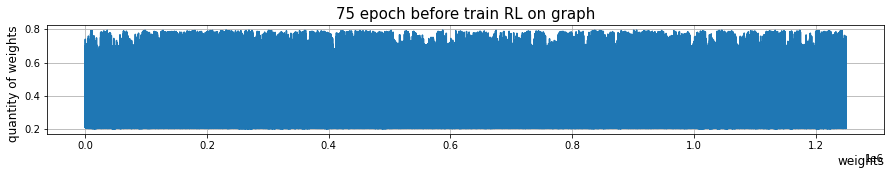

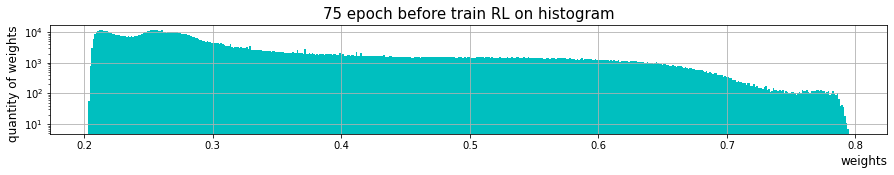

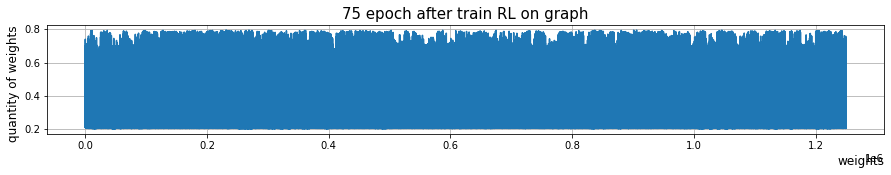

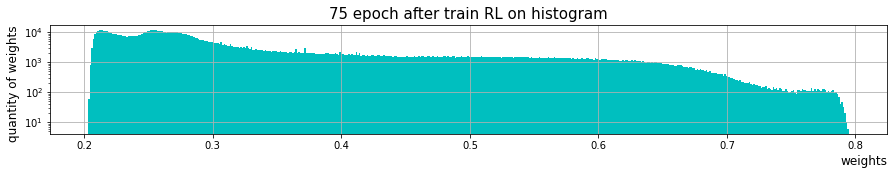

Current Train: 80.41%
Current Test: 76.98%
Current Test Previous: 81.95%
Operational time of epoch #75: 2 min 15 sec
--------------------------------------------------
Epoch #:  76
2440000 images


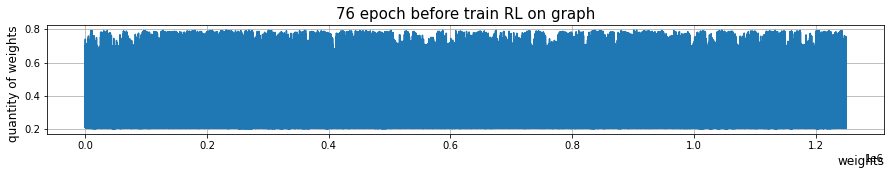

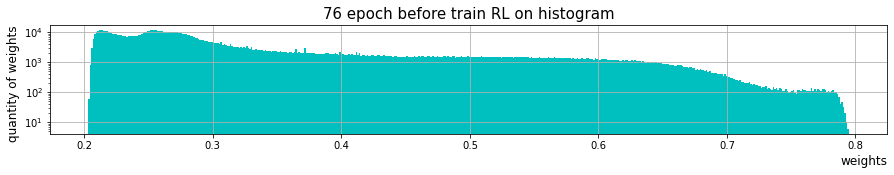

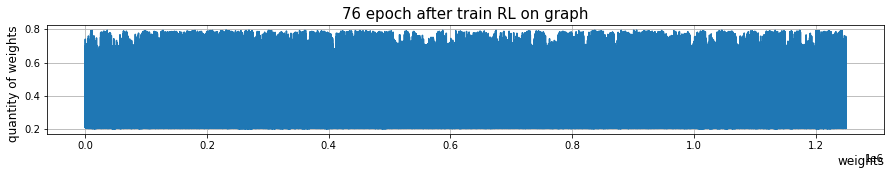

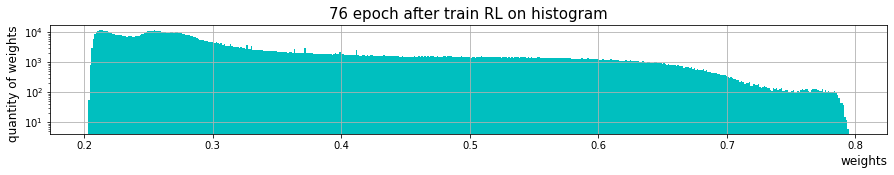

Current Train: 80.23%
Current Test: 77.00%
2460000 images
Current Test Previous: 82.03%
Operational time of epoch #76: 2 min 15 sec
--------------------------------------------------
Epoch #:  77
2480000 images


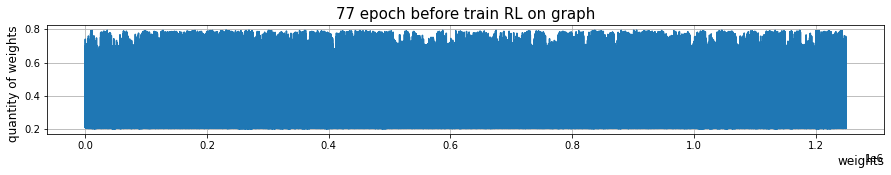

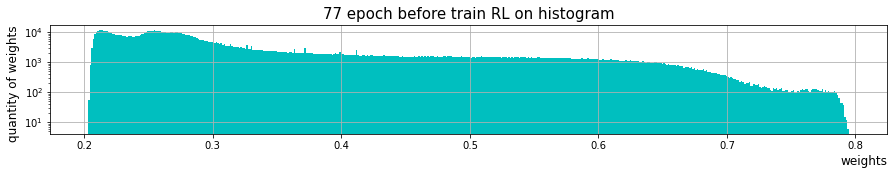

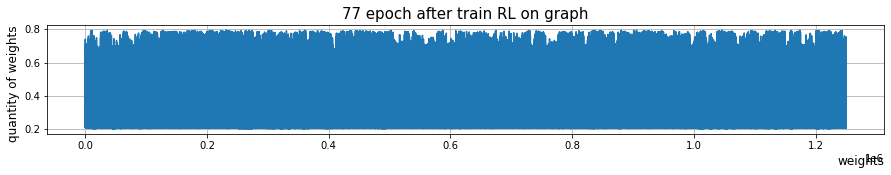

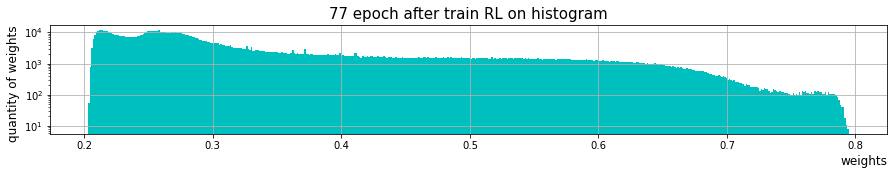

Current Train: 80.23%
Current Test: 76.72%
Current Test Previous: 81.70%
Operational time of epoch #77: 2 min 16 sec
--------------------------------------------------
Epoch #:  78
2500000 images


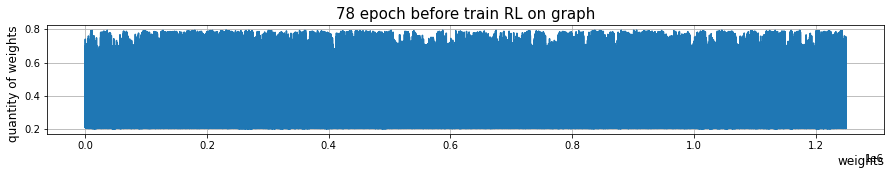

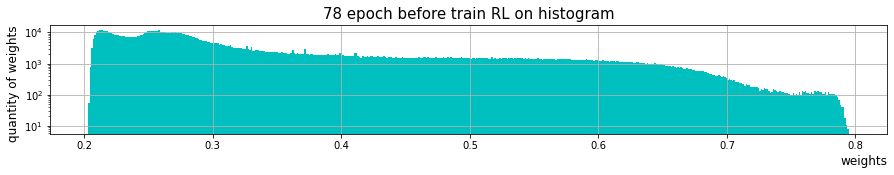

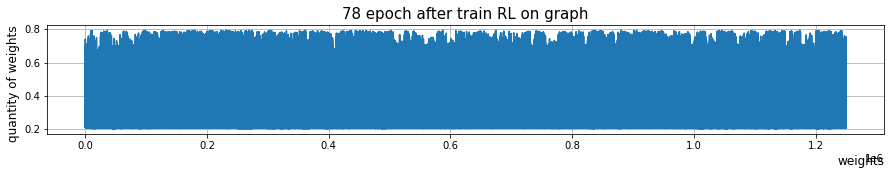

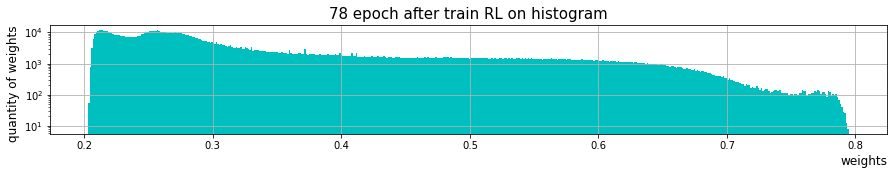

Current Train: 80.32%
2520000 images
Current Test: 77.08%
Current Test Previous: 81.55%
Operational time of epoch #78: 2 min 15 sec
--------------------------------------------------
Epoch #:  79
2540000 images


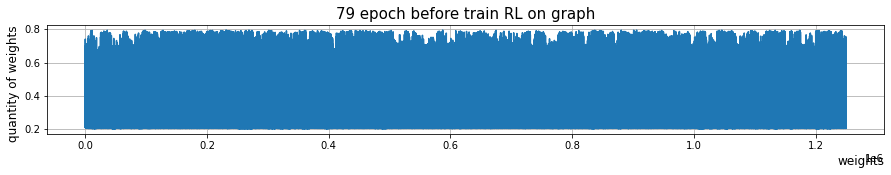

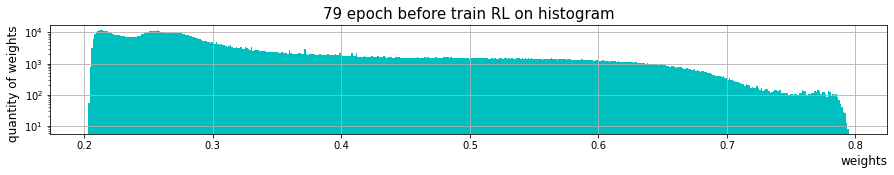

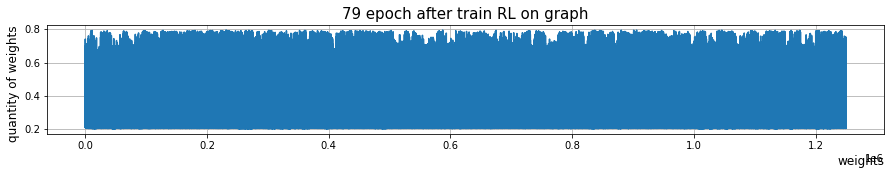

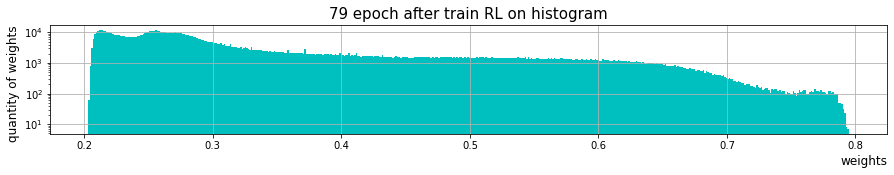

Current Train: 80.25%
Current Test: 76.98%
Current Test Previous: 81.73%
Operational time of epoch #79: 2 min 15 sec
--------------------------------------------------
Epoch #:  80
2560000 images
2580000 images


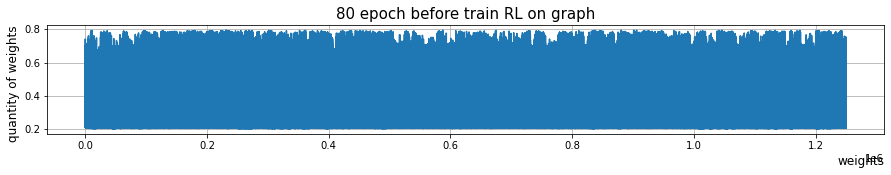

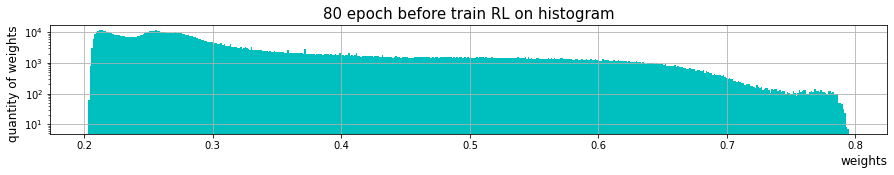

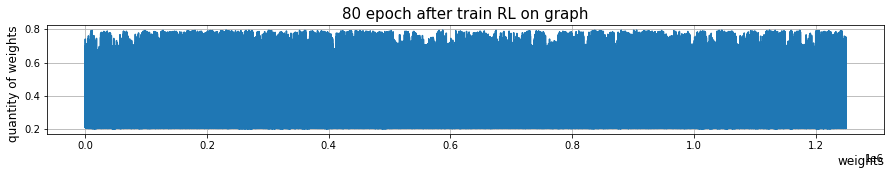

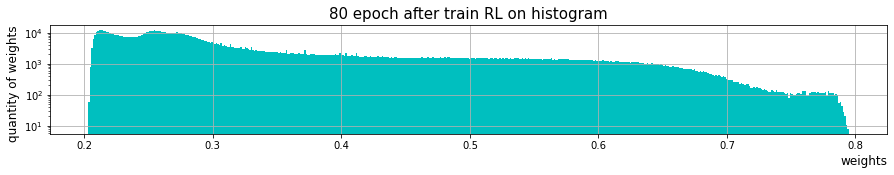

Current Train: 80.37%
Current Test: 76.75%
Current Test Previous: 81.58%
Operational time of epoch #80: 2 min 15 sec
--------------------------------------------------
Epoch #:  81
2600000 images


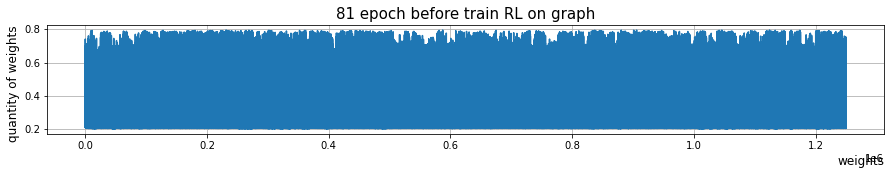

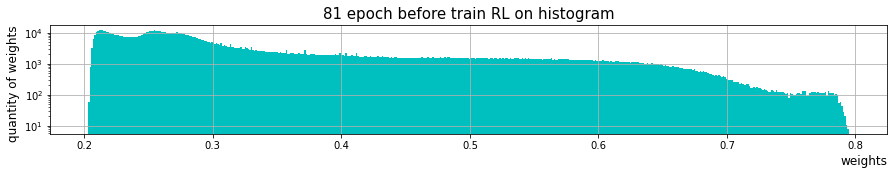

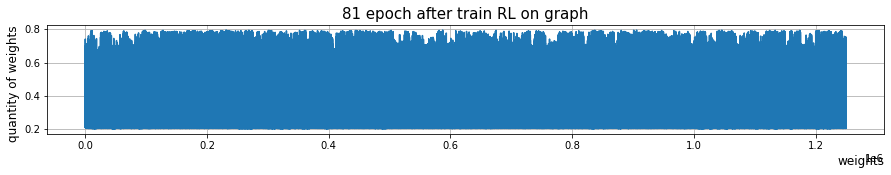

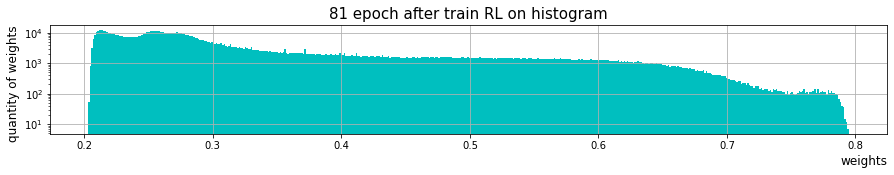

Current Train: 80.43%
Current Test: 76.85%
2620000 images
Current Test Previous: 81.70%
Operational time of epoch #81: 2 min 15 sec
--------------------------------------------------
Epoch #:  82
2640000 images


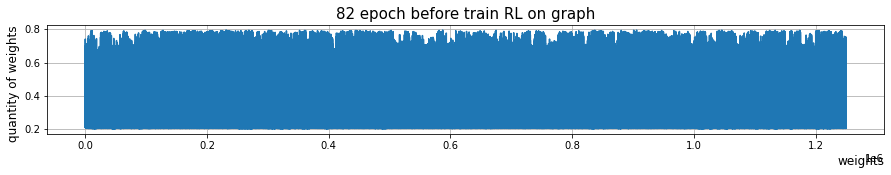

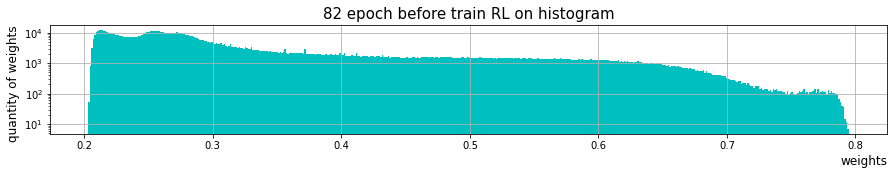

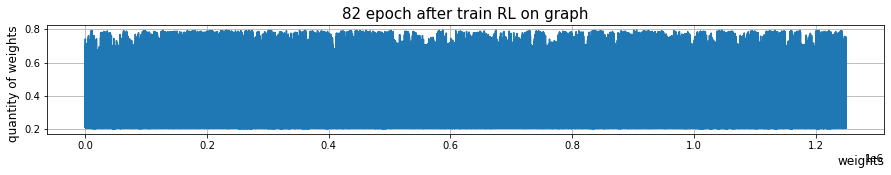

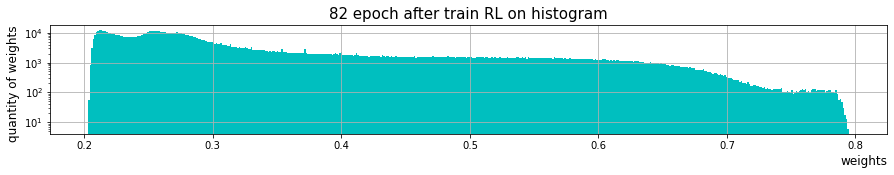

Current Train: 80.42%
Current Test: 76.75%
Current Test Previous: 81.70%
Operational time of epoch #82: 2 min 15 sec
--------------------------------------------------
Epoch #:  83
2660000 images


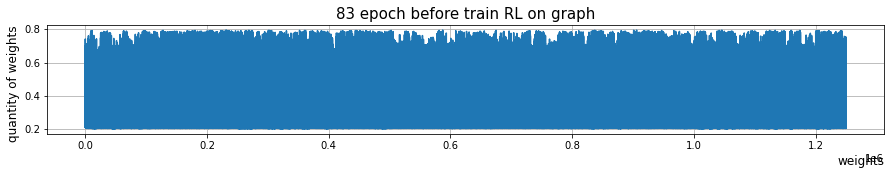

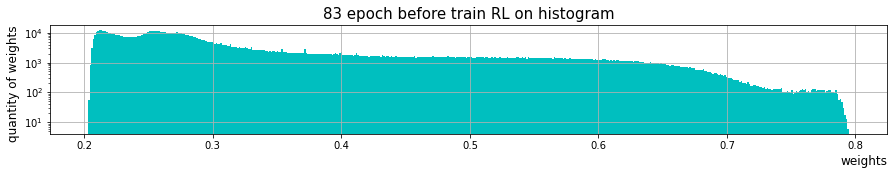

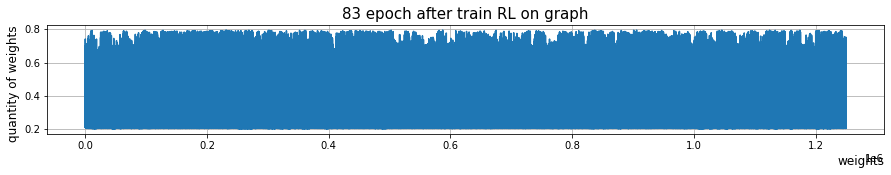

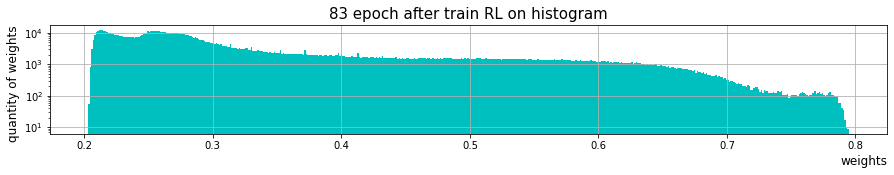

Current Train: 80.47%
2680000 images
Current Test: 76.90%
Current Test Previous: 81.70%
Operational time of epoch #83: 2 min 16 sec
--------------------------------------------------
Epoch #:  84
2700000 images


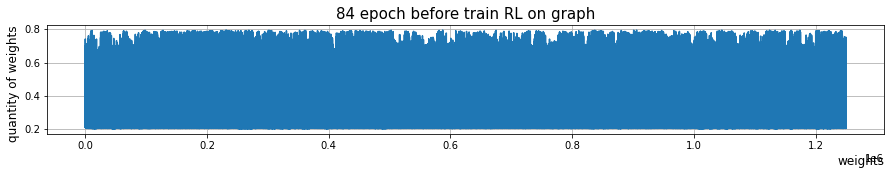

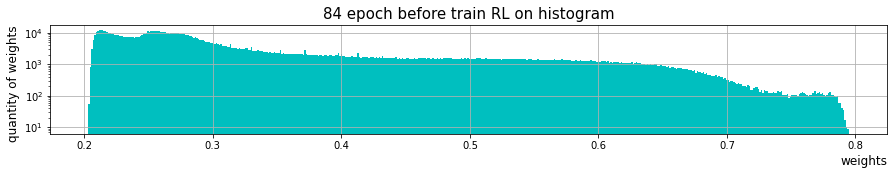

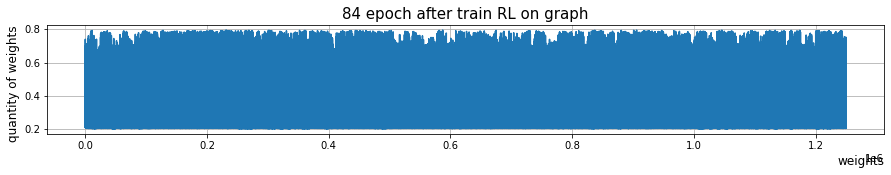

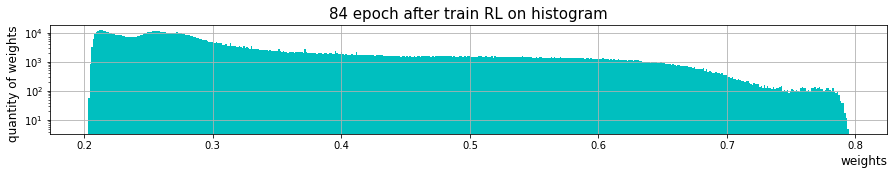

Current Train: 80.50%
Current Test: 76.72%
Current Test Previous: 81.67%
Operational time of epoch #84: 2 min 15 sec
--------------------------------------------------
Epoch #:  85
2720000 images
2740000 images


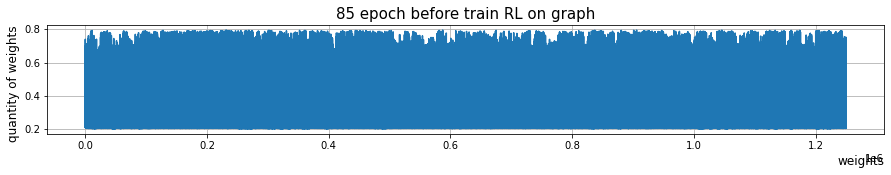

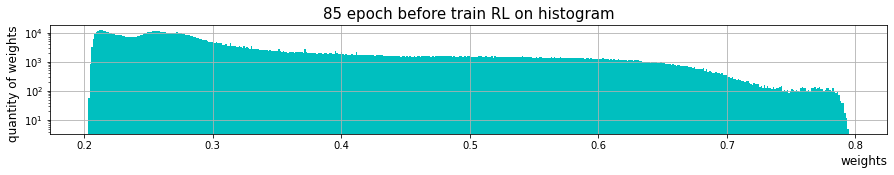

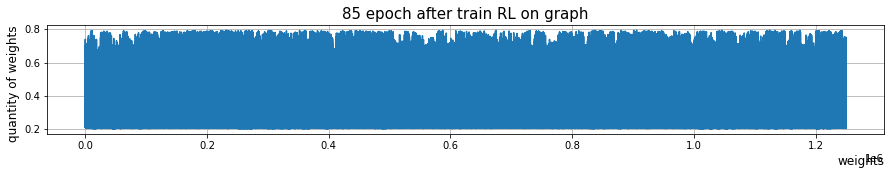

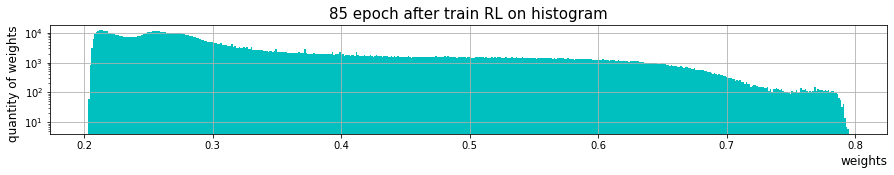

Current Train: 80.54%
Current Test: 76.83%
Current Test Previous: 81.90%
Operational time of epoch #85: 2 min 15 sec
--------------------------------------------------
Epoch #:  86
2760000 images


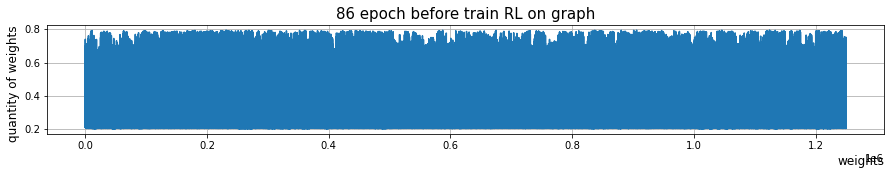

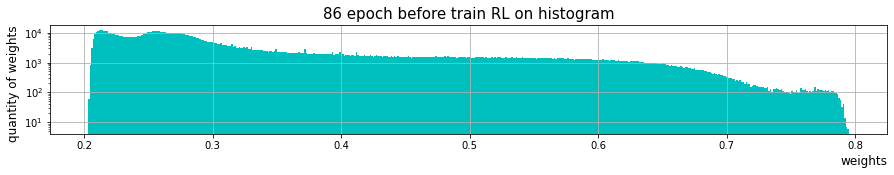

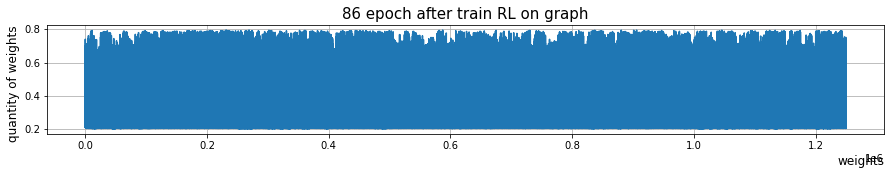

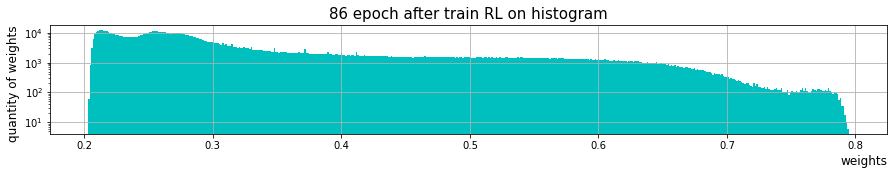

Current Train: 80.50%
Current Test: 76.72%
2780000 images
Current Test Previous: 81.88%
Operational time of epoch #86: 2 min 15 sec
--------------------------------------------------
Epoch #:  87
2800000 images


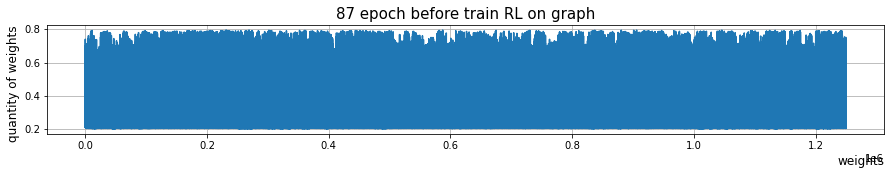

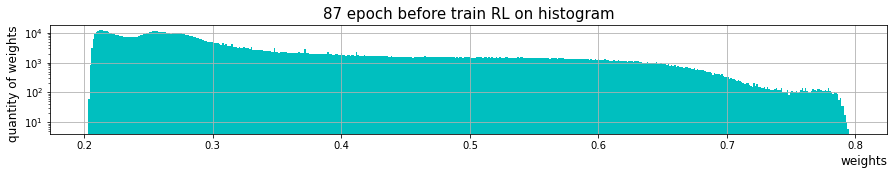

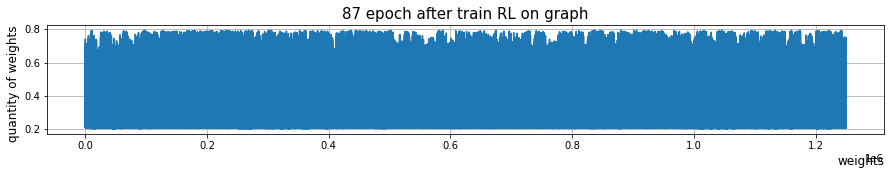

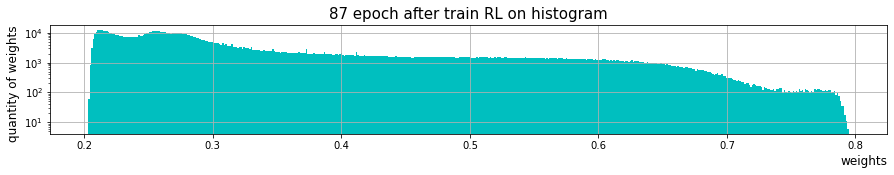

Current Train: 80.27%
Current Test: 76.95%
Current Test Previous: 81.88%
Operational time of epoch #87: 2 min 15 sec
--------------------------------------------------
Epoch #:  88
2820000 images


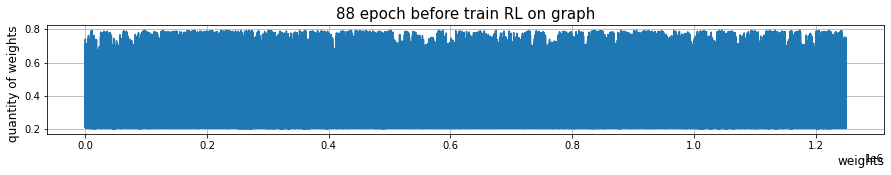

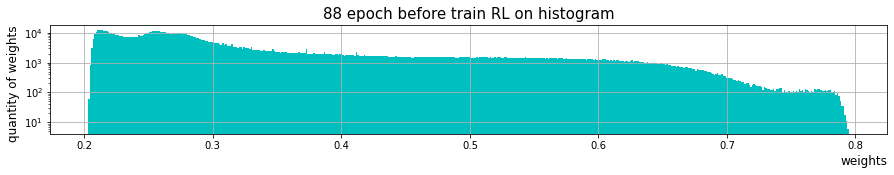

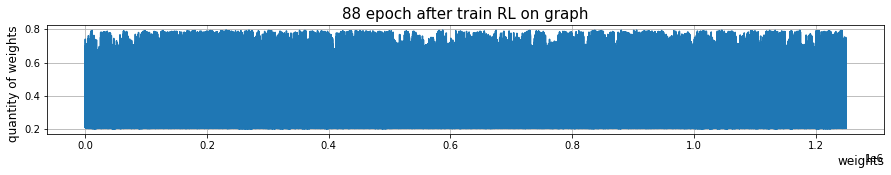

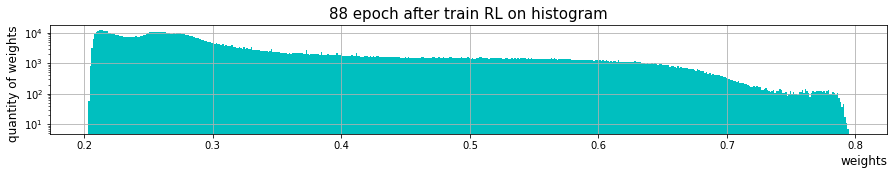

Current Train: 80.50%
2840000 images
Current Test: 76.98%
Current Test Previous: 81.80%
Operational time of epoch #88: 2 min 15 sec
--------------------------------------------------
Epoch #:  89
2860000 images


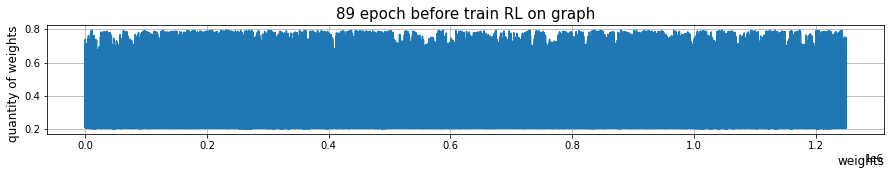

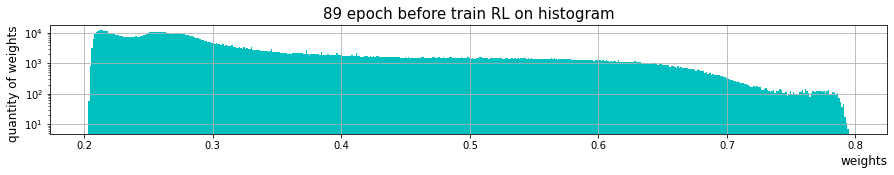

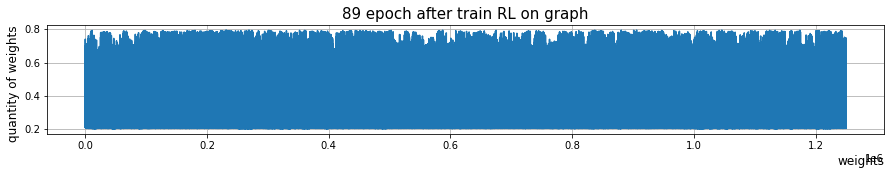

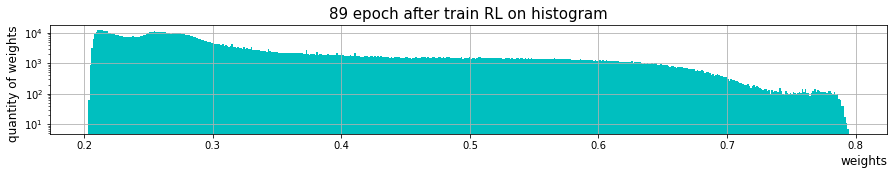

Current Train: 80.45%
Current Test: 76.92%
Current Test Previous: 81.85%
Operational time of epoch #89: 2 min 15 sec
--------------------------------------------------
Epoch #:  90
2880000 images
2900000 images


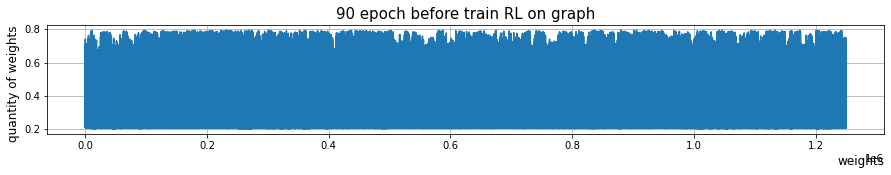

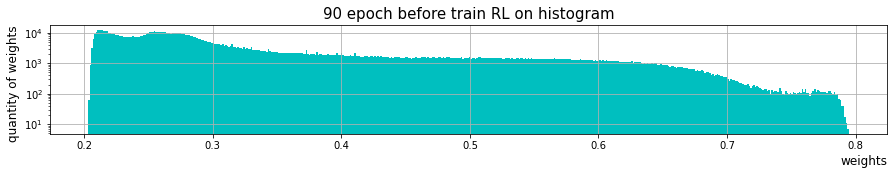

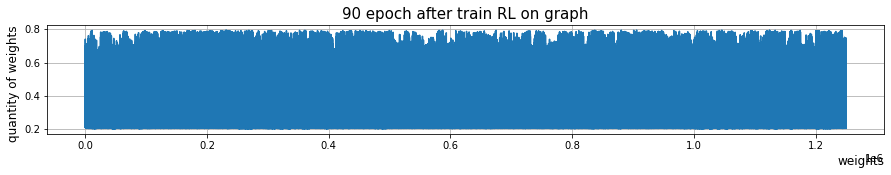

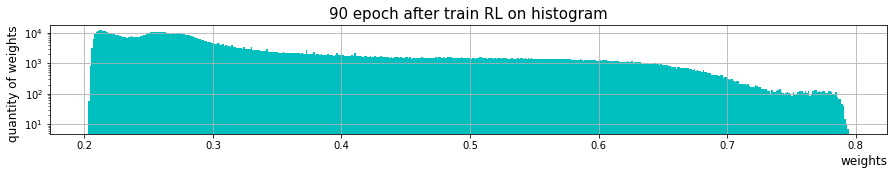

Current Train: 80.48%
Current Test: 76.65%
Current Test Previous: 81.77%
Operational time of epoch #90: 2 min 15 sec
--------------------------------------------------
Epoch #:  91
2920000 images


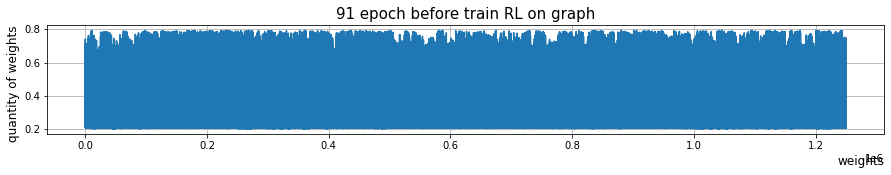

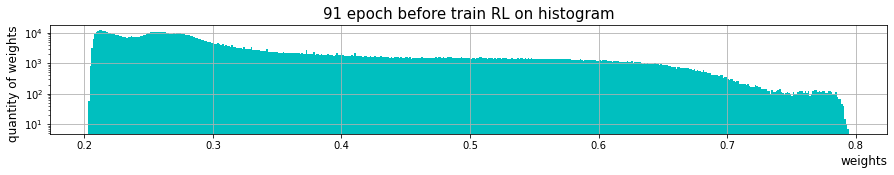

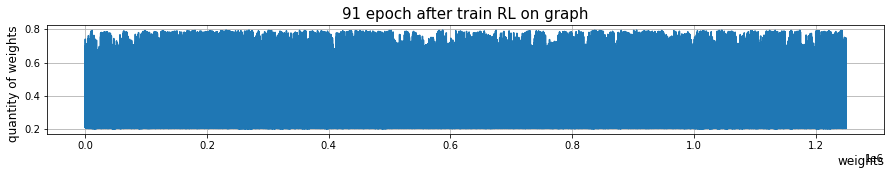

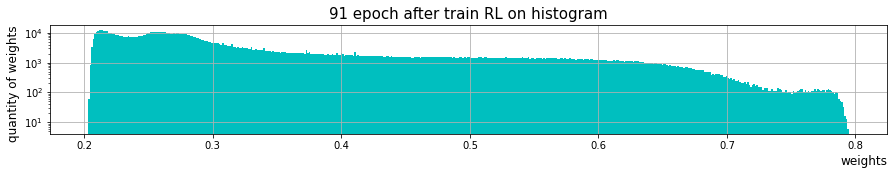

Current Train: 80.57%
Current Test: 76.88%
2940000 images
Current Test Previous: 81.67%
Operational time of epoch #91: 2 min 15 sec
--------------------------------------------------
Epoch #:  92
2960000 images


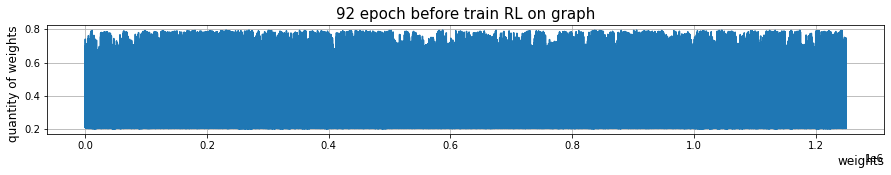

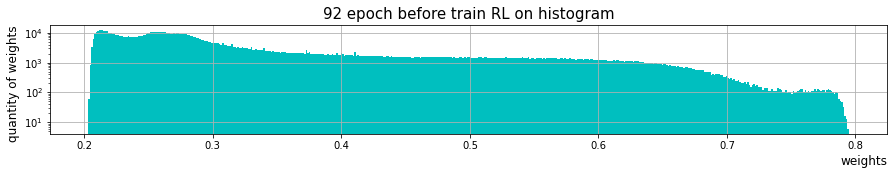

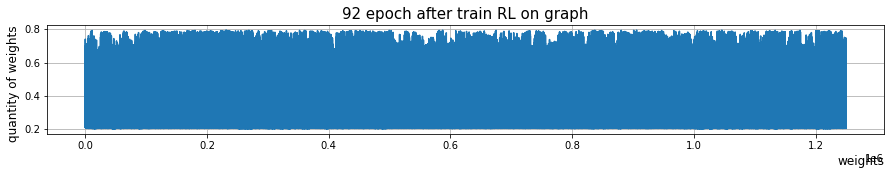

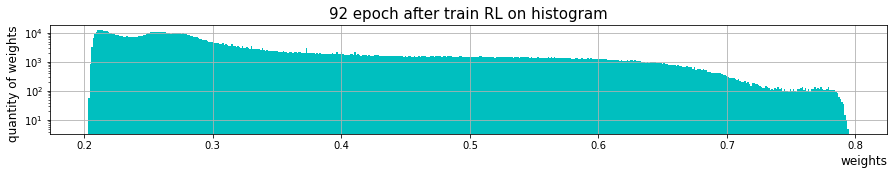

Current Train: 80.40%
Current Test: 76.75%
Current Test Previous: 81.77%
Operational time of epoch #92: 2 min 15 sec
--------------------------------------------------
Epoch #:  93
2980000 images


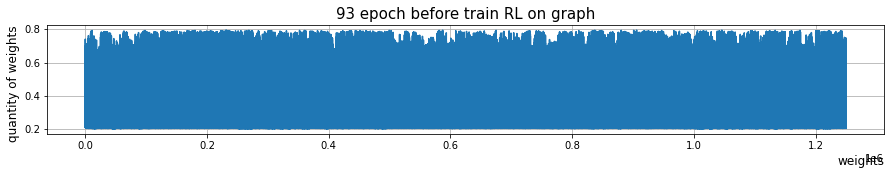

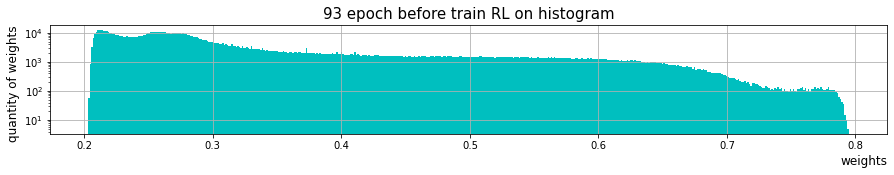

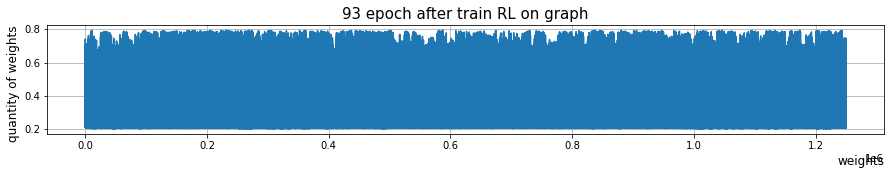

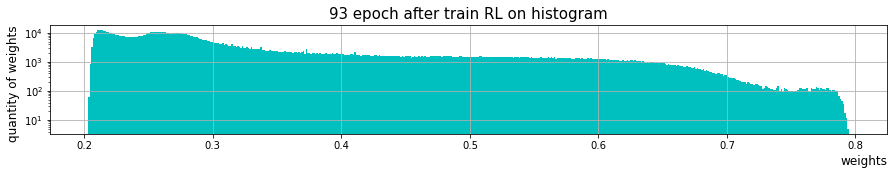

Current Train: 80.53%
3000000 images
Current Test: 76.92%
Current Test Previous: 81.70%
Operational time of epoch #93: 2 min 15 sec
--------------------------------------------------
Epoch #:  94
3020000 images


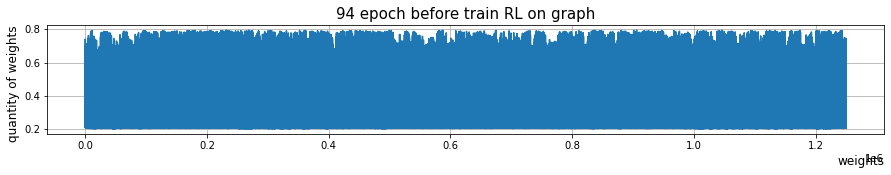

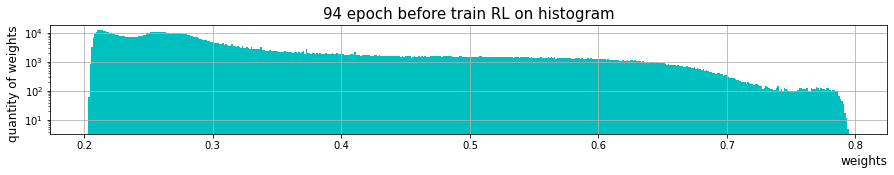

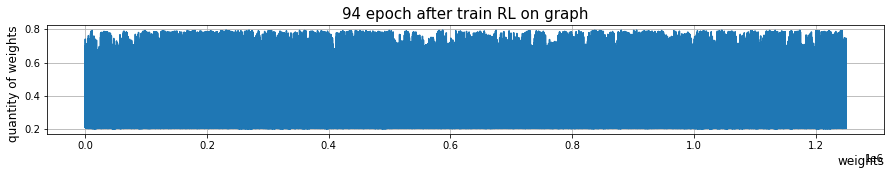

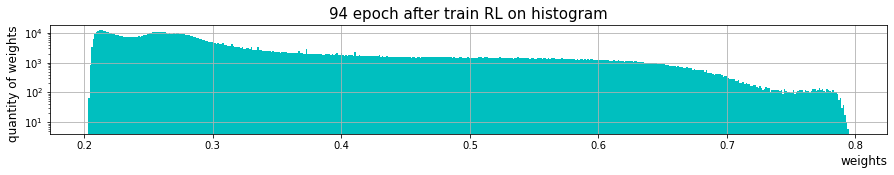

Current Train: 80.56%
Current Test: 76.80%
Current Test Previous: 81.65%
Operational time of epoch #94: 2 min 16 sec
--------------------------------------------------
Epoch #:  95
3040000 images
3060000 images


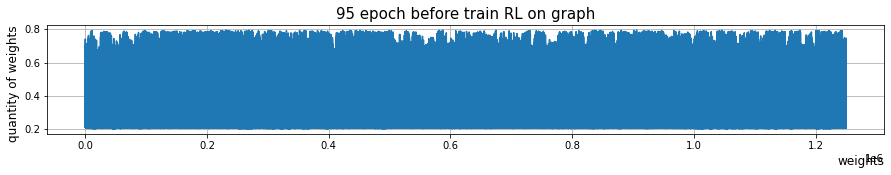

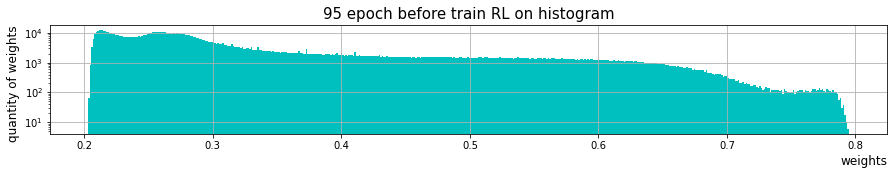

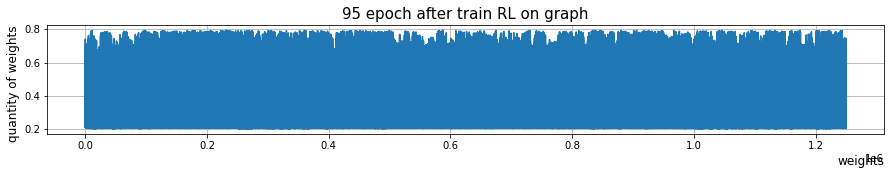

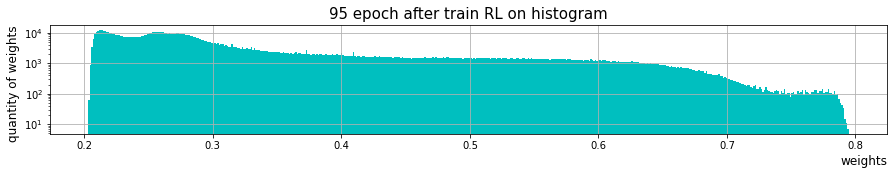

Current Train: 80.73%
Current Test: 76.83%
Current Test Previous: 81.47%
Operational time of epoch #95: 2 min 15 sec
--------------------------------------------------
Epoch #:  96
3080000 images


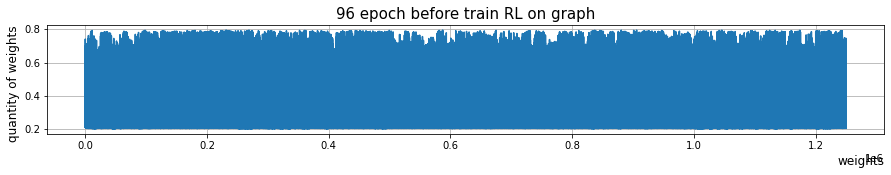

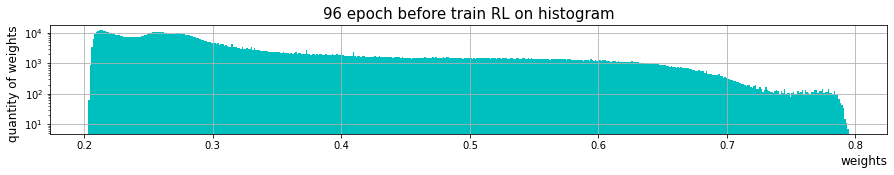

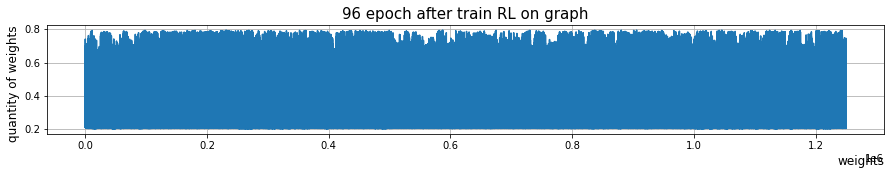

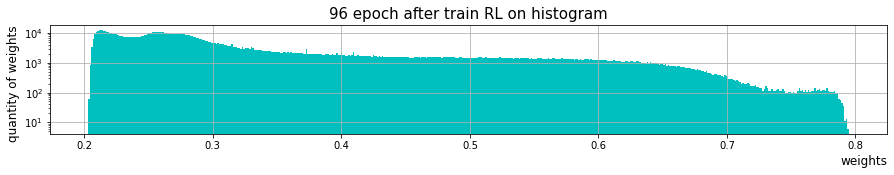

Current Train: 80.60%
Current Test: 76.75%
3100000 images
Current Test Previous: 81.70%
Operational time of epoch #96: 2 min 15 sec
--------------------------------------------------
Epoch #:  97
3120000 images


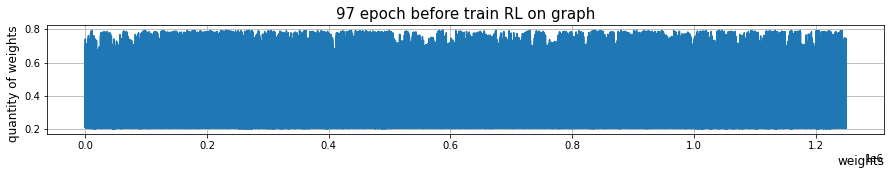

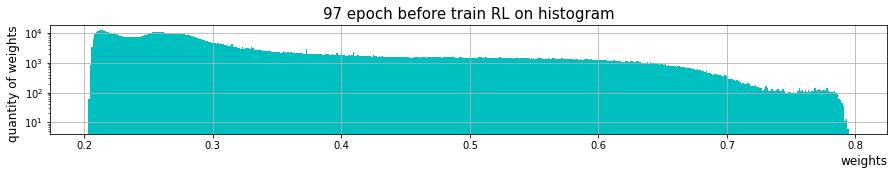

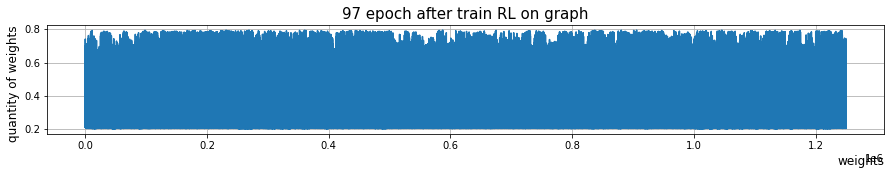

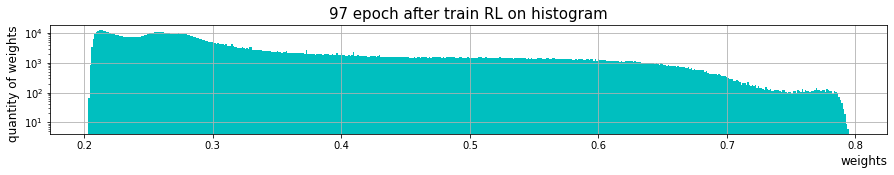

Current Train: 80.62%
Current Test: 76.83%
Current Test Previous: 81.47%
Operational time of epoch #97: 2 min 15 sec
--------------------------------------------------
Epoch #:  98
3140000 images


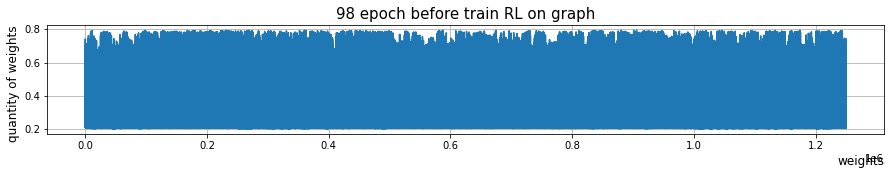

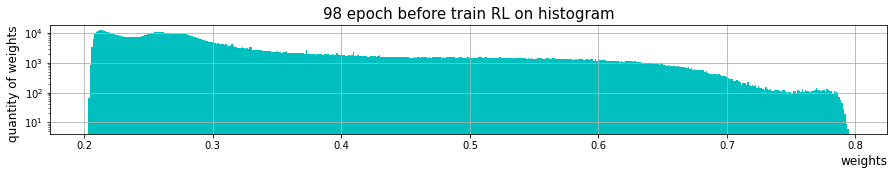

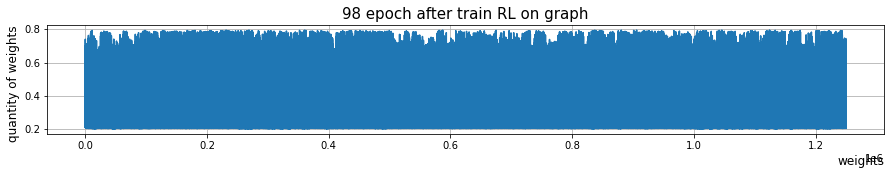

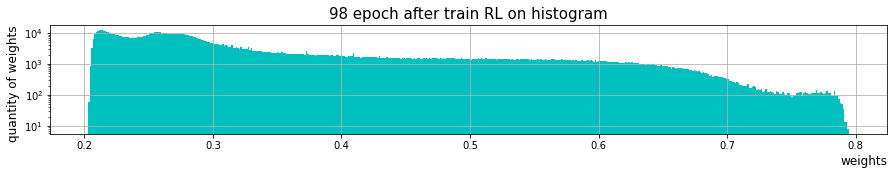

Current Train: 80.57%
3160000 images
Current Test: 76.90%
Current Test Previous: 81.53%
Operational time of epoch #98: 2 min 16 sec
--------------------------------------------------
Epoch #:  99
3180000 images


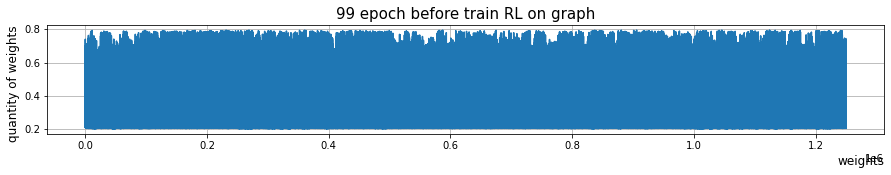

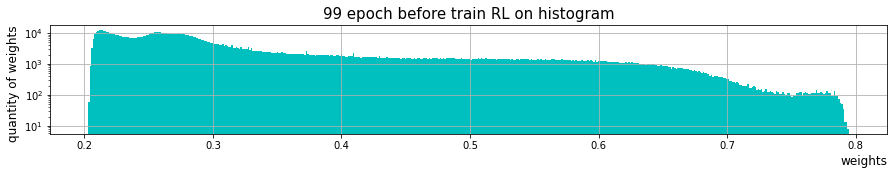

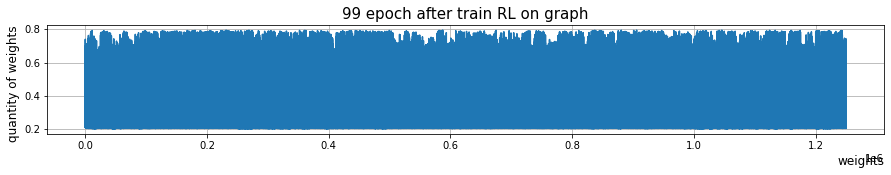

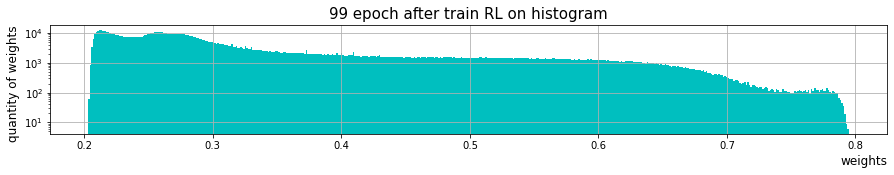

Current Train: 80.55%
Current Test: 76.72%
Current Test Previous: 81.62%
Operational time of epoch #99: 2 min 16 sec
==================== SUMMARY ====================
        Best Train: 80.73% on 95 epoch
         Best Test: 77.40% on 58 epoch
Best Test Previous: 83.55% on 28 epoch


In [30]:
# training the 3rd layer
first_test = third_layer(file_name_net="saved_letters_after_digits_freezed_boundaries_total.net",
                        file_name_csv='parameter_set_letters_after_digits_freezed_boundaries.csv',
                        adaptive_int=0.5, epochs=100, 
                        train_loader=train_letter_loader, 
                        test_loader=test_letter_loader, 
                        test_previous_loader=test_MNIST_loader,
                        model=mozafari, apr=apr, anr=anr, app=app, anp=anp, 
                        parametr_set=parametr_set)

parametr_set = first_test

## Results chart

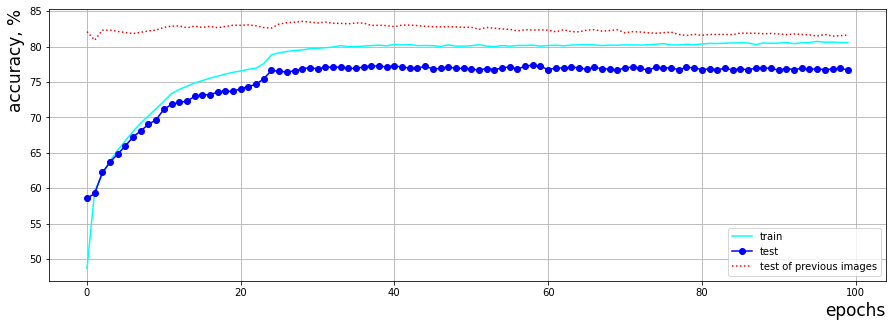

In [31]:
curve_graph(parametr_set)